In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
plt.style.use('ggplot')
import seaborn as sns
pd.options.display.float_format = '{:,.0f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import dataframe_image as dfi
from pandas.api.types import CategoricalDtype
from matplotlib.ticker import MultipleLocator, FuncFormatter
from scipy.stats import linregress
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [2]:
Accepted_Rejected = pd.read_csv('Accepted_Rejected.csv')

In [3]:
#Set order for Employment Length in Accepted_Rejected
emp_length_order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
cat_type = CategoricalDtype(categories=emp_length_order, ordered=True)

Accepted_Rejected['Employment_Length'] = Accepted_Rejected['Employment_Length'].astype(cat_type)

In [4]:
#Single Year Copy
Accepted_Rejected_2017 = Accepted_Rejected[Accepted_Rejected['Year'] == 2017]

In [5]:
Accepted_Rejected_Ord = pd.read_csv('Accepted_Rejected_OrdEncoded.csv')

In [6]:
mixed_cols = [col for col in Accepted_Rejected.columns if Accepted_Rejected[col].apply(type).nunique() > 1]
print('Mixed Type Columns:', mixed_cols)

Mixed Type Columns: []


In [7]:
print('Min DTI:', Accepted_Rejected['Debt-Income'].min())
print('Max DTI:', Accepted_Rejected['Debt-Income'].max())
print(Accepted_Rejected['Debt-Income'].value_counts(dropna=False).sort_index())

Min DTI: 0.0
Max DTI: 50000031.49
Debt-Income
0             381690
0                768
0               1319
0               1632
0               1603
0               1851
0               1675
0               1758
0               1958
0               1596
0               2287
0               1558
0               2318
0               1934
0               2034
0               1910
0               1941
0               2173
0               2062
0               1785
0               2733
0               1911
0               1917
0               2084
0               3109
0               2305
0               1997
0               2439
0               2283
0               2174
0               3441
0               2039
0               2532
0               2720
0               2538
0               2427
0               2845
0               2064
0               3682
0               1874
0               4158
0               2119
0               3091
0               3597
0               2528
0        

In [9]:
#Violin Plots with custom Xcol, Ycol, limits
def violin_plot(xcol, ycol, df=Accepted_Rejected_Ord, yfloor=0, yceiling=None):
    df = df.copy()
    df[ycol] = pd.to_numeric(df[ycol], errors='coerce')

    x_order = sorted(df[xcol].dropna().unique())

    sns.set_style('whitegrid')
    plt.figure(figsize=(14, 8), dpi=300)

    sns.violinplot(
        data=df,
        x=xcol,
        y=ycol,
        hue=xcol,
        order=x_order,
        hue_order=x_order,
        palette='viridis'
    )

    plt.title(f'{ycol} Distribution by {xcol}', fontsize=14)
    plt.xlabel(xcol, fontsize=12)
    plt.ylabel(ycol, fontsize=12)

    plt.ylim(yfloor, yceiling)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [10]:
def stacked_density_with_stats_boxes(col, trim_max=None):
    sns.set_style('whitegrid')
    plt.figure(figsize=(12, 6), dpi=150)
    
    #Extreme values
    df = Accepted_Rejected.copy()
    df = df[df[col].notna()]
    df = df[df[col] >= 0]
    if trim_max is not None:
        df = df[df[col] <= trim_max]
    
    # Stats
    stats = {}
    for app, color in zip(['Accepted', 'Rejected'], ['green', 'red']):
        subset = df[df['Application'] == app]
        stats[app] = {
            'color': color,
            'mean': subset[col].mean(),
            'min': subset[col].min(),
            'max': subset[col].max(),
            'count': subset[col].count()
        }
    
    #KDEs
    for app, s in stats.items():
        subset = df[df['Application'] == app]
        sns.kdeplot(
            data=subset,
            x=col,
            fill=True,
            label=app,
            color=s['color'],
            alpha=0.6,
            legend=False
        )
        plt.axvline(s['min'], color=s['color'], linestyle=':', linewidth=1.5)
        plt.axvline(s['mean'], color=s['color'], linestyle='--', linewidth=2)
        plt.axvline(s['max'], color=s['color'], linestyle=':', linewidth=1.5)
    
    ymax = plt.gca().get_ylim()[1]
    
    #Text Boxes
    text_positions = {
        'Accepted': {'xpos': df[col].max(), 'ha': 'right', 'ypos': ymax*0.95},
        'Rejected': {'xpos': df[col].min(), 'ha': 'left', 'ypos': ymax*0.95}
    }
    for app, s in stats.items():
        pos = text_positions[app]
        plt.text(
            pos['xpos'], pos['ypos'],
            f"{app}\nMean: {s['mean']:.2f}\nMin: {s['min']:.2f}\nMax: {s['max']:.2f}\nCount: {s['count']:,}",
            color=s['color'], ha=pos['ha'], va='top', fontsize=11, fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor=s['color'])
        )
    
    plt.title(f'Layered Density of {col} by Application Status', fontsize=18, pad=20)
    plt.xlabel(col, fontsize=15)
    plt.ylabel('Density', fontsize=15)
    
    if trim_max is not None:
        plt.xlim(0, trim_max)
    
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
    plt.tight_layout()
    plt.show()

In [11]:
def stacked_hist_acceptance(col, bins=100, xformat='number', max_clip=None, alpha=0.6): 
    sns.set_style('whitegrid')
    plt.figure(figsize=(12, 6), dpi=150)
    
    #Clip extreme values
    df = Accepted_Rejected.copy()
    df = df[df[col].notna()]
    df = df[df[col] >= 0]
    
    if max_clip is not None:
        df[col] = df[col].clip(upper=max_clip)
    
    sns.histplot(
        data=df,
        x=col,
        hue='Application',
        multiple='layer',
        bins=bins,
        palette={'Accepted': 'green', 'Rejected': 'red'},
        alpha=alpha,
        edgecolor=None,
        legend=False
    )
    
    #Stats
    accepted = df[df['Application'] == 'Accepted'][col]
    rejected = df[df['Application'] == 'Rejected'][col]
    
    stats = {
        'Accepted': {
            'color': 'green',
            'mean': accepted.mean(),
            'min': accepted.min(),
            'max': accepted.max(),
            'count': accepted.count(),
            'ha': 'right',
            'xpos': df[col].max()
        },
        'Rejected': {
            'color': 'red',
            'mean': rejected.mean(),
            'min': rejected.min(),
            'max': rejected.max(),
            'count': rejected.count(),
            'ha': 'left',
            'xpos': df[col].min()
        }
    }
    
    ymax = plt.gca().get_ylim()[1]
    
    #Vertical lines & Text Boxes
    for status, s in stats.items():
        color = s['color']
        plt.axvline(s['min'], color=color, linestyle=':', linewidth=1.5)
        plt.axvline(s['mean'], color=color, linestyle='--', linewidth=2)
        plt.axvline(s['max'], color=color, linestyle=':', linewidth=1.5)
        
        plt.text(
            s['xpos'], ymax * 0.95,
            f"{status}\nMean: {s['mean']:.0f}\nMin: {s['min']:.0f}\nMax: {s['max']:.0f}\nCount: {s['count']:,}",
            color=color, ha=s['ha'], va='top', fontsize=11, fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor=color)
        )

    plt.title(f'Histogram of {col} by Acceptance', fontsize=18, pad=20)
    plt.xlabel(col, fontsize=15)
    plt.ylabel('Count', fontsize=15)
    
    #Dynamic tick spacing
    xmin, xmax = plt.gca().get_xlim()
    #tickspace = 50
    tickspace = max(1, (xmax - xmin) / 10)
    plt.gca().xaxis.set_major_locator(MultipleLocator(tickspace))
    
    if xformat == 'percent':
        plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))
    else:
        plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
    
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
    plt.tight_layout()
    plt.show()

In [12]:
Accepted_Rejected.head()

Loan_Amount  Risk_Score  Debt-Income State Employment_Length  Year  \
0        3,600         677            6    PA         10+ years  2015   
1       24,700         717           16    SD         10+ years  2015   
2       20,000         697           11    IL         10+ years  2015   
3       35,000         787           17    NJ         10+ years  2015   
4       10,400         697           25    PA           3 years  2015   

  Credit_Policy Application  
0           New    Accepted  
1           New    Accepted  
2           New    Accepted  
3           New    Accepted  
4           New    Accepted

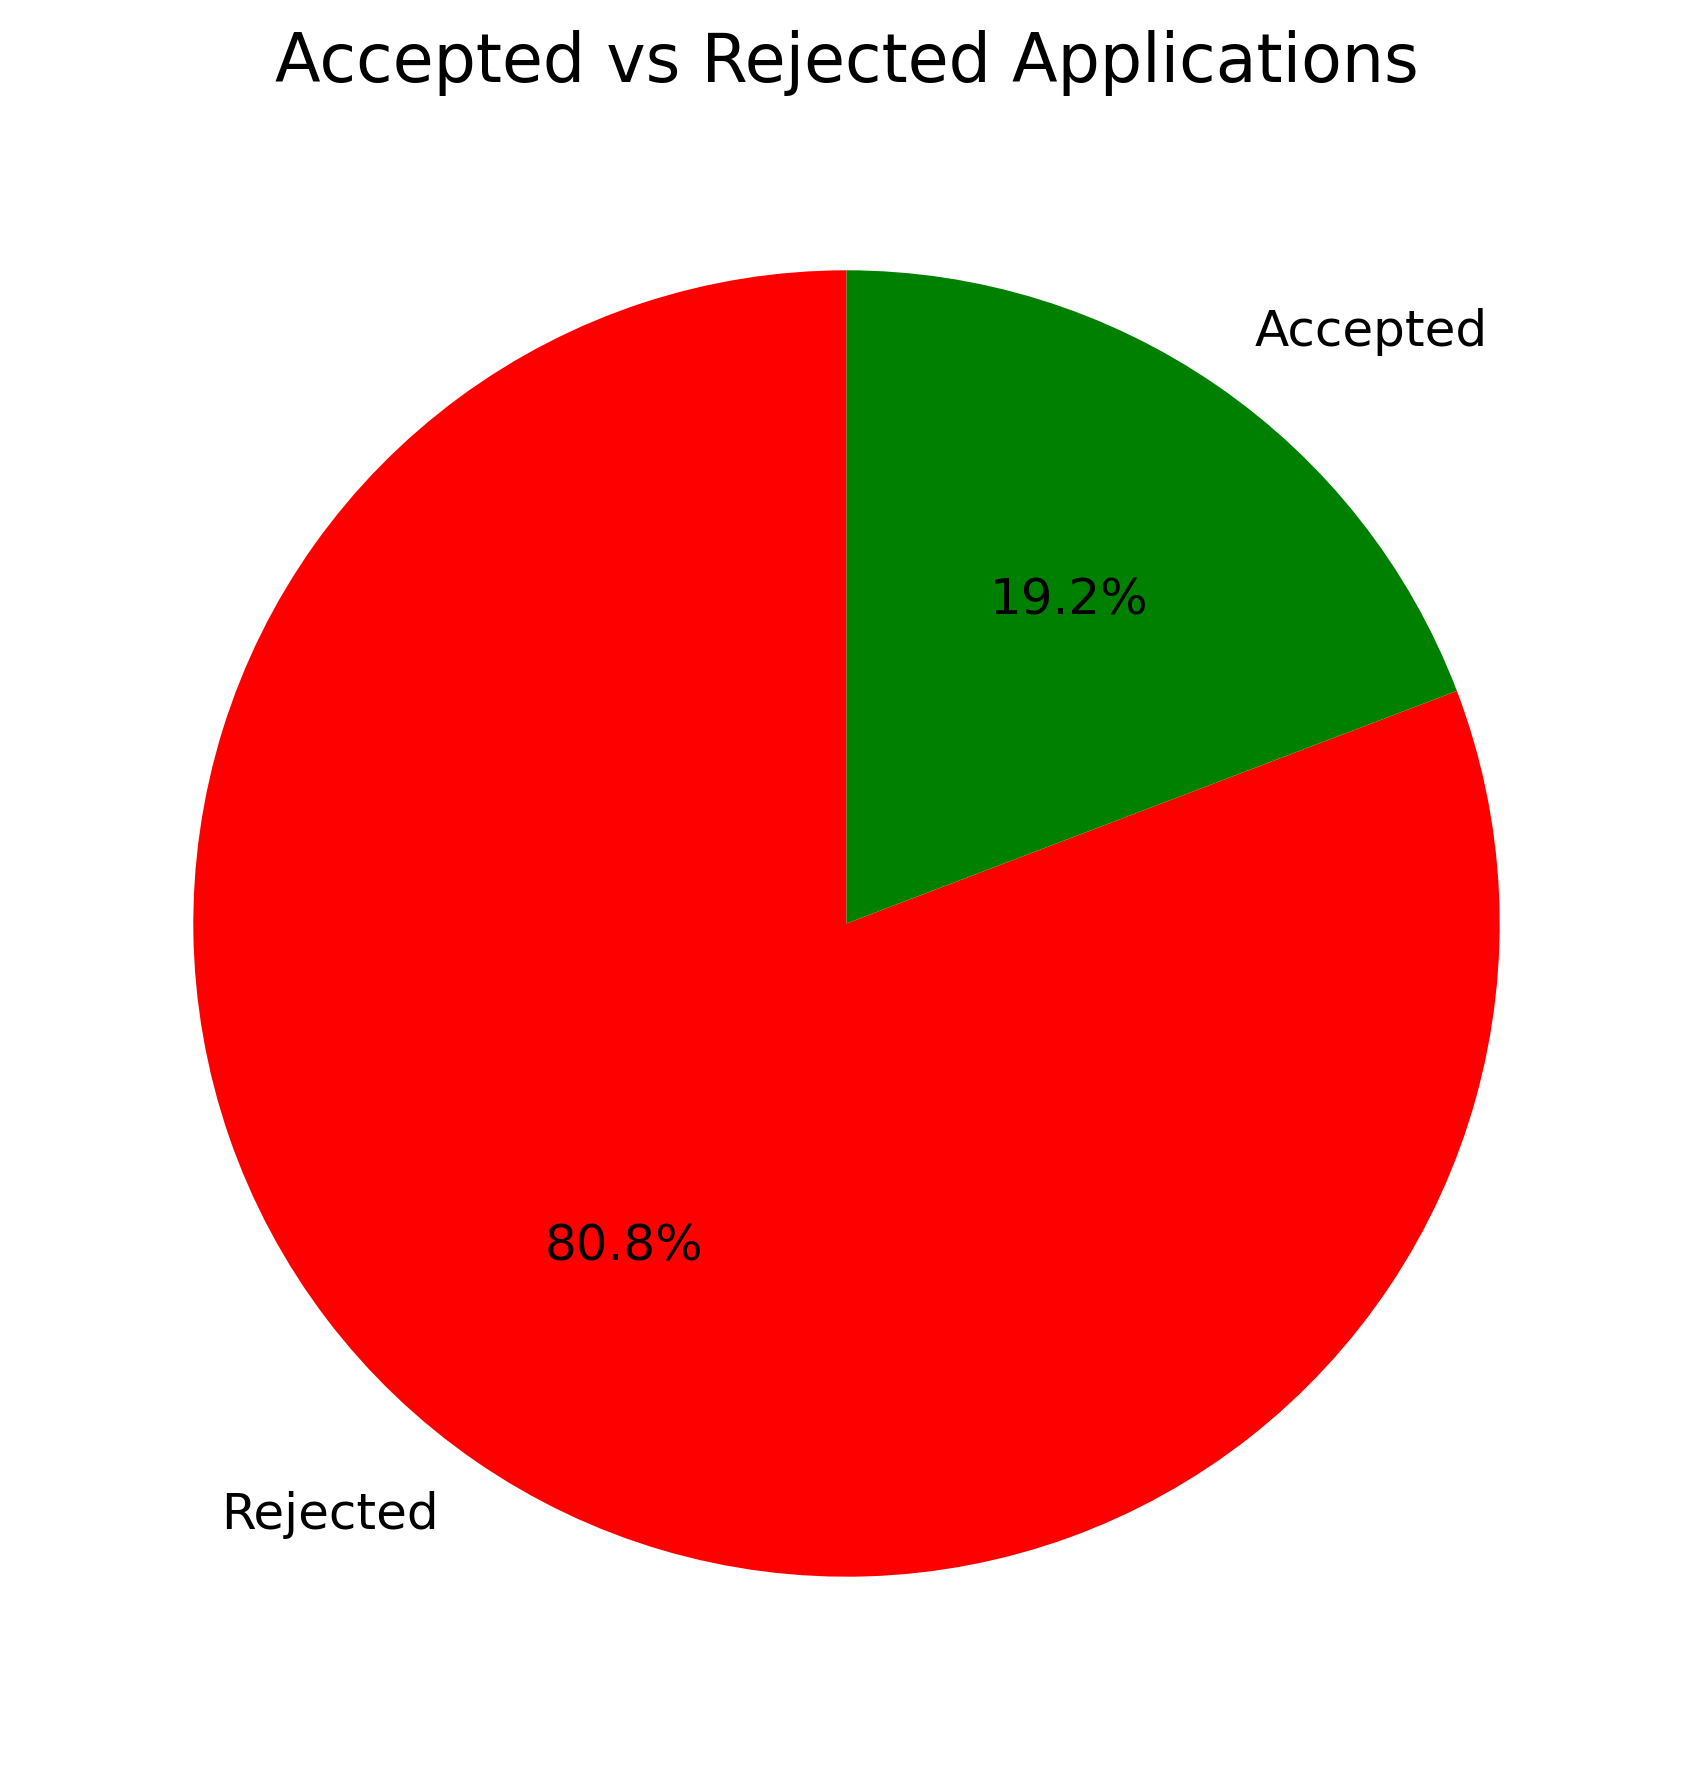

In [13]:
#Pie Chart: Accepted vs Rejected Applications
status_counts = Accepted_Rejected['Application'].value_counts()

plt.figure(figsize=(6, 6), dpi=300)
colors = ['red', 'green']

plt.pie(
    status_counts,
    labels=status_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12}
)

plt.title('Accepted vs Rejected Applications', fontsize=16)
plt.tight_layout()
plt.show()

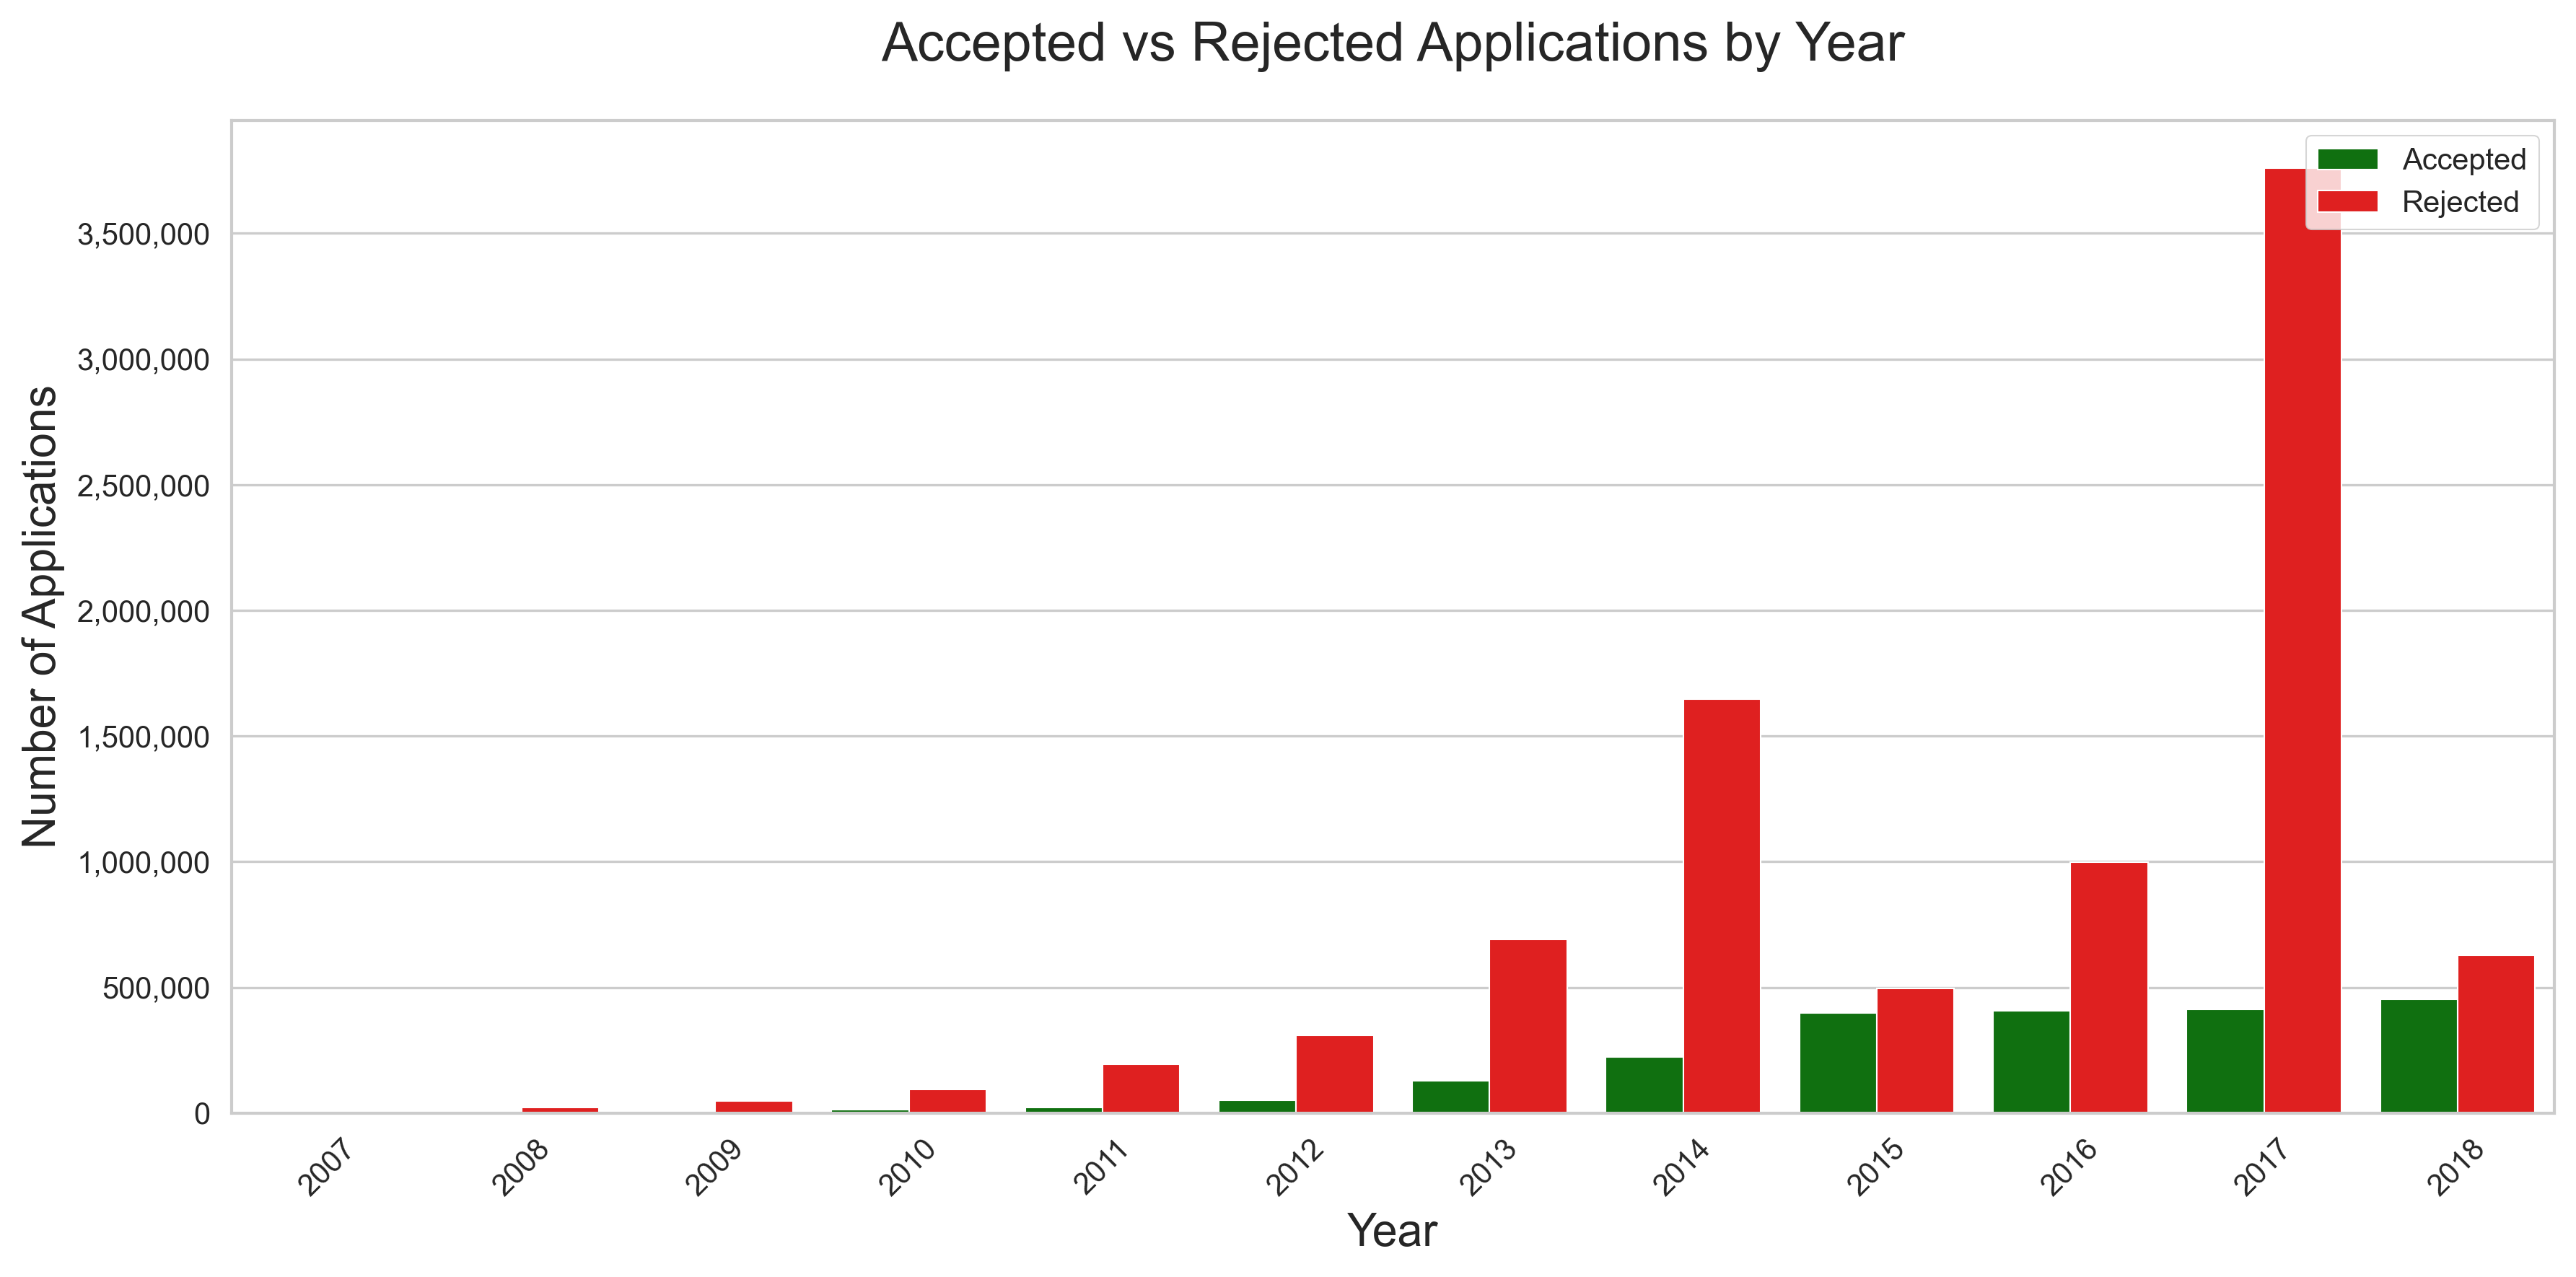

In [14]:
#Barplot- Applications Status Counts by Year
col = 'Year'
accepted_counts = (Accepted_Rejected.loc[Accepted_Rejected['Application'] == 'Accepted', col].value_counts().sort_index())
rejected_counts = (Accepted_Rejected.loc[Accepted_Rejected['Application'] == 'Rejected', col].value_counts().sort_index())

#Combine counts
col_vals = sorted(set(accepted_counts.index) | set(rejected_counts.index))
combined = pd.DataFrame({
    col: col_vals,
    'Accepted': accepted_counts.reindex(col_vals, fill_value=0).values,
    'Rejected': rejected_counts.reindex(col_vals, fill_value=0).values
})

#Convert for Seaborn
melted = combined.melt(
    id_vars=col,
    value_vars=['Accepted', 'Rejected'],
    var_name='Application_Status',
    value_name='Count'
)

sns.set_style('whitegrid')
plt.figure(figsize=(12, 6), dpi=300)

sns.barplot(
    data=melted,
    x=col,
    y='Count',
    hue='Application_Status',
    hue_order=['Accepted', 'Rejected'],
    palette=['green', 'red'],
)

plt.title(f'Accepted vs Rejected Applications by {col}', fontsize=18, pad=20)
plt.xlabel(col, fontsize=15)
plt.ylabel('Number of Applications', fontsize=15)
plt.xticks(rotation=45)
plt.legend(title='', loc='upper right')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

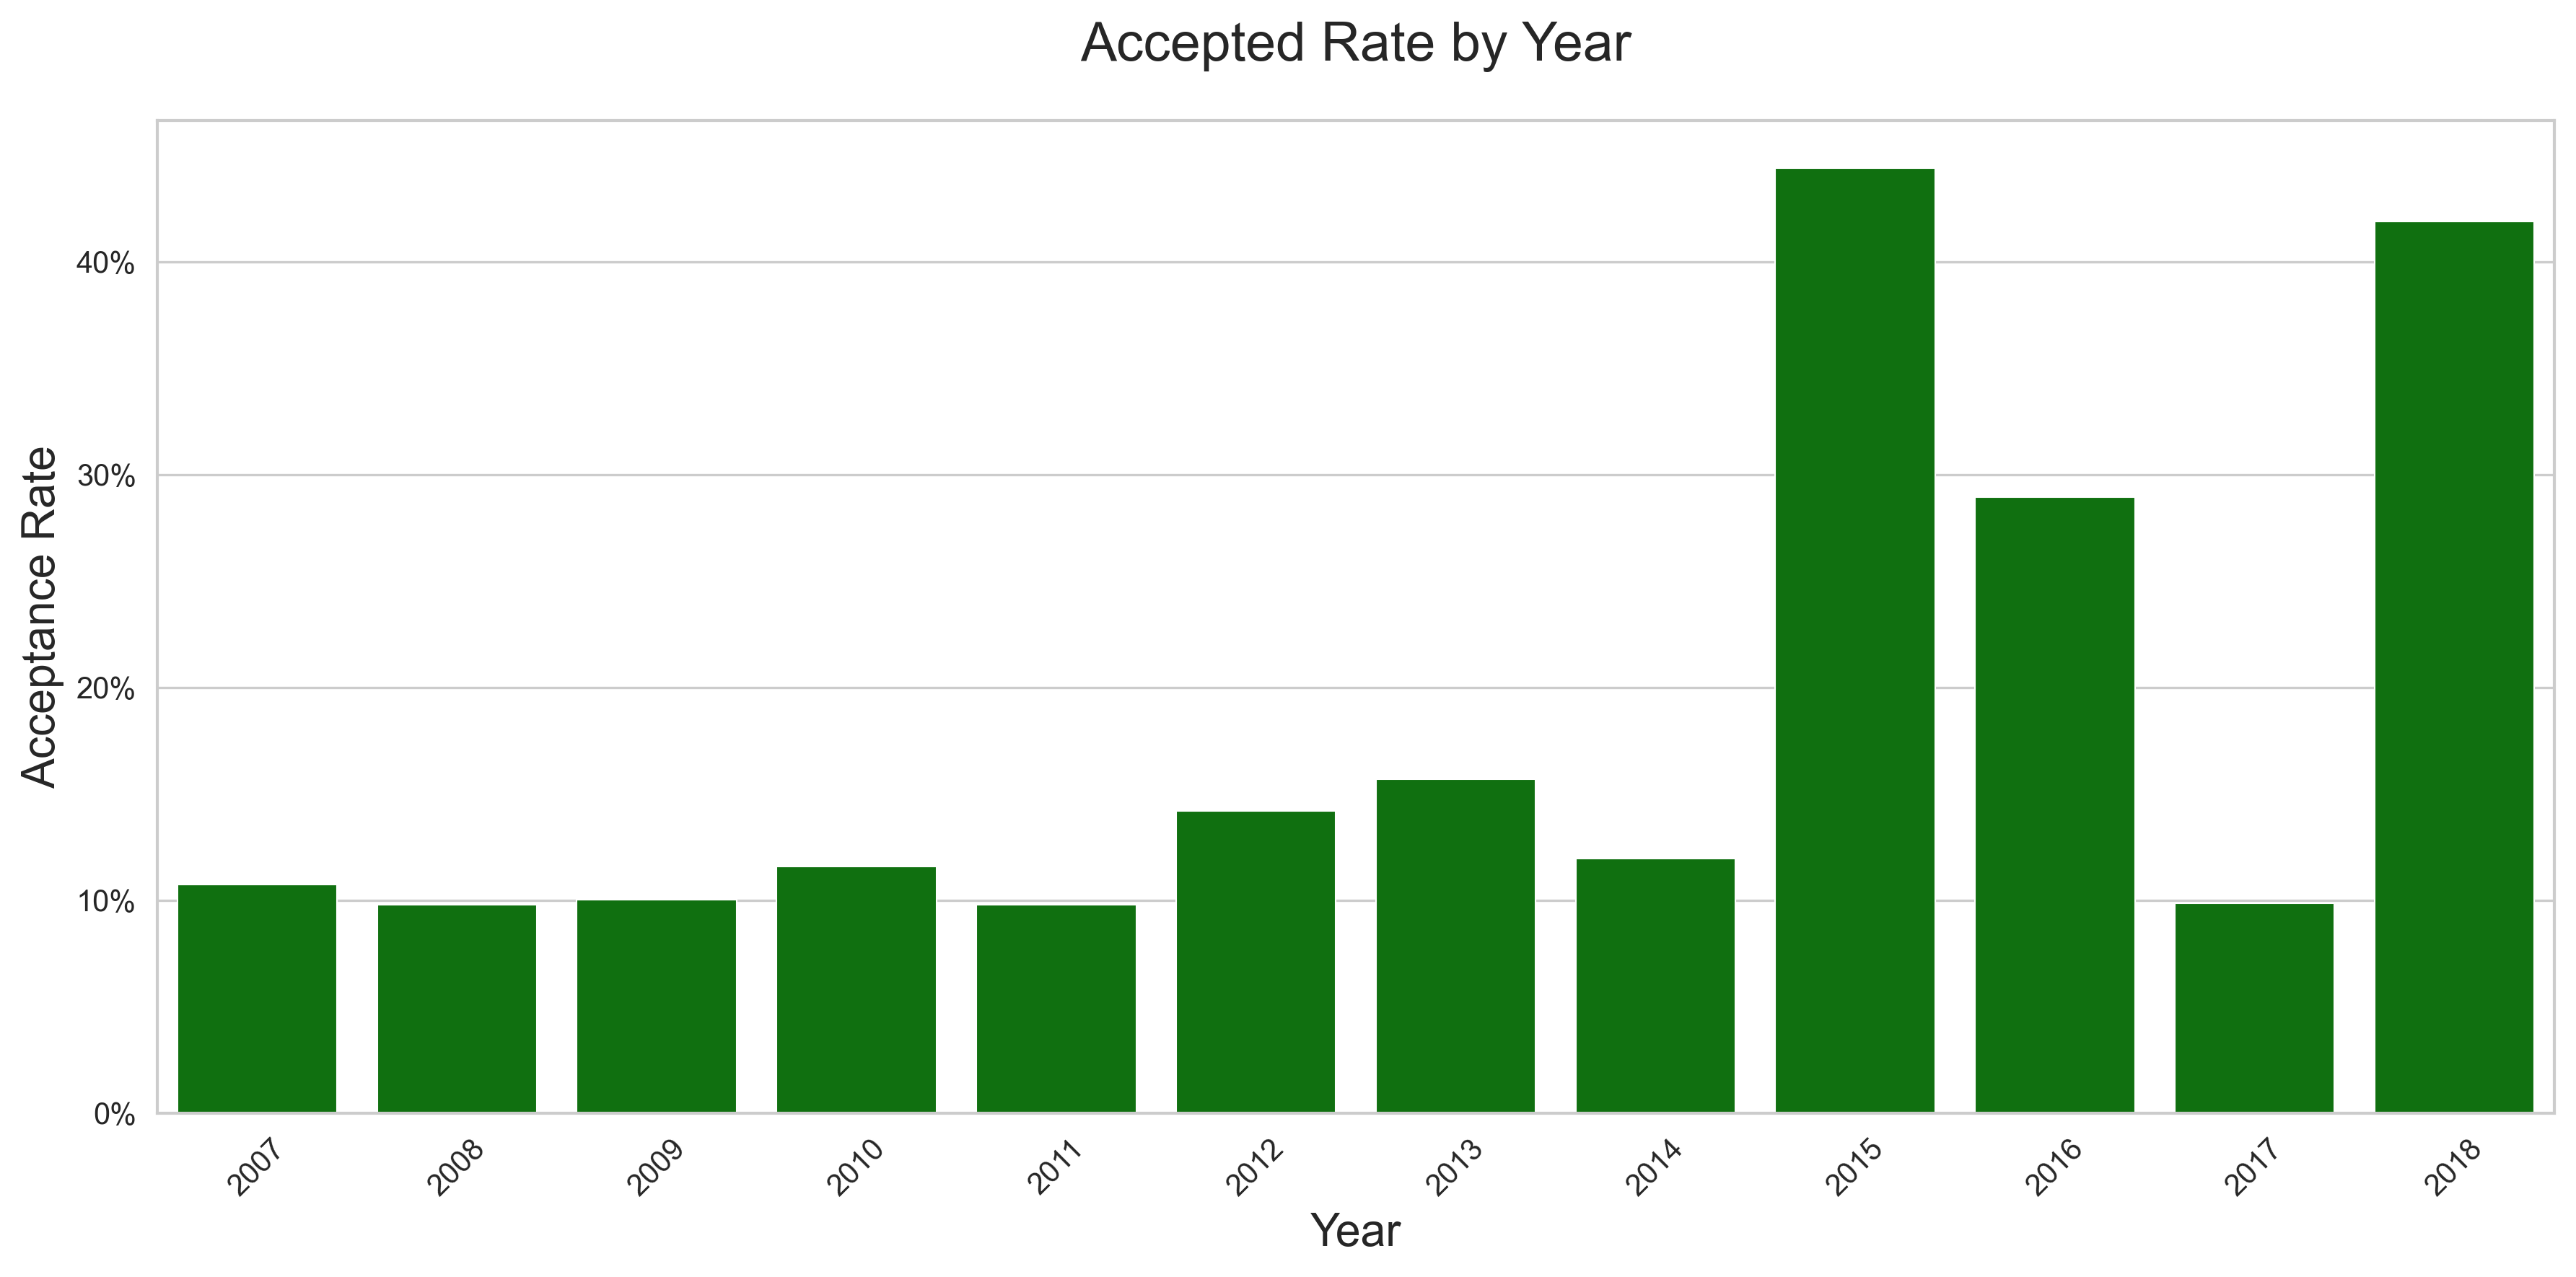

In [15]:
#Barplot- Applications ACCEPTANCE RATES by Year
col = 'Year'

accepted_counts = Accepted_Rejected.loc[Accepted_Rejected['Application'] == 'Accepted', col].value_counts().sort_index()
rejected_counts = Accepted_Rejected.loc[Accepted_Rejected['Application'] == 'Rejected', col].value_counts().sort_index()

#Combine
col_vals = sorted(set(accepted_counts.index) | set(rejected_counts.index))
combined = pd.DataFrame({
    col: col_vals,
    'Accepted': accepted_counts.reindex(col_vals, fill_value=0).values,
    'Rejected': rejected_counts.reindex(col_vals, fill_value=0).values
})

#Calculate accepted rate
combined['Accepted_Rate'] = combined['Accepted'] / (combined['Accepted'] + combined['Rejected'])

#Plot
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6), dpi=300)

sns.barplot(
    data=combined,
    x=col,
    y='Accepted_Rate',
    color='green'
)
plt.title(f'Accepted Rate by {col}', fontsize=18, pad=20)
plt.xlabel(col, fontsize=15)
plt.ylabel('Acceptance Rate', fontsize=15)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.tight_layout()
plt.show()

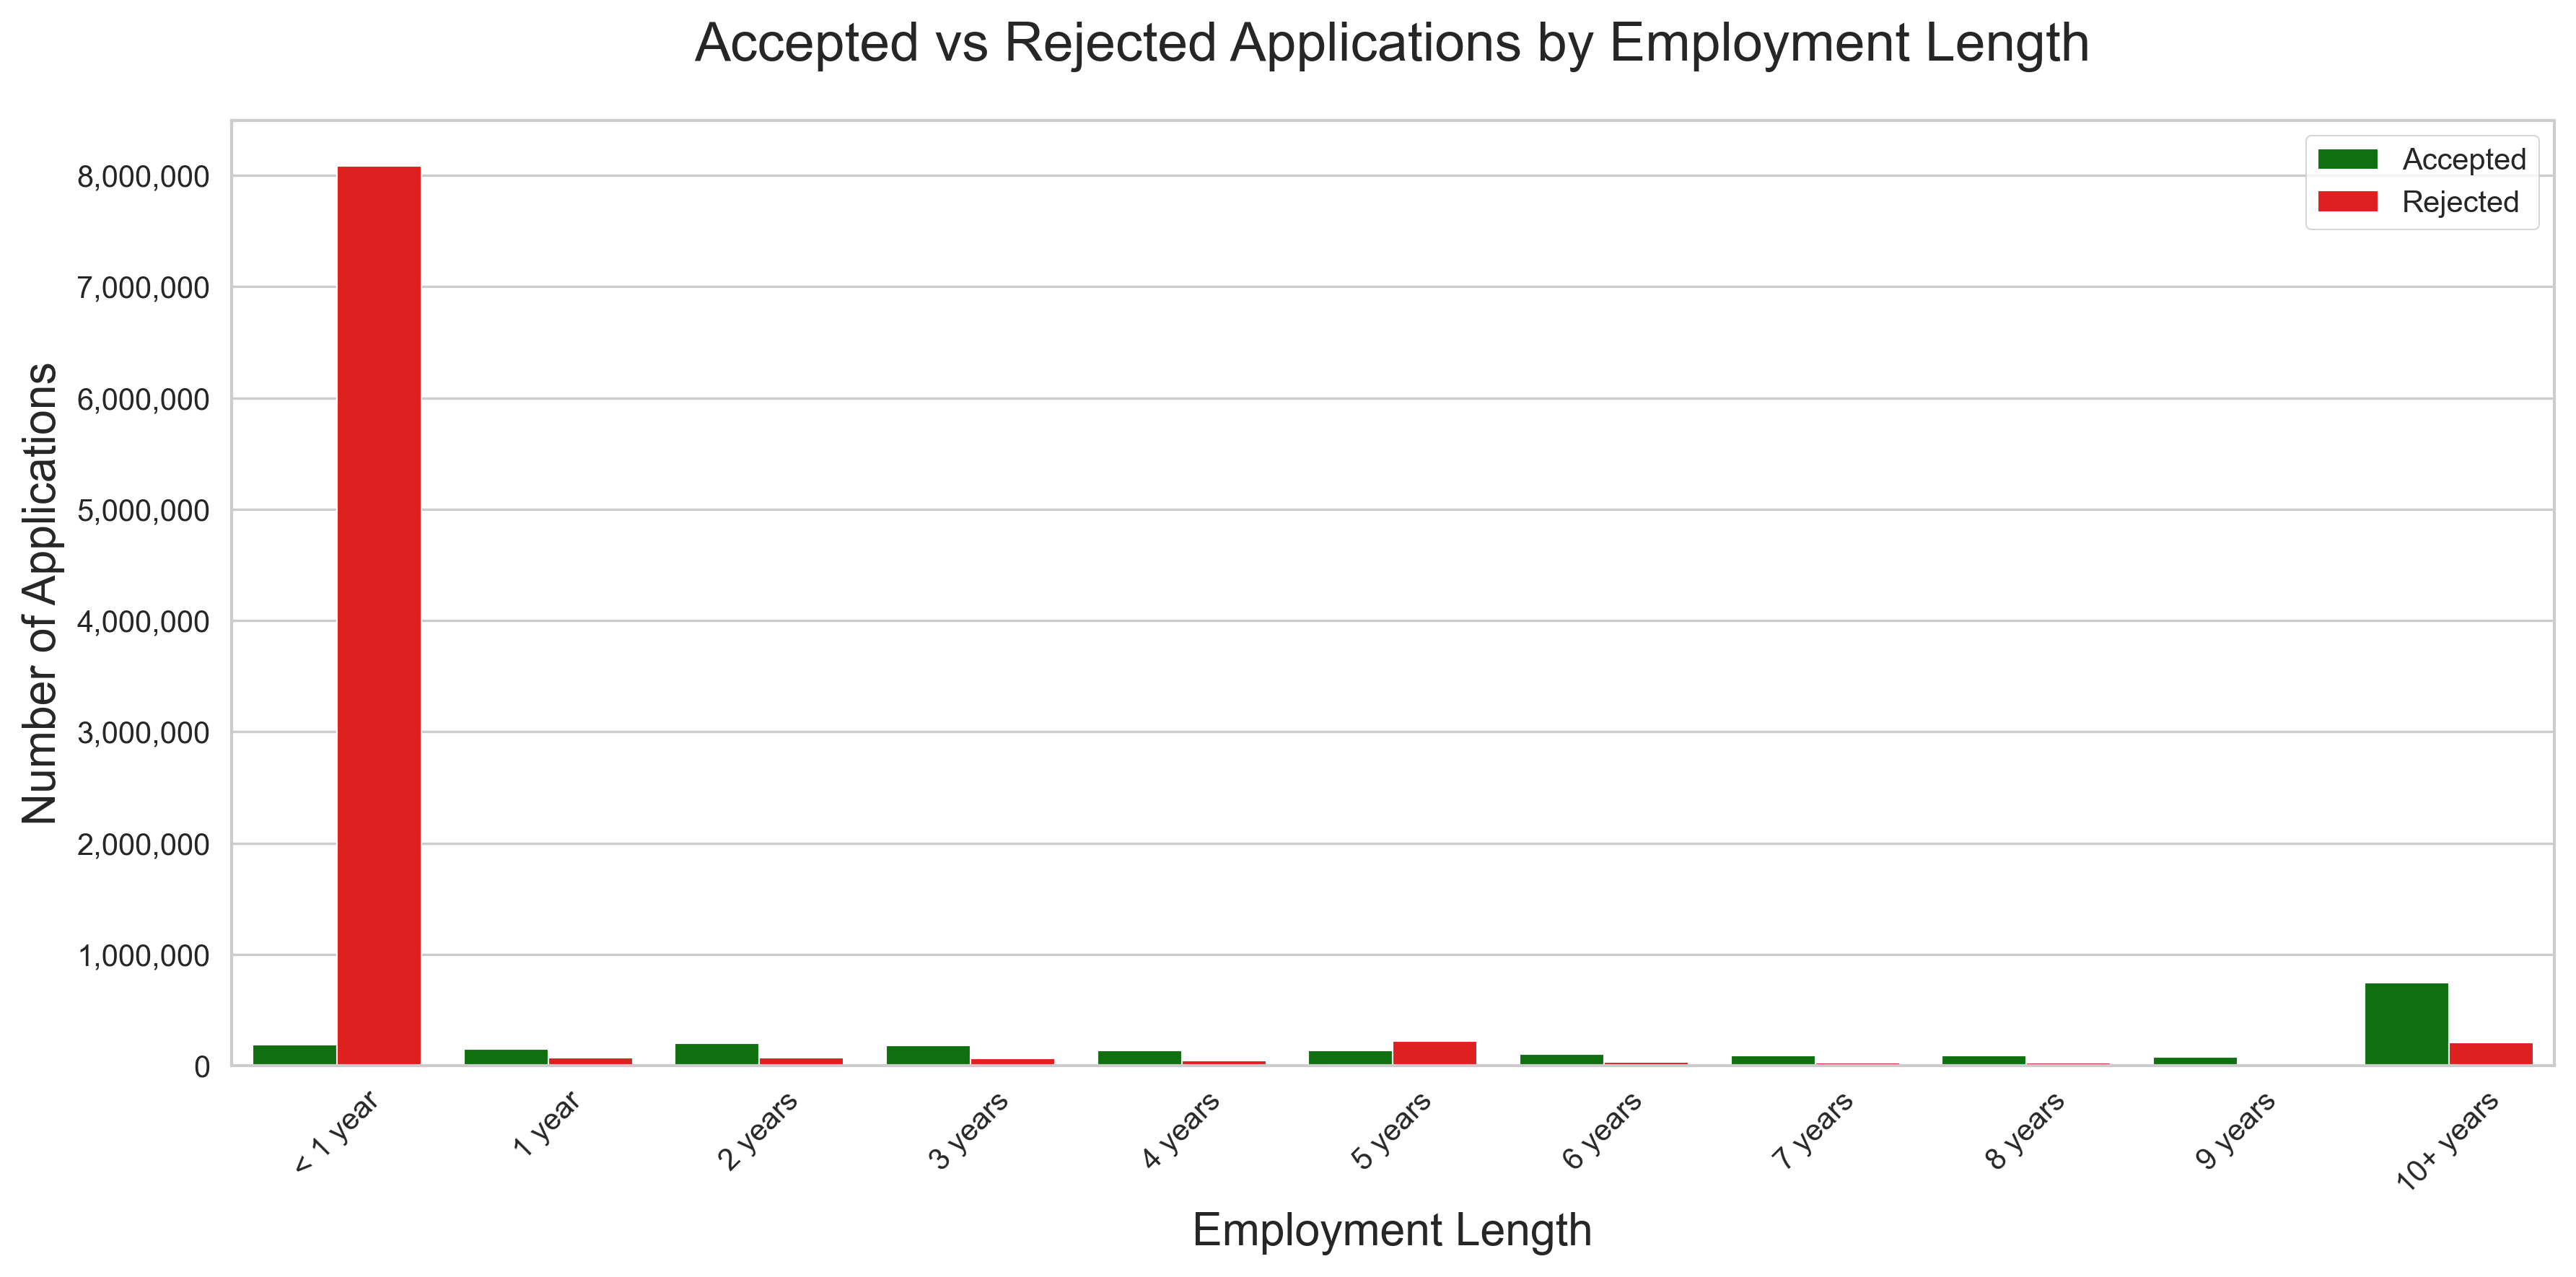

In [16]:
#Barplot- Applications Status Counts by Employment Length
col = 'Employment_Length'

accepted_counts = Accepted_Rejected[Accepted_Rejected['Application'] == 'Accepted'][col].value_counts().sort_index()
rejected_counts = Accepted_Rejected[Accepted_Rejected['Application'] == 'Rejected'][col].value_counts().sort_index()

#Combine
lengths = sorted(set(accepted_counts.index) | set(rejected_counts.index))
combined = pd.DataFrame({
    'Employment_Length': emp_length_order,
    'Accepted': accepted_counts.reindex(emp_length_order, fill_value=0).values,
    'Rejected': rejected_counts.reindex(emp_length_order, fill_value=0).values
})

#Convert for Seaborn
melted = combined.melt(
    id_vars='Employment_Length',
    value_vars=['Accepted', 'Rejected'],
    var_name='Application_Status',
    value_name='Count'
)

sns.set_style('whitegrid')
plt.figure(figsize=(12, 6), dpi=300)

sns.barplot(
    data=melted,
    x='Employment_Length',
    y='Count',
    hue='Application_Status',
    palette=['green', 'red'],
)

plt.title('Accepted vs Rejected Applications by Employment Length', fontsize=18, pad=20)
plt.xlabel('Employment Length', fontsize=15)
plt.ylabel('Number of Applications', fontsize=15)
plt.xticks(rotation=45)
plt.legend(title='', loc='upper right')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

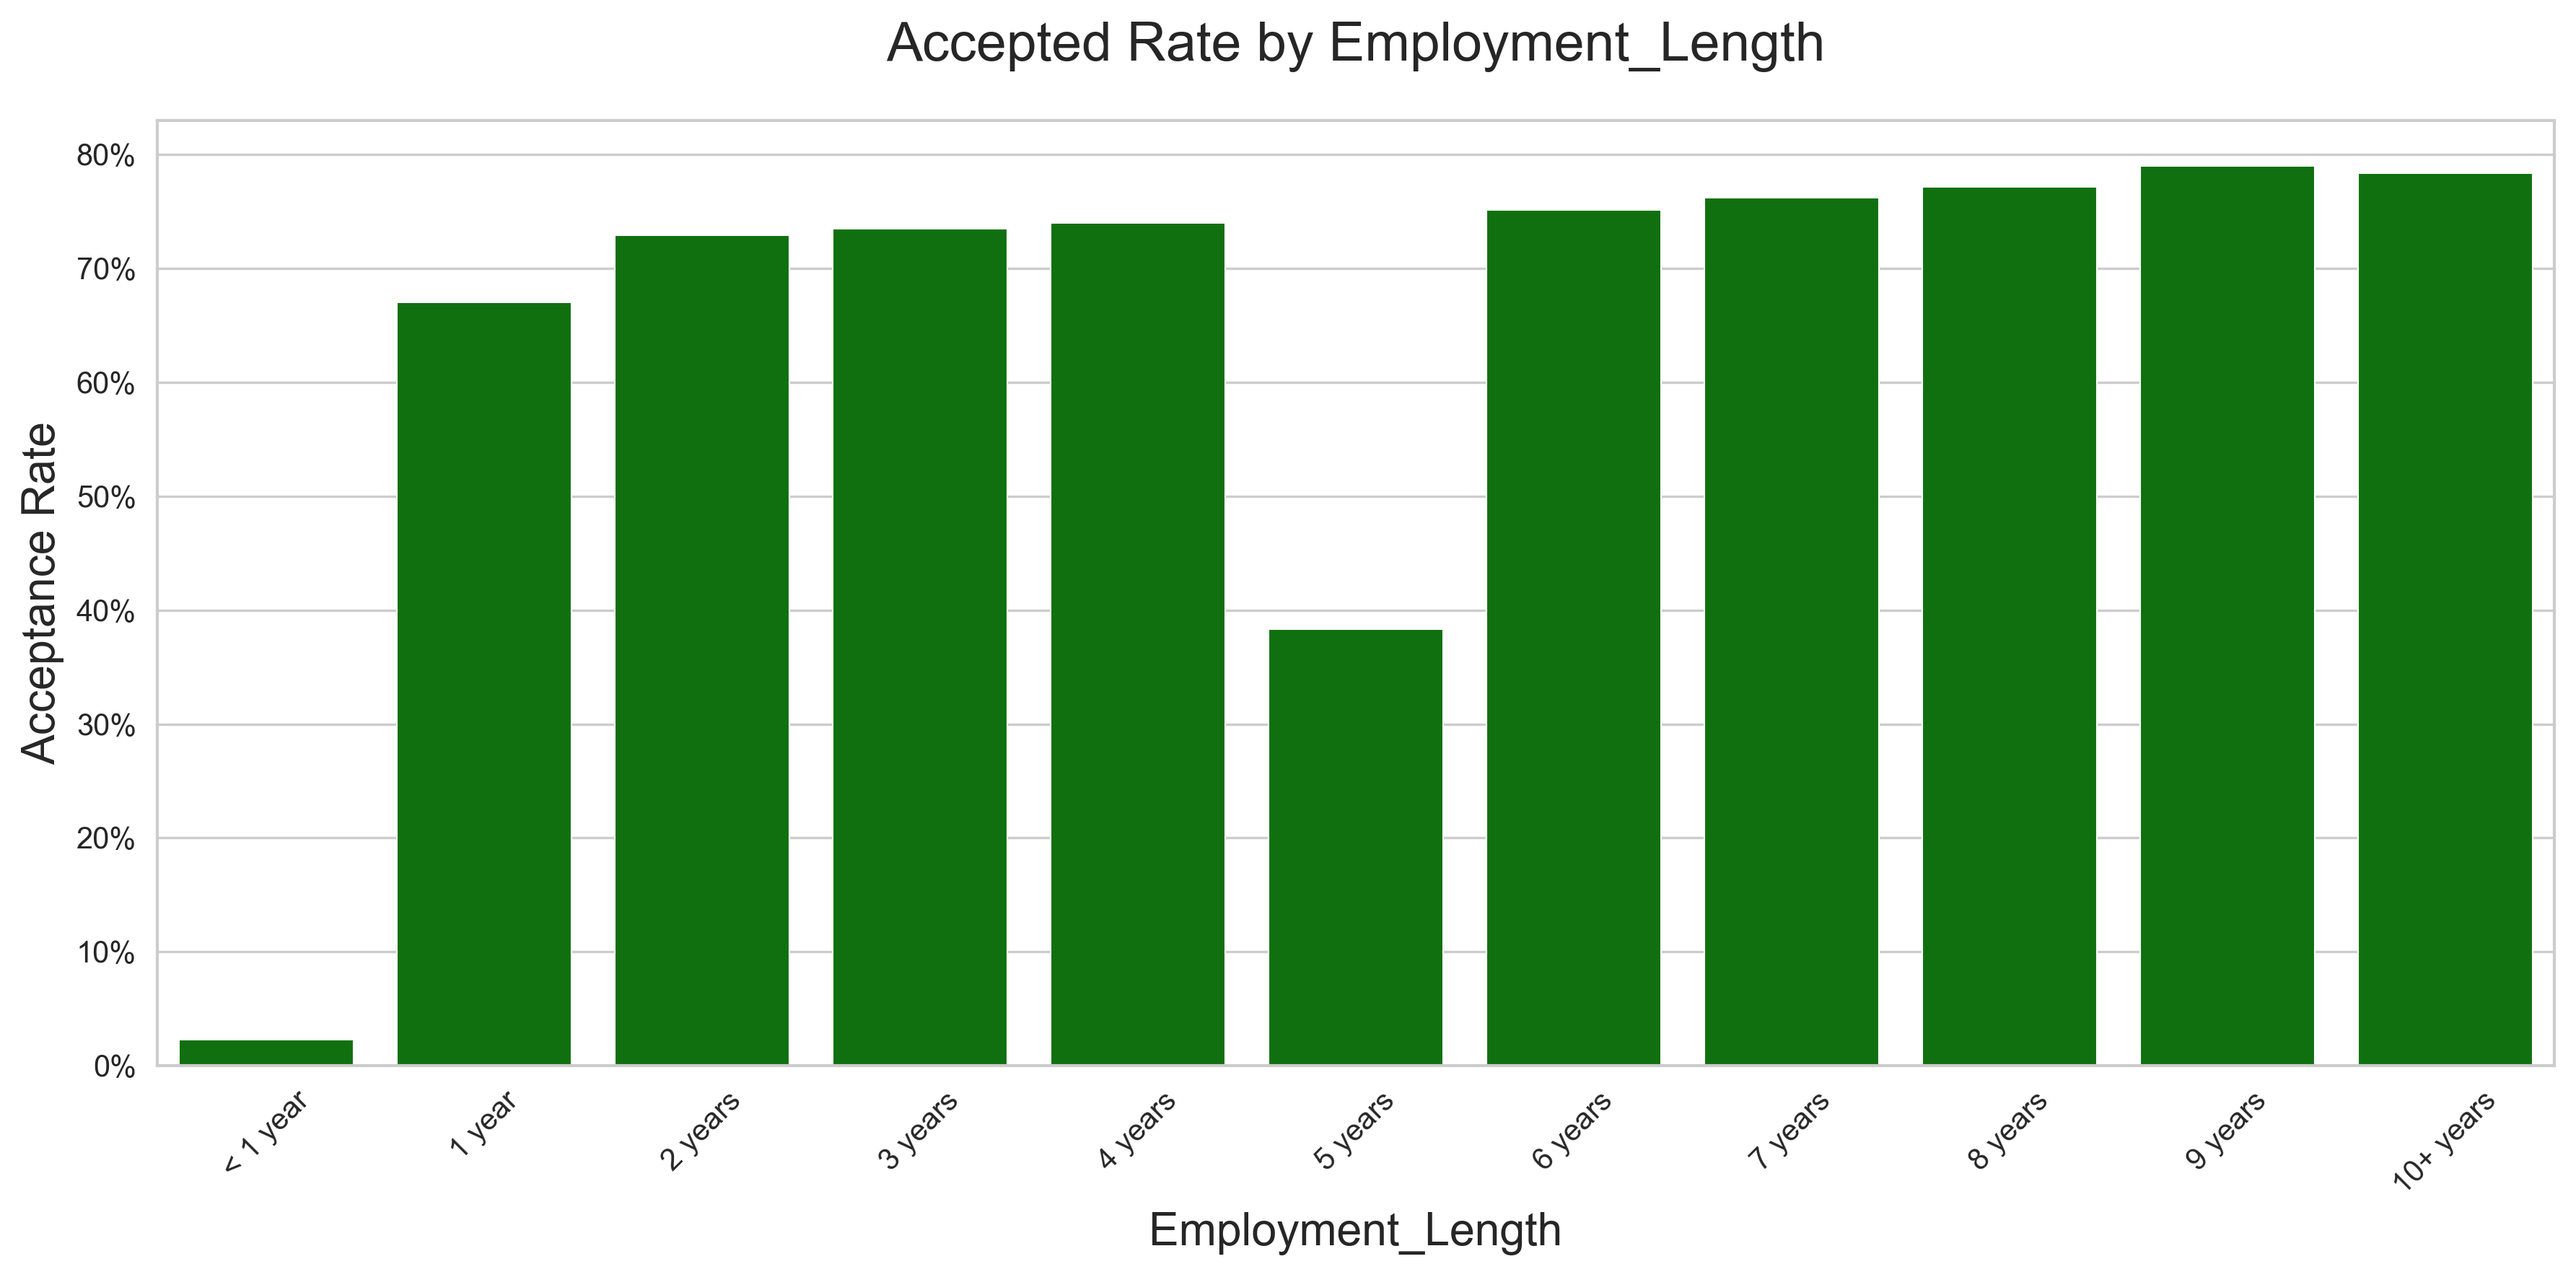

In [17]:
#Barplot- Applications ACCEPTANCE RATES by Employment Length
col = 'Employment_Length'

accepted_counts = Accepted_Rejected.loc[Accepted_Rejected['Application'] == 'Accepted', col].value_counts().sort_index()
rejected_counts = Accepted_Rejected.loc[Accepted_Rejected['Application'] == 'Rejected', col].value_counts().sort_index()

#Combine
col_vals = sorted(set(accepted_counts.index) | set(rejected_counts.index))
combined = pd.DataFrame({
    col: emp_length_order,
    'Accepted': accepted_counts.reindex(emp_length_order, fill_value=0).values,
    'Rejected': rejected_counts.reindex(emp_length_order, fill_value=0).values
})

#Calculate accepted rate
combined['Accepted_Rate'] = combined['Accepted'] / (combined['Accepted'] + combined['Rejected'])

#Plot
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6), dpi=300)

sns.barplot(
    data=combined,
    x=col,
    y='Accepted_Rate',
    color='green'
)
plt.title(f'Accepted Rate by {col}', fontsize=18, pad=20)
plt.xlabel(col, fontsize=15)
plt.ylabel('Acceptance Rate', fontsize=15)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.tight_layout()
plt.show()

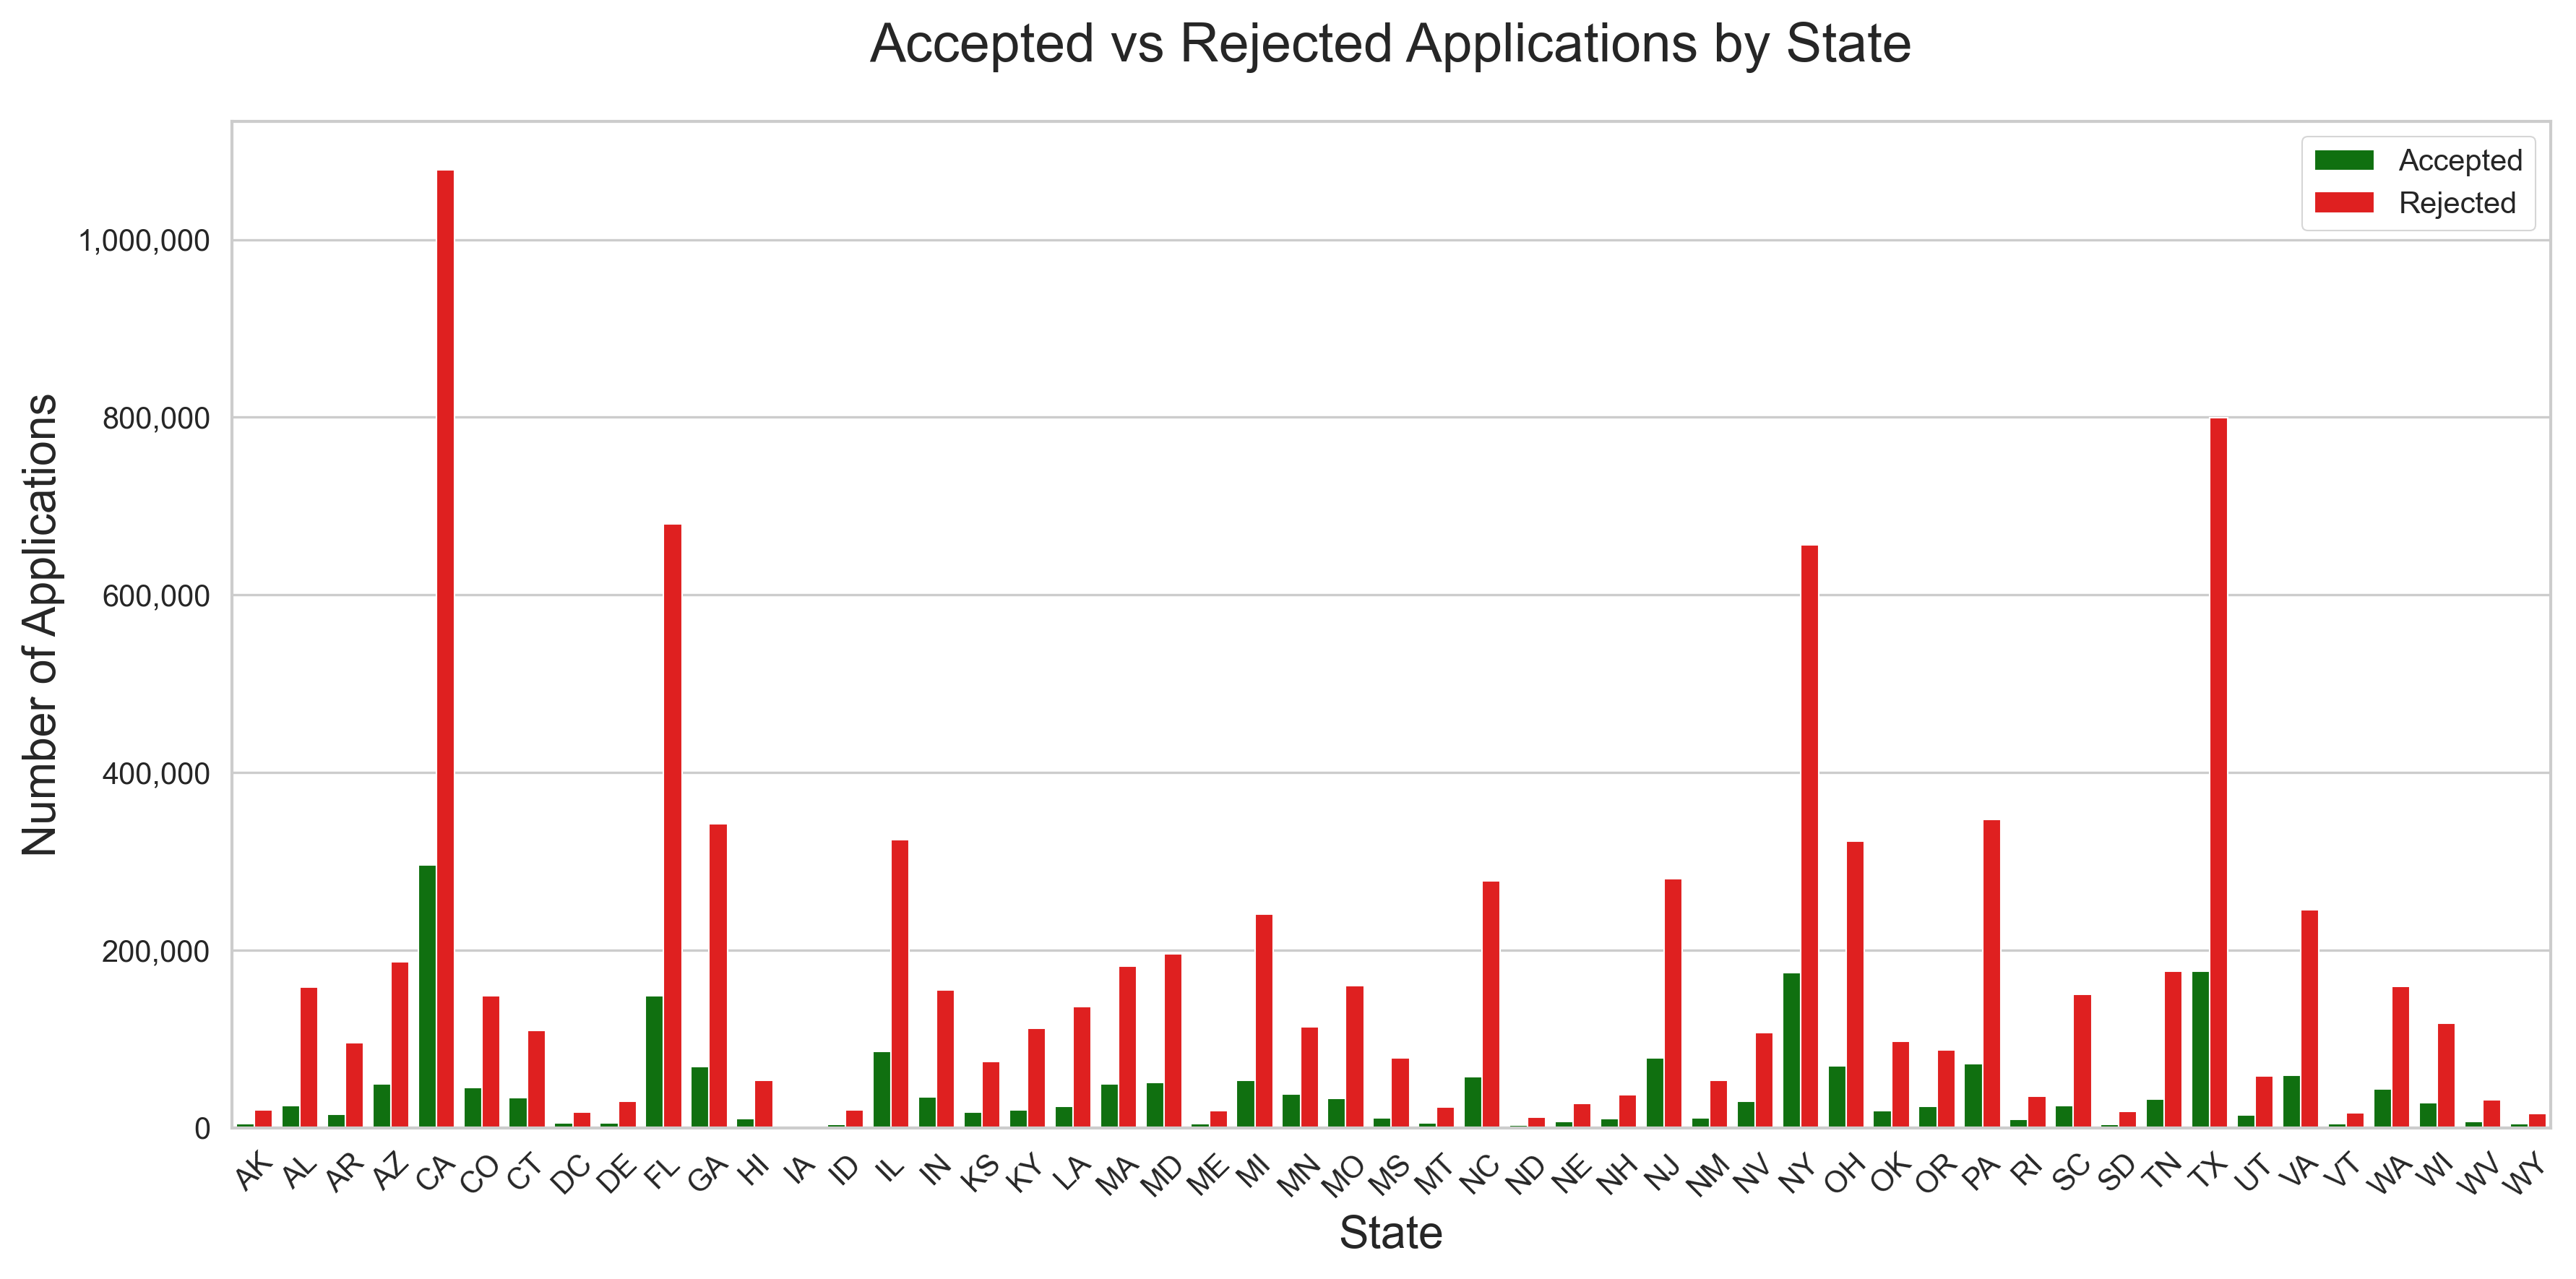

In [18]:
#Barplot- Applications Status Counts by State
col = 'State'

accepted_counts = (Accepted_Rejected.loc[Accepted_Rejected['Application'] == 'Accepted', col].value_counts().sort_index())
rejected_counts = (Accepted_Rejected.loc[Accepted_Rejected['Application'] == 'Rejected', col].value_counts().sort_index())

#Combine counts
col_vals = sorted(set(accepted_counts.index) | set(rejected_counts.index))
combined = pd.DataFrame({
    col: col_vals,
    'Accepted': accepted_counts.reindex(col_vals, fill_value=0).values,
    'Rejected': rejected_counts.reindex(col_vals, fill_value=0).values
})

#Convert for Seaborn
melted = combined.melt(
    id_vars=col,
    value_vars=['Accepted', 'Rejected'],
    var_name='Application_Status',
    value_name='Count'
)

sns.set_style('whitegrid')
plt.figure(figsize=(12, 6), dpi=300)

sns.barplot(
    data=melted,
    x=col,
    y='Count',
    hue='Application_Status',
    hue_order=['Accepted', 'Rejected'],
    palette=['green', 'red'],
)

plt.title(f'Accepted vs Rejected Applications by {col}', fontsize=18, pad=20)
plt.xlabel(col, fontsize=15)
plt.ylabel('Number of Applications', fontsize=15)
plt.xticks(rotation=45)
plt.legend(title='', loc='upper right')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

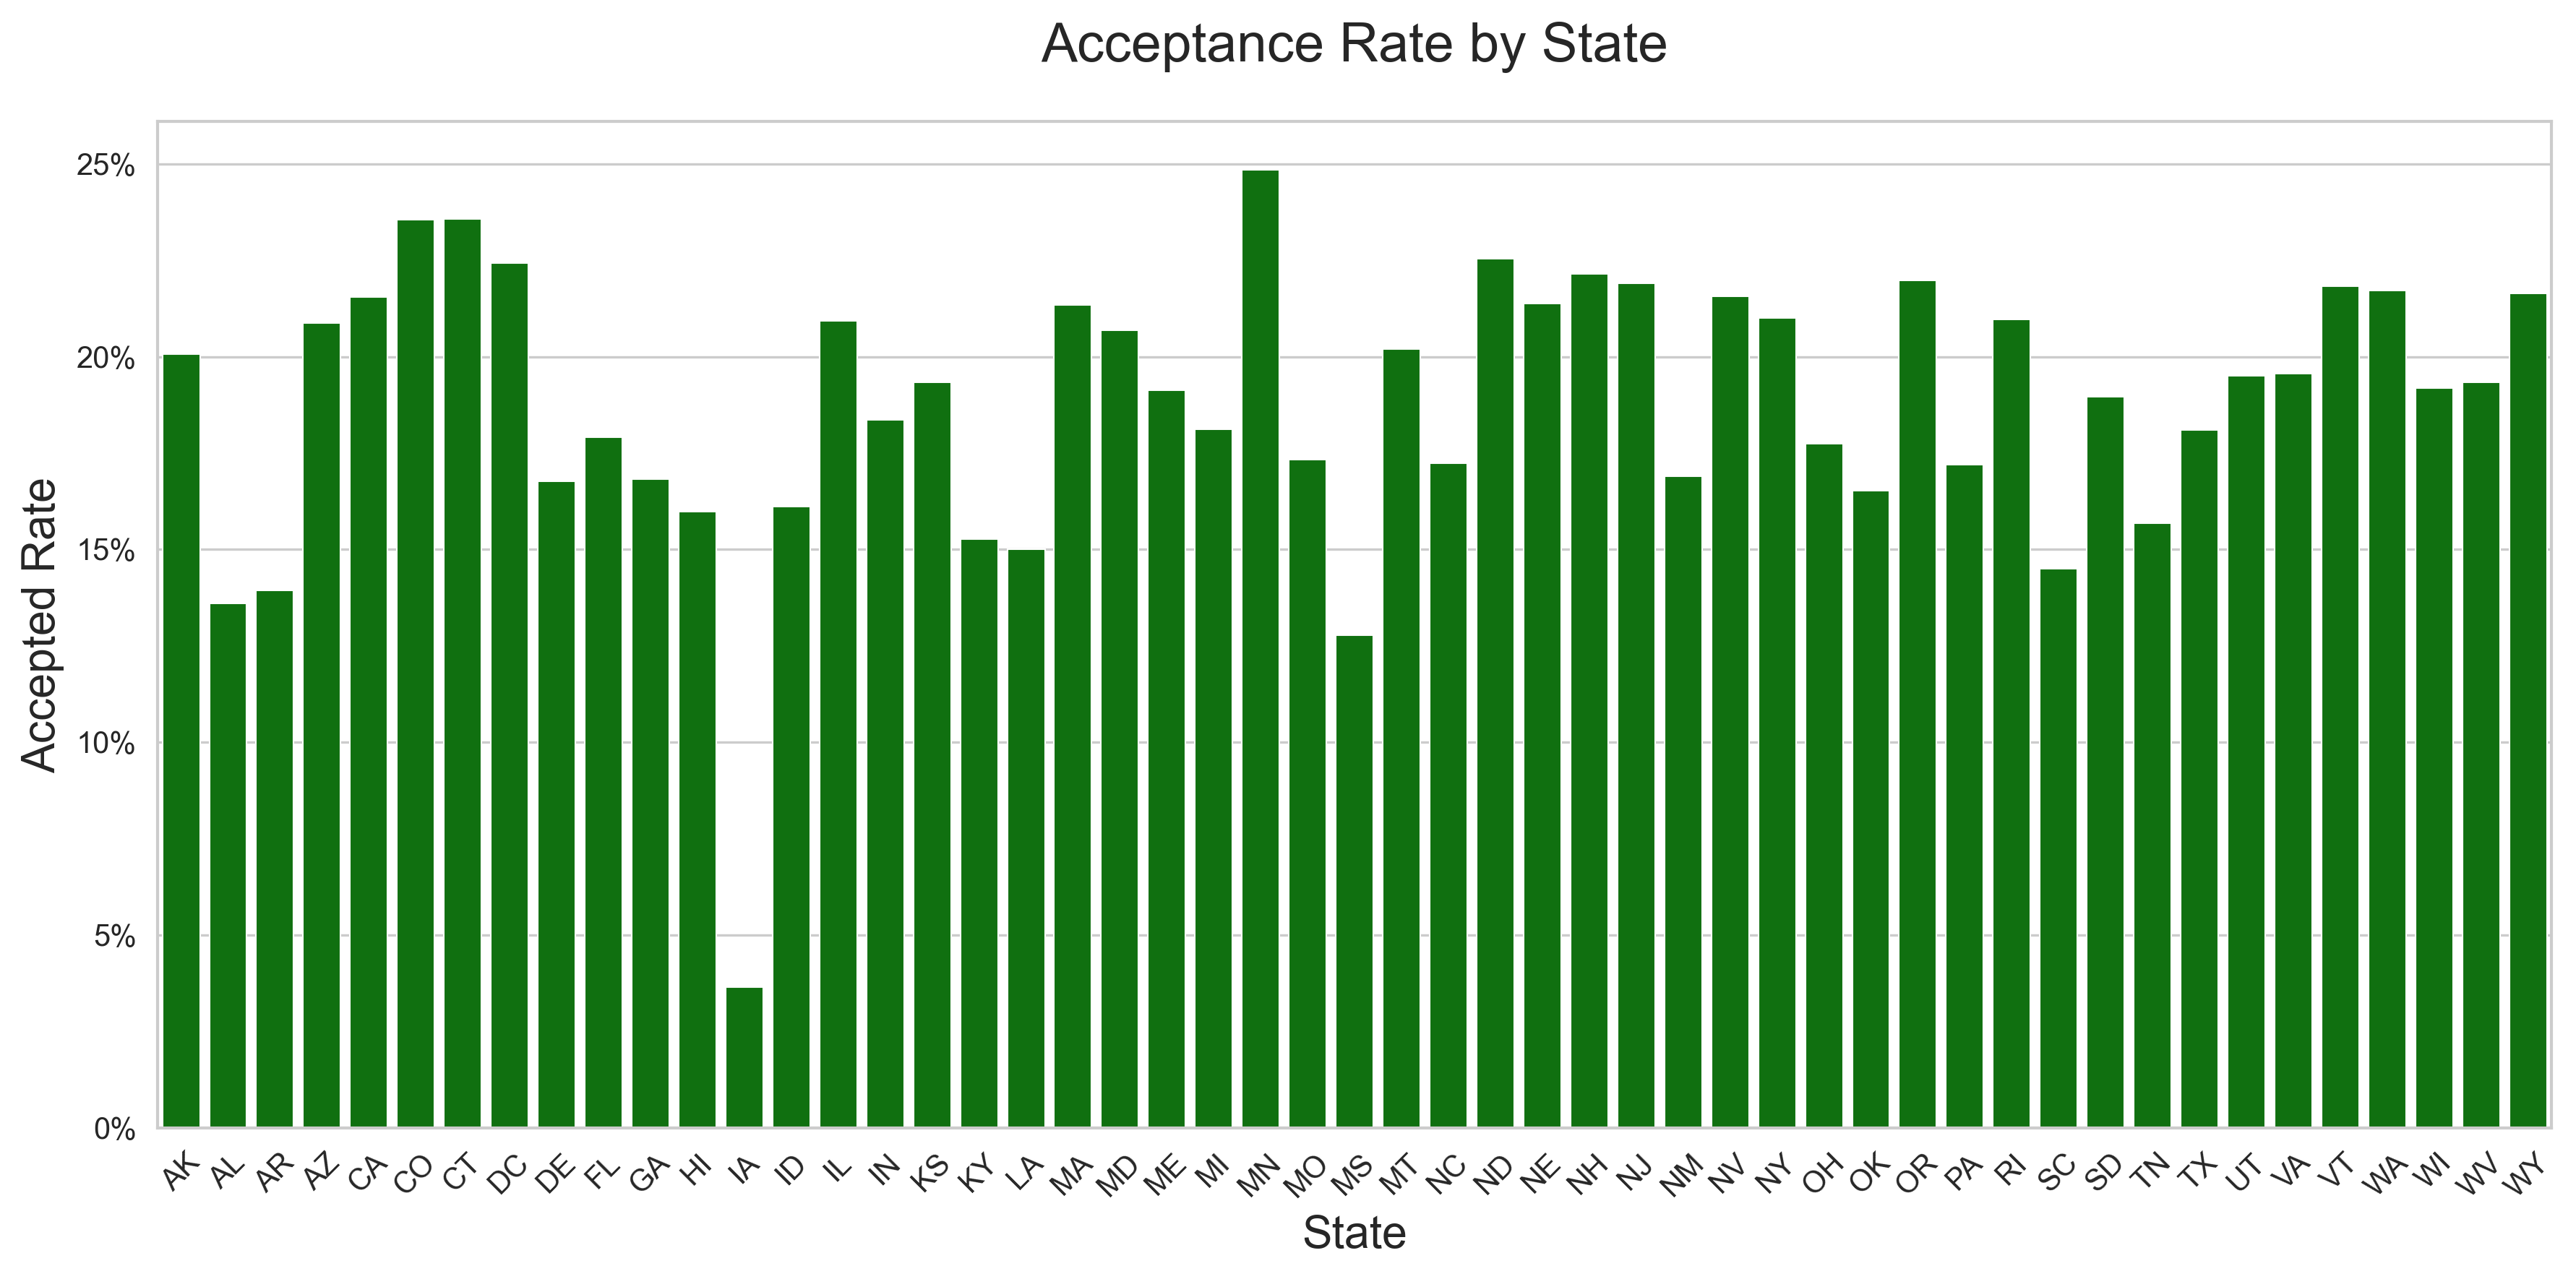

In [19]:
#Barplot- Applications ACCEPTANCE RATES by State
col = 'State'

accepted_counts = Accepted_Rejected.loc[Accepted_Rejected['Application'] == 'Accepted', col].value_counts().sort_index()
rejected_counts = Accepted_Rejected.loc[Accepted_Rejected['Application'] == 'Rejected', col].value_counts().sort_index()

#Combine
col_vals = sorted(set(accepted_counts.index) | set(rejected_counts.index))
combined = pd.DataFrame({
    col: col_vals,
    'Accepted': accepted_counts.reindex(col_vals, fill_value=0).values,
    'Rejected': rejected_counts.reindex(col_vals, fill_value=0).values
})

#Calculate accepted rate
combined['Accepted_Rate'] = combined['Accepted'] / (combined['Accepted'] + combined['Rejected'])

#Plot
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6), dpi=300)

sns.barplot(
    data=combined,
    x=col,
    y='Accepted_Rate',
    color='green'
)
plt.title(f'Acceptance Rate by {col}', fontsize=18, pad=20)
plt.xlabel(col, fontsize=15)
plt.ylabel('Accepted Rate', fontsize=15)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.tight_layout()
plt.show()

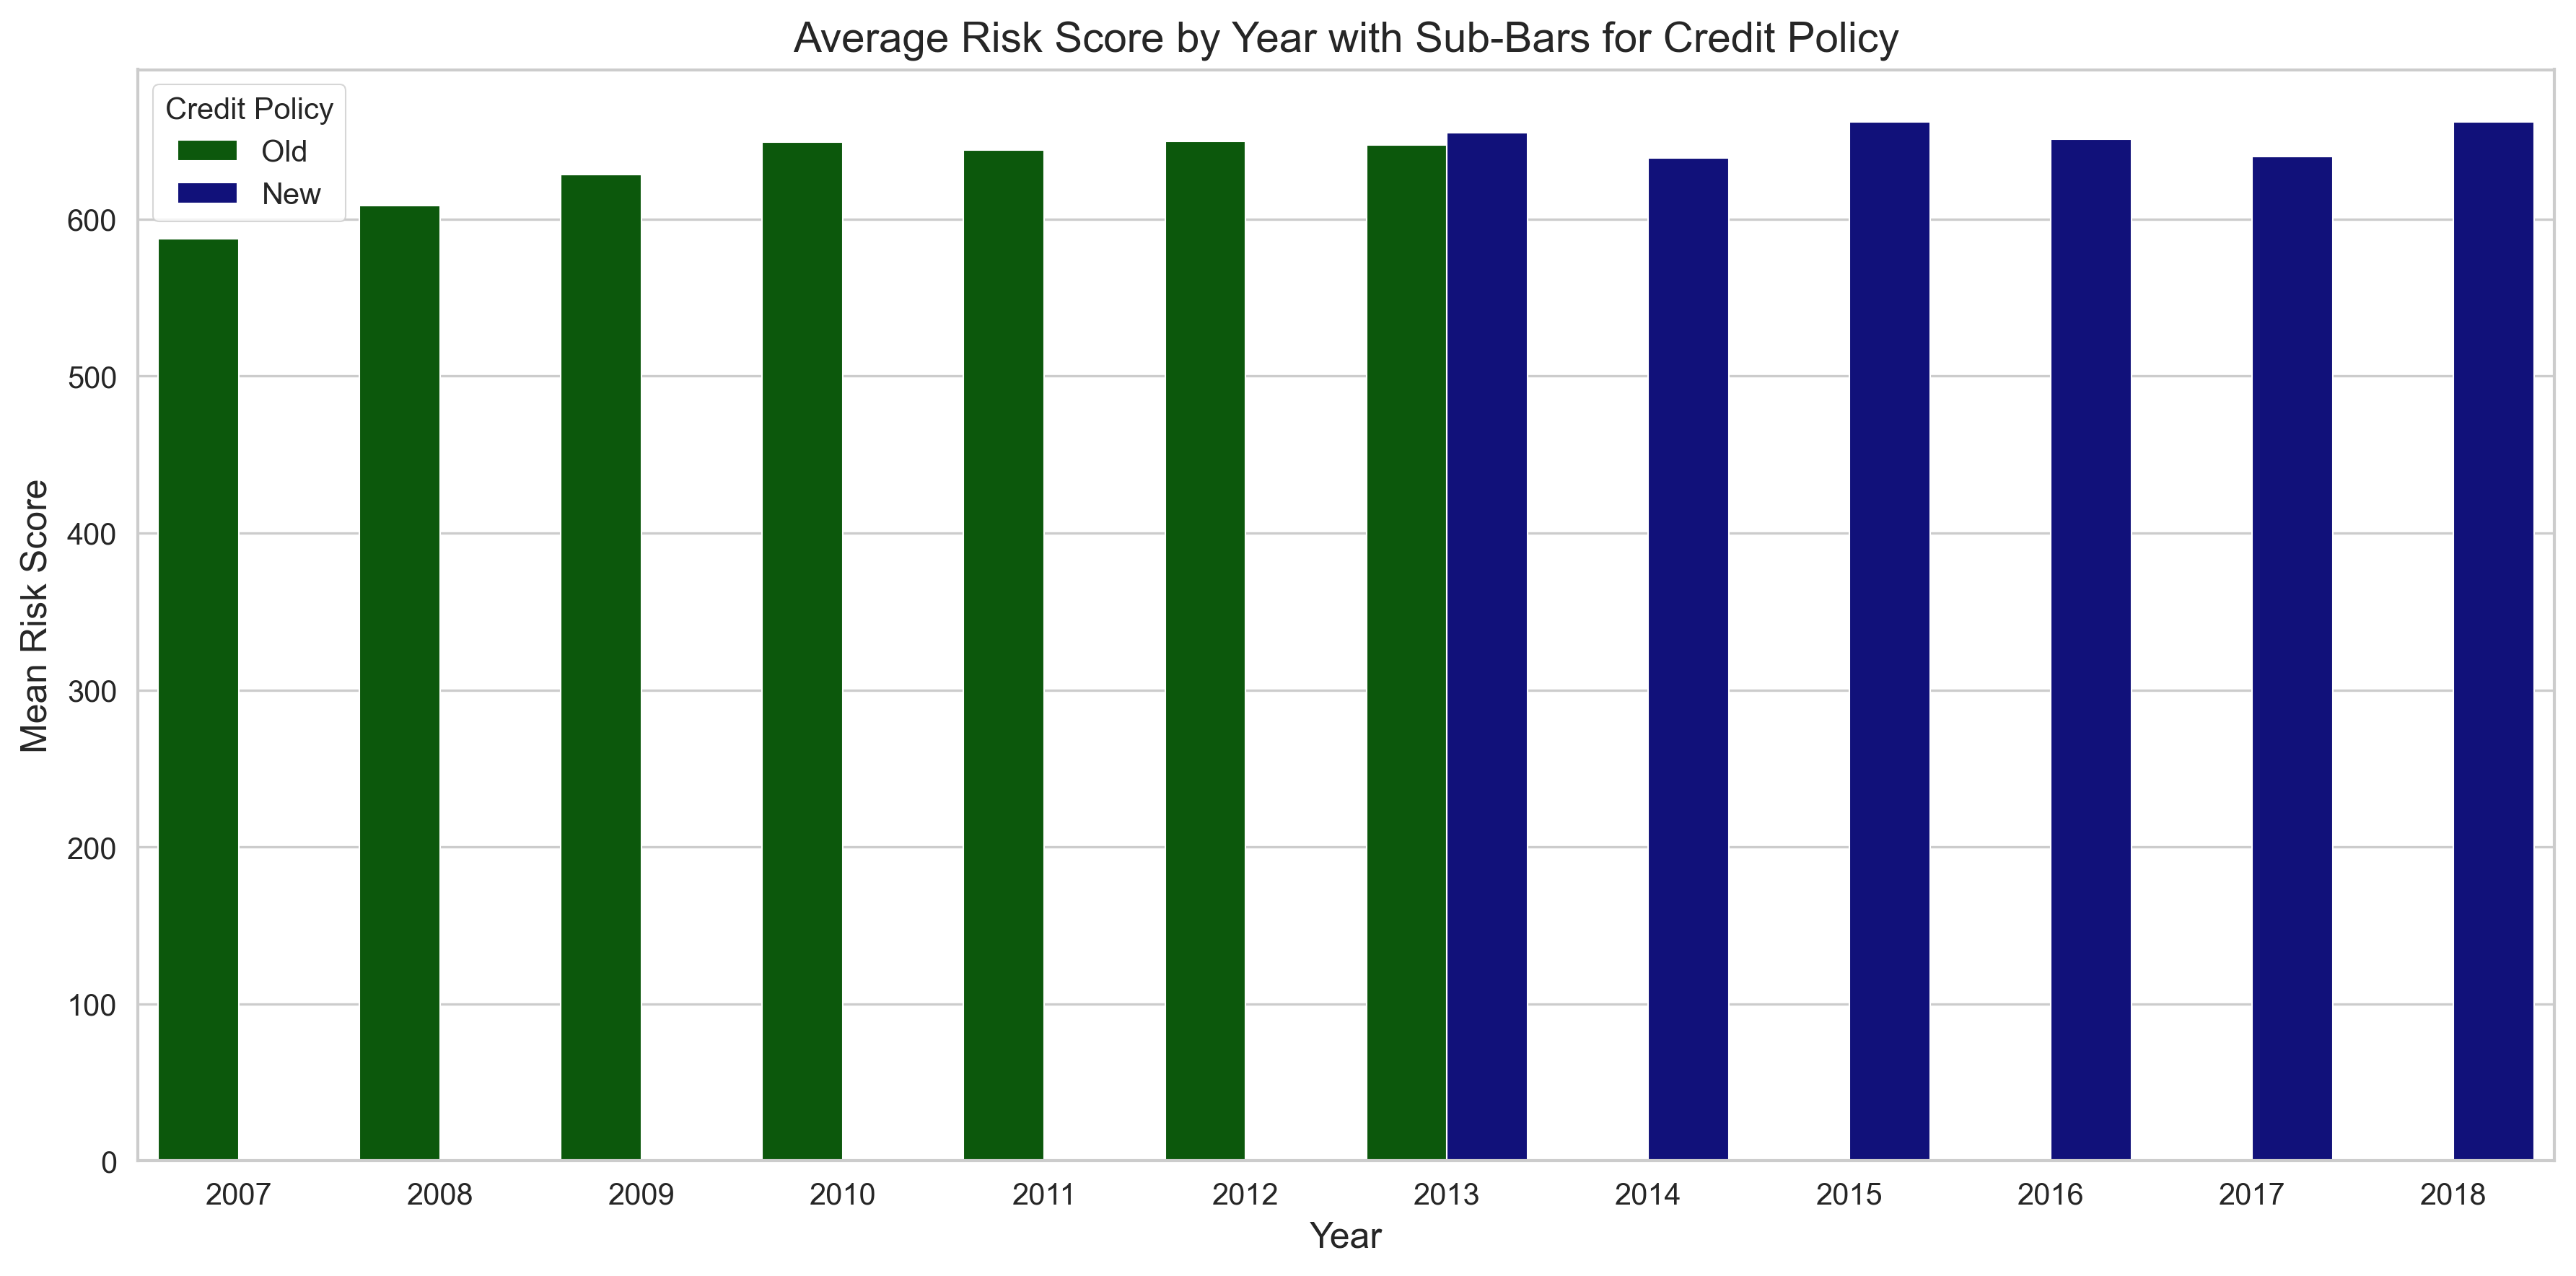

In [20]:
#Risk Scores over time (Old vs New Policy
Accepted_Rejected = Accepted_Rejected.copy()
grouped = (
	Accepted_Rejected.groupby(['Year', 'Credit_Policy'], observed=False)['Risk_Score']
	.mean()
	.reset_index()
)

sns.set_style('whitegrid')
plt.figure(figsize=(12, 6), dpi=300)

sns.barplot(
	data=grouped,
	x='Year',
	y='Risk_Score',
	hue='Credit_Policy',
	palette=['darkgreen', 'darkblue']
)

plt.title('Average Risk Score by Year with Sub-Bars for Credit Policy', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Risk Score', fontsize=12)
plt.legend(title='Credit Policy')
plt.tight_layout()
plt.show()

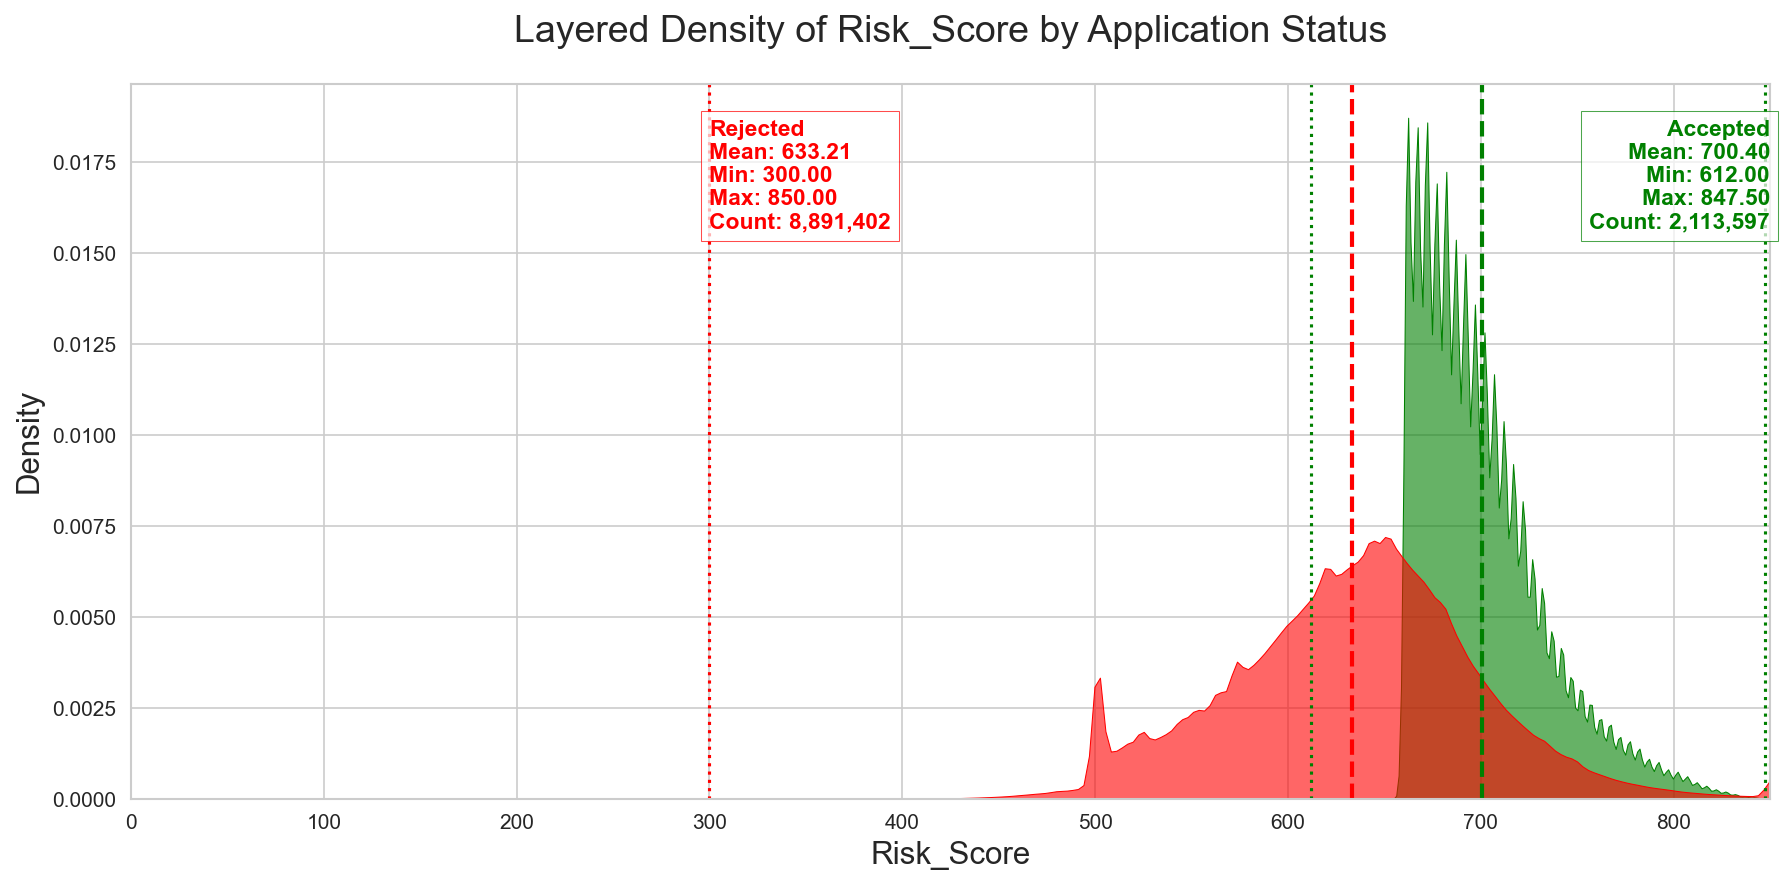

In [21]:
stacked_density_with_stats_boxes('Risk_Score', 850)

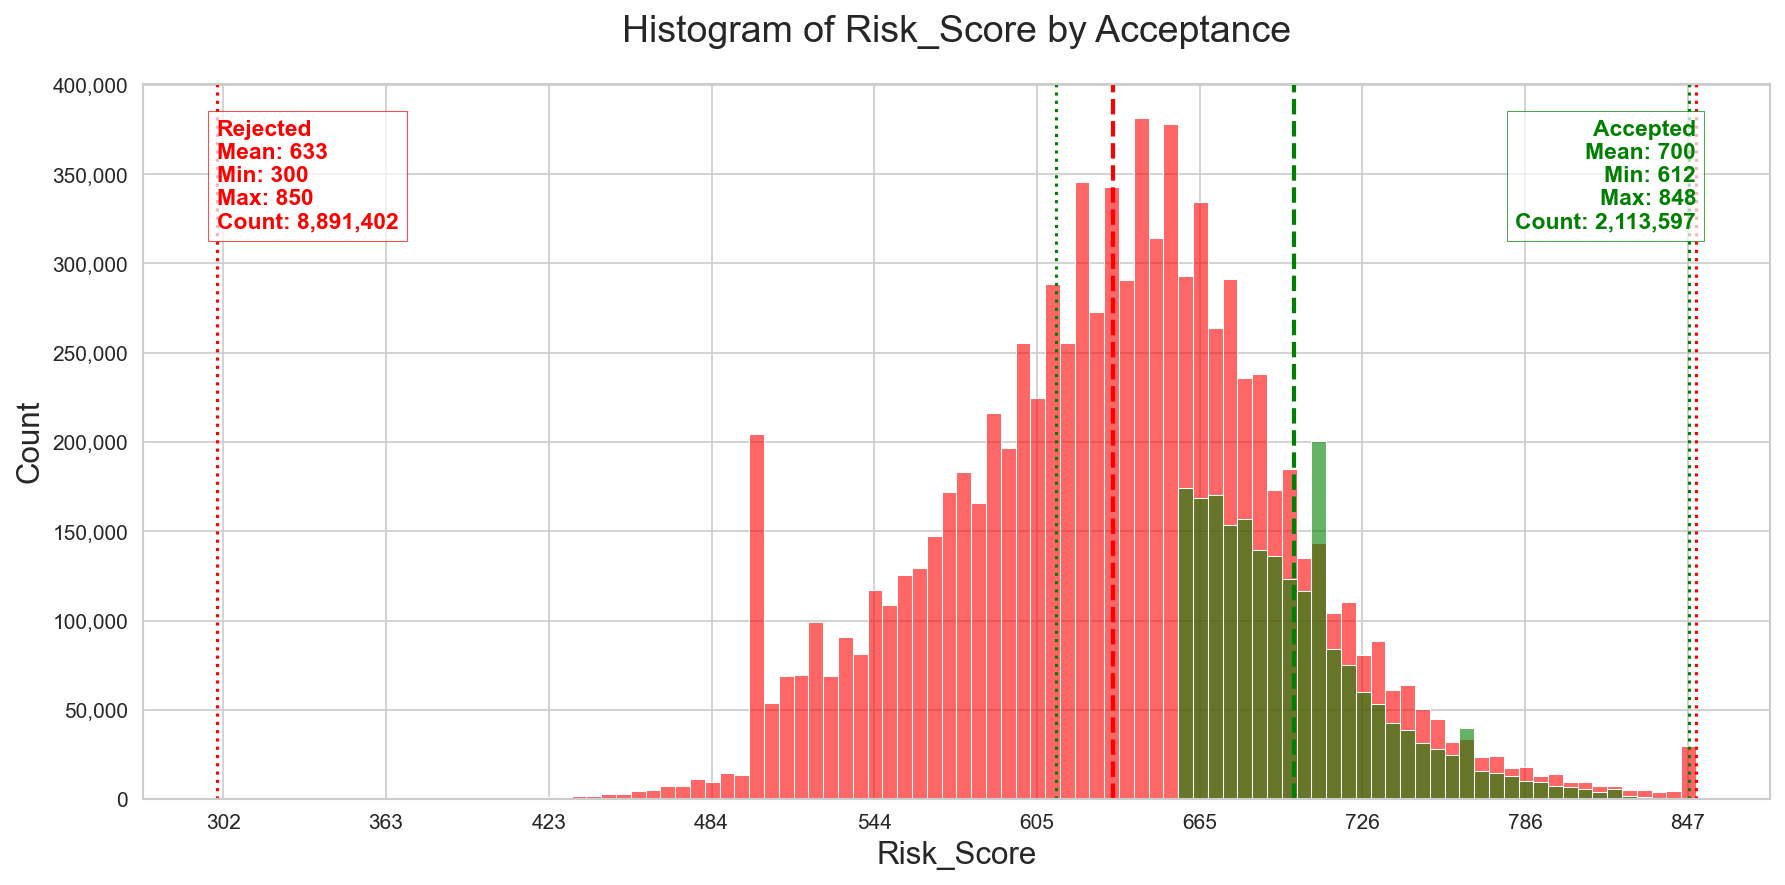

In [22]:
stacked_hist_acceptance('Risk_Score', bins=100)

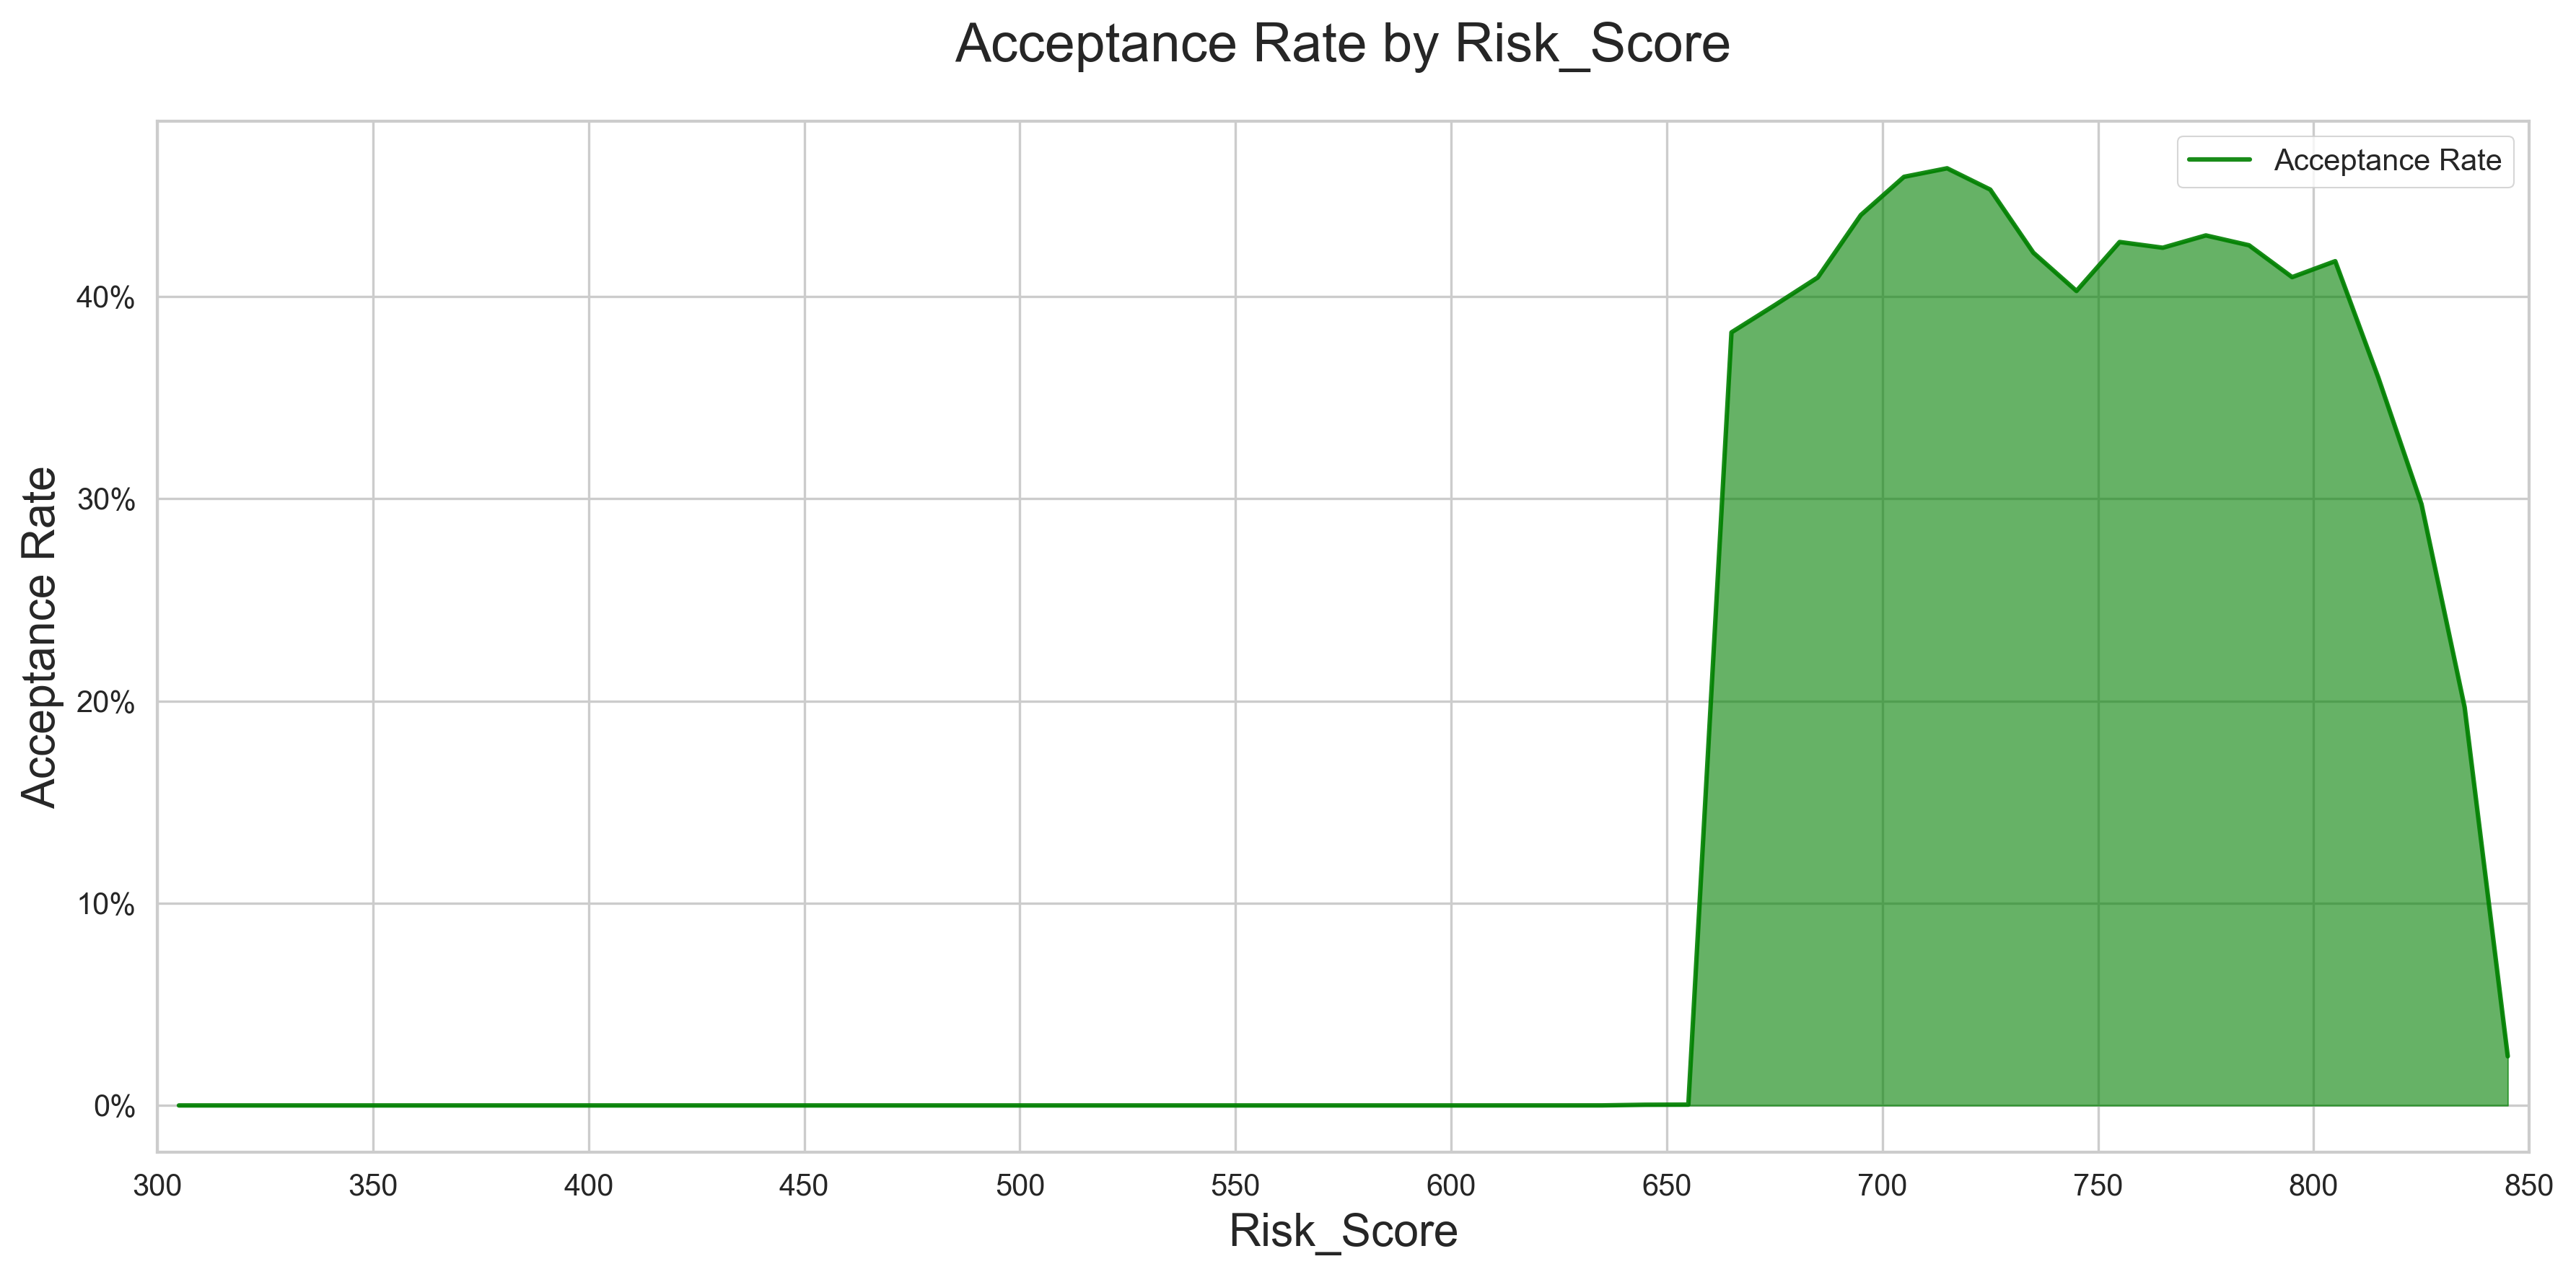

In [23]:
#Bin ACCEPTANCE RATE by Risk Score
col = 'Risk_Score'

bins = np.arange(300, 851, 10)
Accepted_Rejected['Bin'] = pd.cut(Accepted_Rejected[col], bins)

#Calculate acceptance rate per bin
rate_df = Accepted_Rejected.groupby('Bin', observed=False)['Application'].value_counts().unstack(fill_value=0)
rate_df['Acceptance_Rate'] = rate_df.get('Accepted', 0) / (rate_df.get('Accepted', 0) + rate_df.get('Rejected', 0))

#Use bin midpoints for plotting
bin_midpoints = [interval.mid for interval in rate_df.index]

sns.set_style('whitegrid')
plt.figure(figsize=(12, 6), dpi=300)

plt.fill_between(bin_midpoints, rate_df['Acceptance_Rate'], color='green', alpha=0.6)
plt.plot(bin_midpoints, rate_df['Acceptance_Rate'], color='green', alpha=0.9, label='Acceptance Rate')

plt.title(f'Acceptance Rate by {col}', fontsize=18, pad=20)
plt.xlabel(col, fontsize=15)
plt.ylabel('Acceptance Rate', fontsize=15)
plt.xlim(300, 850)
plt.gca().xaxis.set_major_locator(MultipleLocator(50))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y*100)}%'))
plt.legend(title='')
plt.tight_layout()
plt.show()

C:\Users\edjwe\AppData\Local\Temp\ipykernel_15708\1279593790.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=Accepted_Rejected_trimmed[Accepted_Rejected['Application'] == 'Accepted'],
C:\Users\edjwe\AppData\Local\Temp\ipykernel_15708\1279593790.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=Accepted_Rejected_trimmed[Accepted_Rejected['Application'] == 'Rejected'],


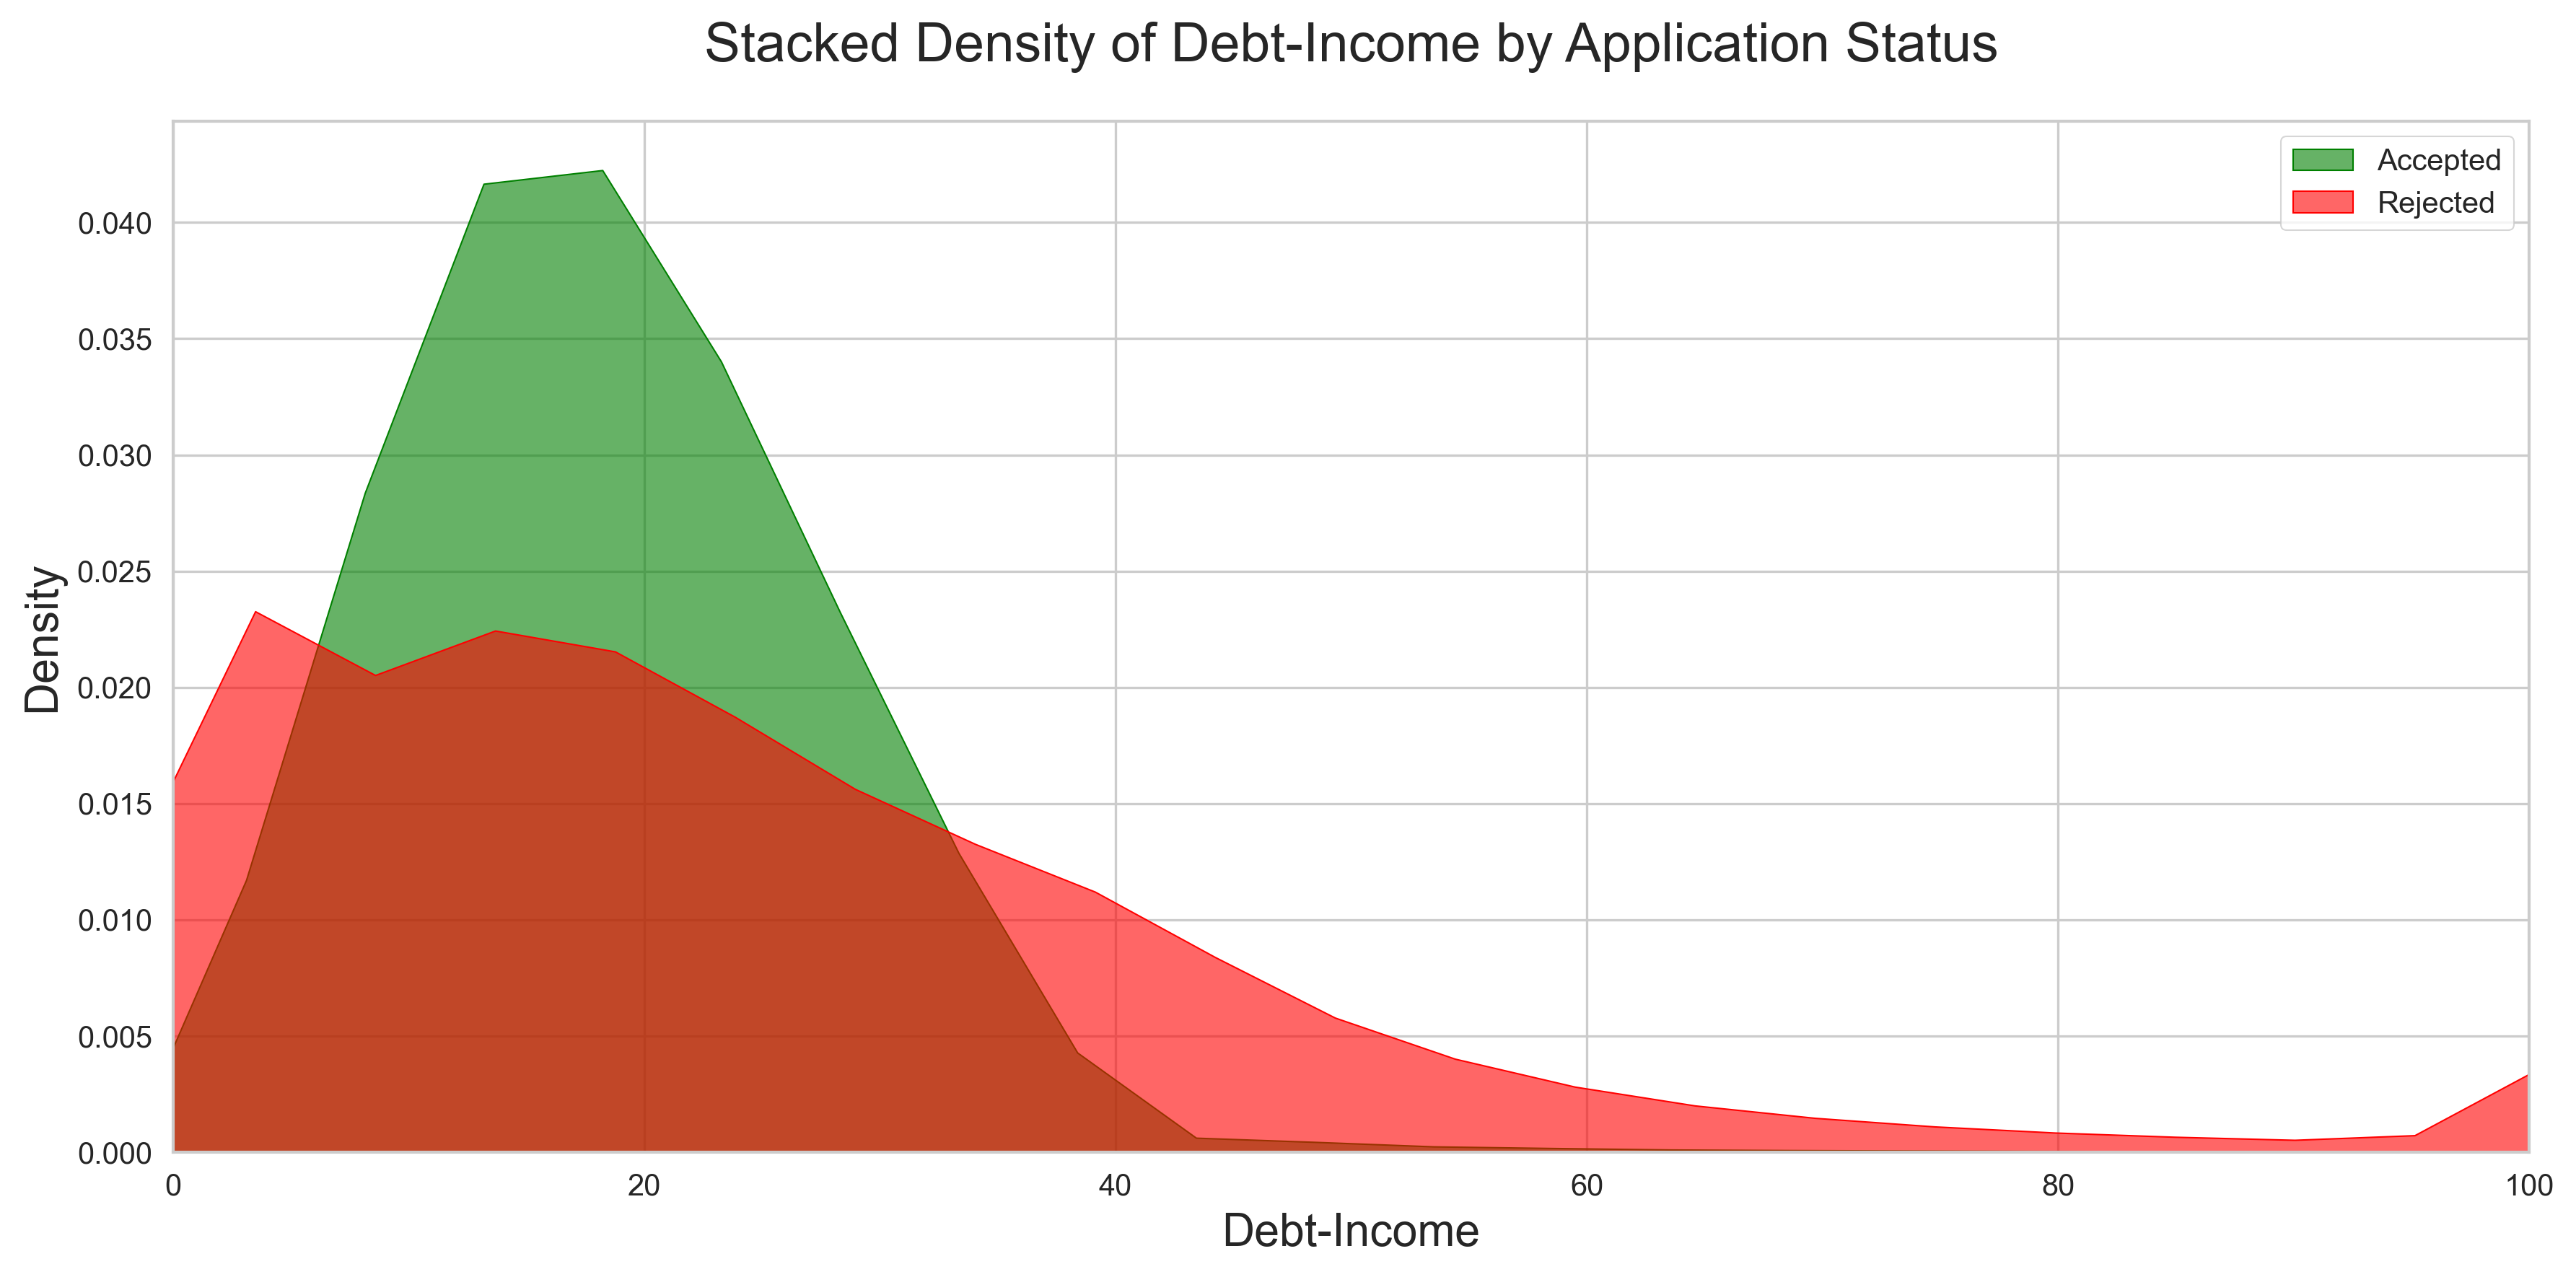

In [24]:
#Stacked Density- Accepted vs Rejected by Debt-Income
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6), dpi=300)

Accepted_Rejected_trimmed = Accepted_Rejected[Accepted_Rejected['Debt-Income'] < 1000]
sns.kdeplot(
    data=Accepted_Rejected_trimmed[Accepted_Rejected['Application'] == 'Accepted'],
    x='Debt-Income',
    fill=True,
    label='Accepted',
    color='green',
    alpha=0.6
)
sns.kdeplot(
    data=Accepted_Rejected_trimmed[Accepted_Rejected['Application'] == 'Rejected'],
    x='Debt-Income',
    fill=True,
    label='Rejected',
    color='red',
    alpha=0.6
)

plt.title('Stacked Density of Debt-Income by Application Status', fontsize=18, pad=20)
plt.xlabel('Debt-Income', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(title='')
plt.xlim(0, 100)
#plt.gca().xaxis.set_major_locator(MultipleLocator(50))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

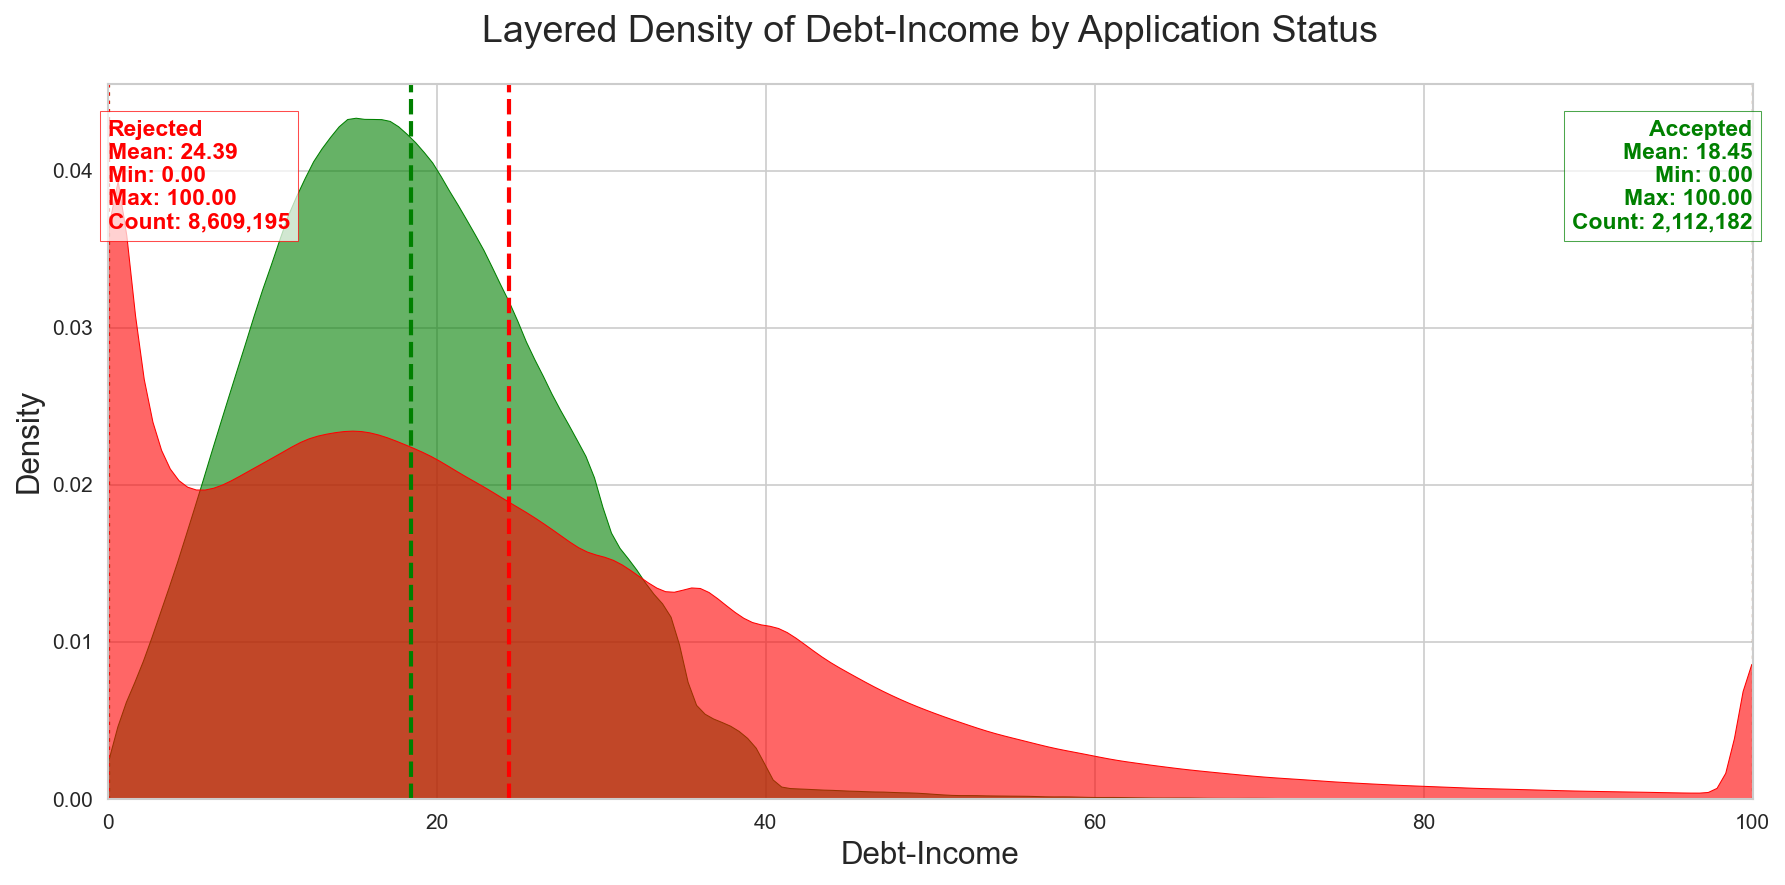

In [25]:
stacked_density_with_stats_boxes('Debt-Income', 100)

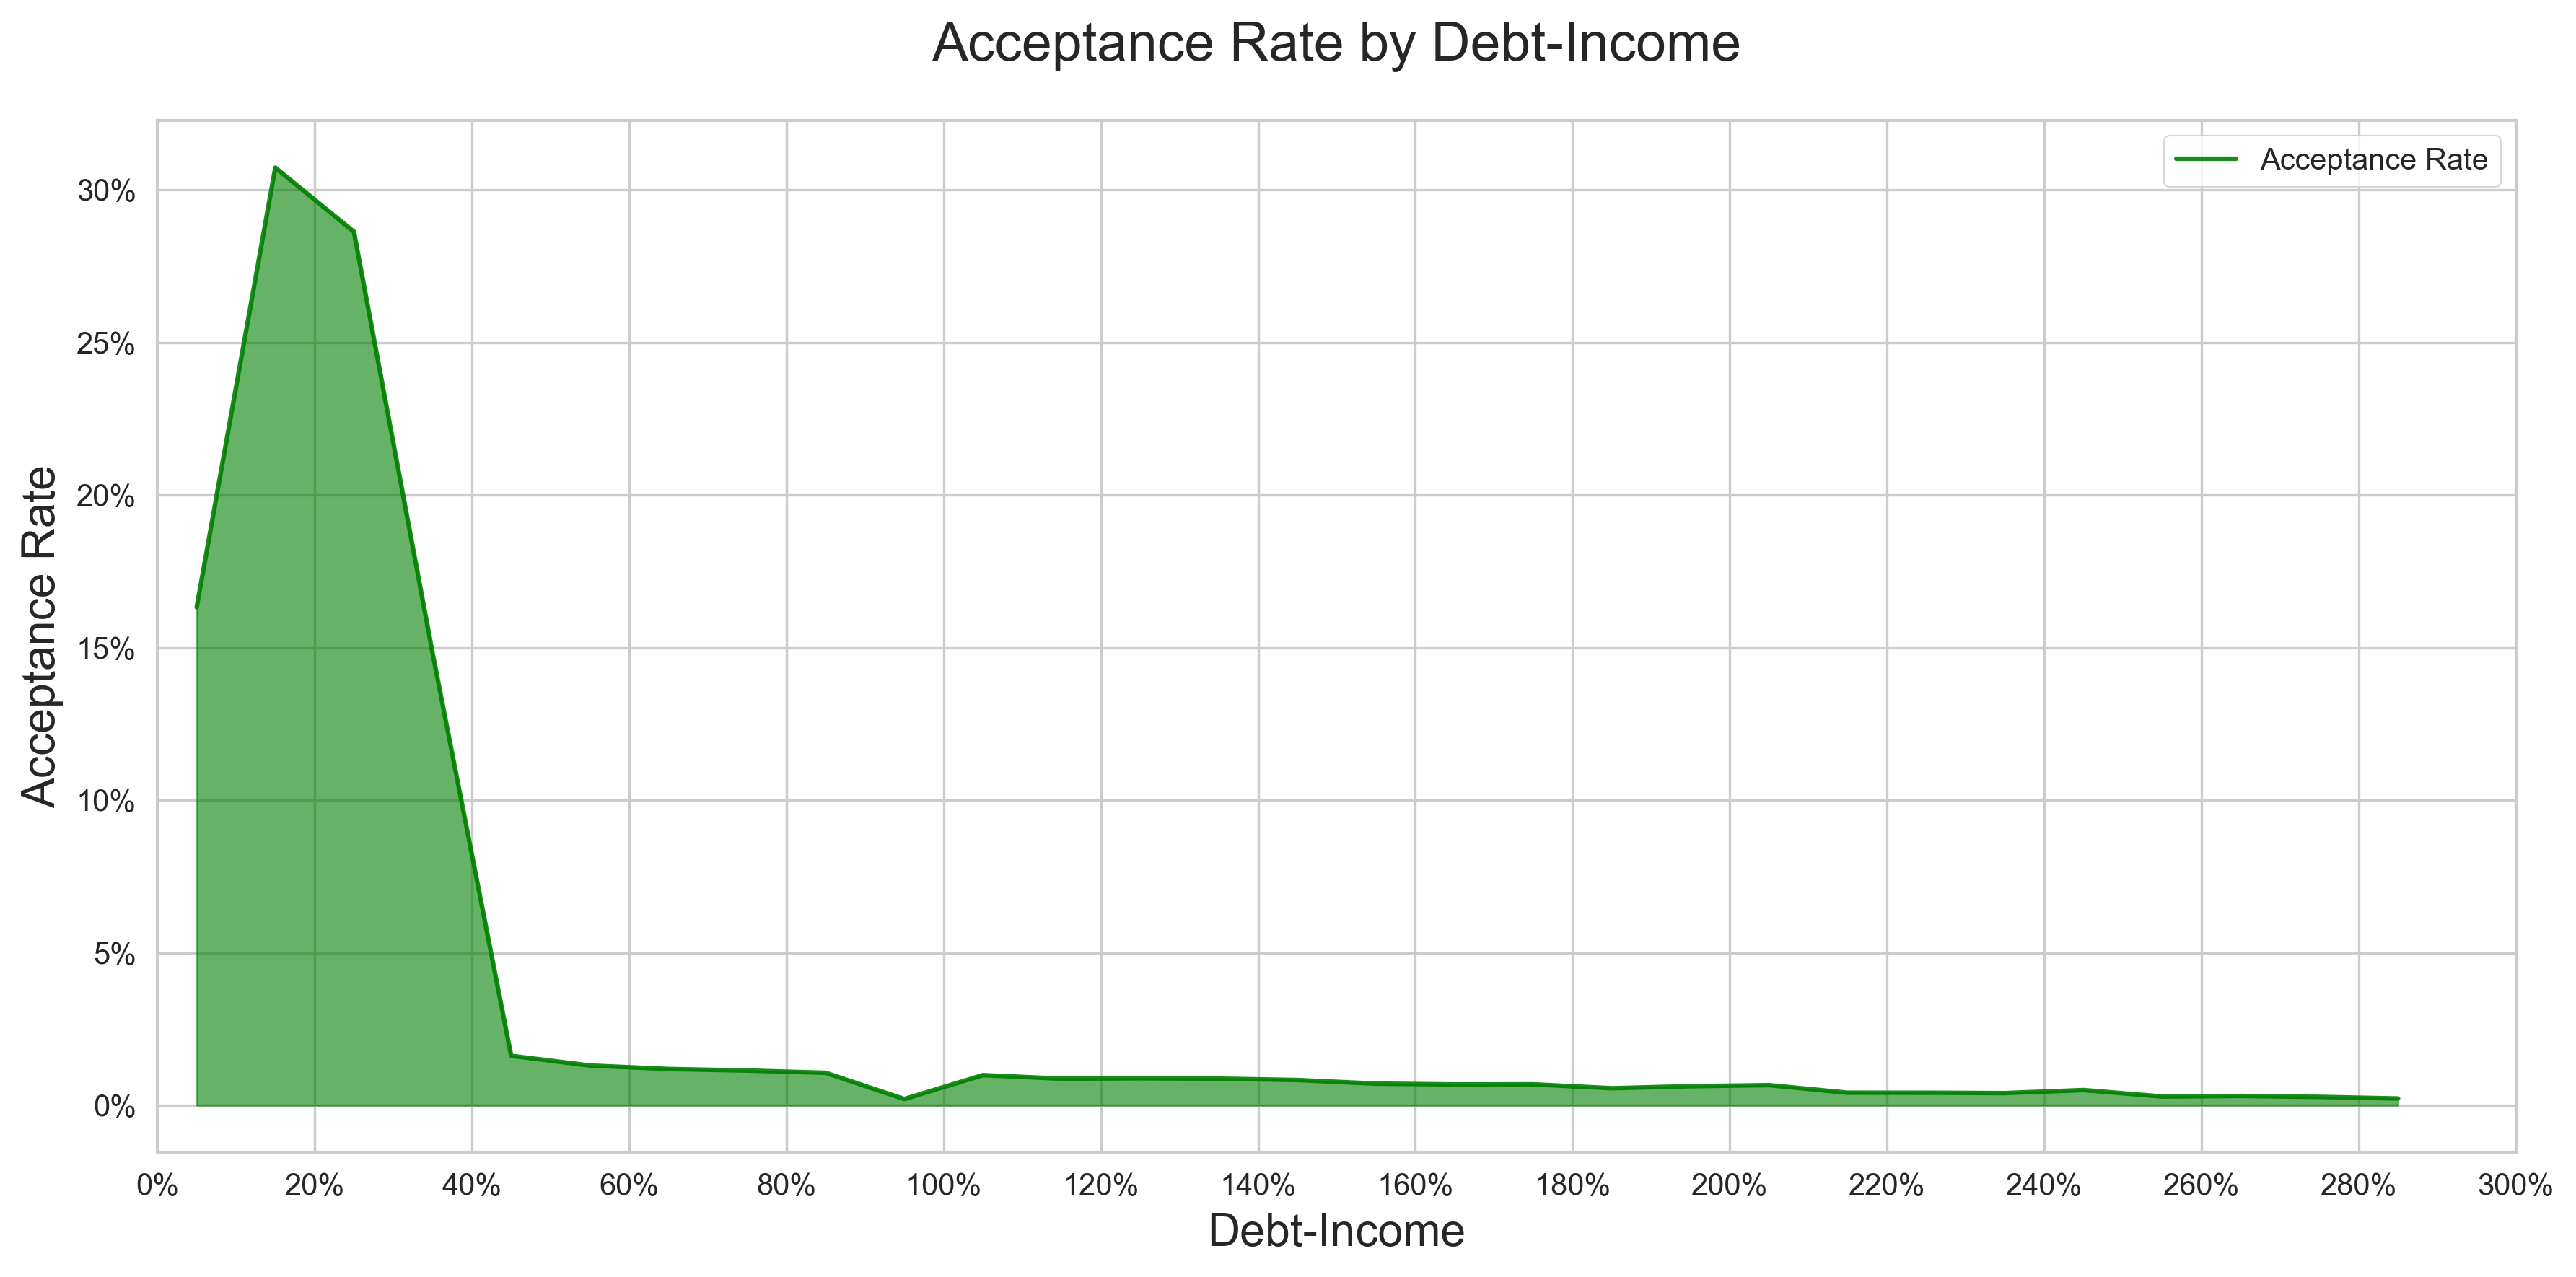

In [26]:
#Bin ACCEPTANCE RATE by Risk Score
col = 'Debt-Income'

bins = np.arange(0, 300, 10)
Accepted_Rejected['Bin'] = pd.cut(Accepted_Rejected[col], bins)

#Calculate acceptance rate per bin
rate_df = Accepted_Rejected.groupby('Bin', observed=False)['Application'].value_counts().unstack(fill_value=0)
rate_df['Acceptance_Rate'] = rate_df.get('Accepted', 0) / (rate_df.get('Accepted', 0) + rate_df.get('Rejected', 0))

#Use bin midpoints for plotting
bin_midpoints = [interval.mid for interval in rate_df.index]

sns.set_style('whitegrid')
plt.figure(figsize=(12, 6), dpi=300)

plt.fill_between(bin_midpoints, rate_df['Acceptance_Rate'], color='green', alpha=0.6)
plt.plot(bin_midpoints, rate_df['Acceptance_Rate'], color='green', alpha=0.9, label='Acceptance Rate')

plt.title(f'Acceptance Rate by {col}', fontsize=18, pad=20)
plt.xlabel(col, fontsize=15)
plt.ylabel('Acceptance Rate', fontsize=15)
plt.xlim(0, 300)
plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y*100)}%'))
plt.legend(title='')
plt.tight_layout()
plt.show()

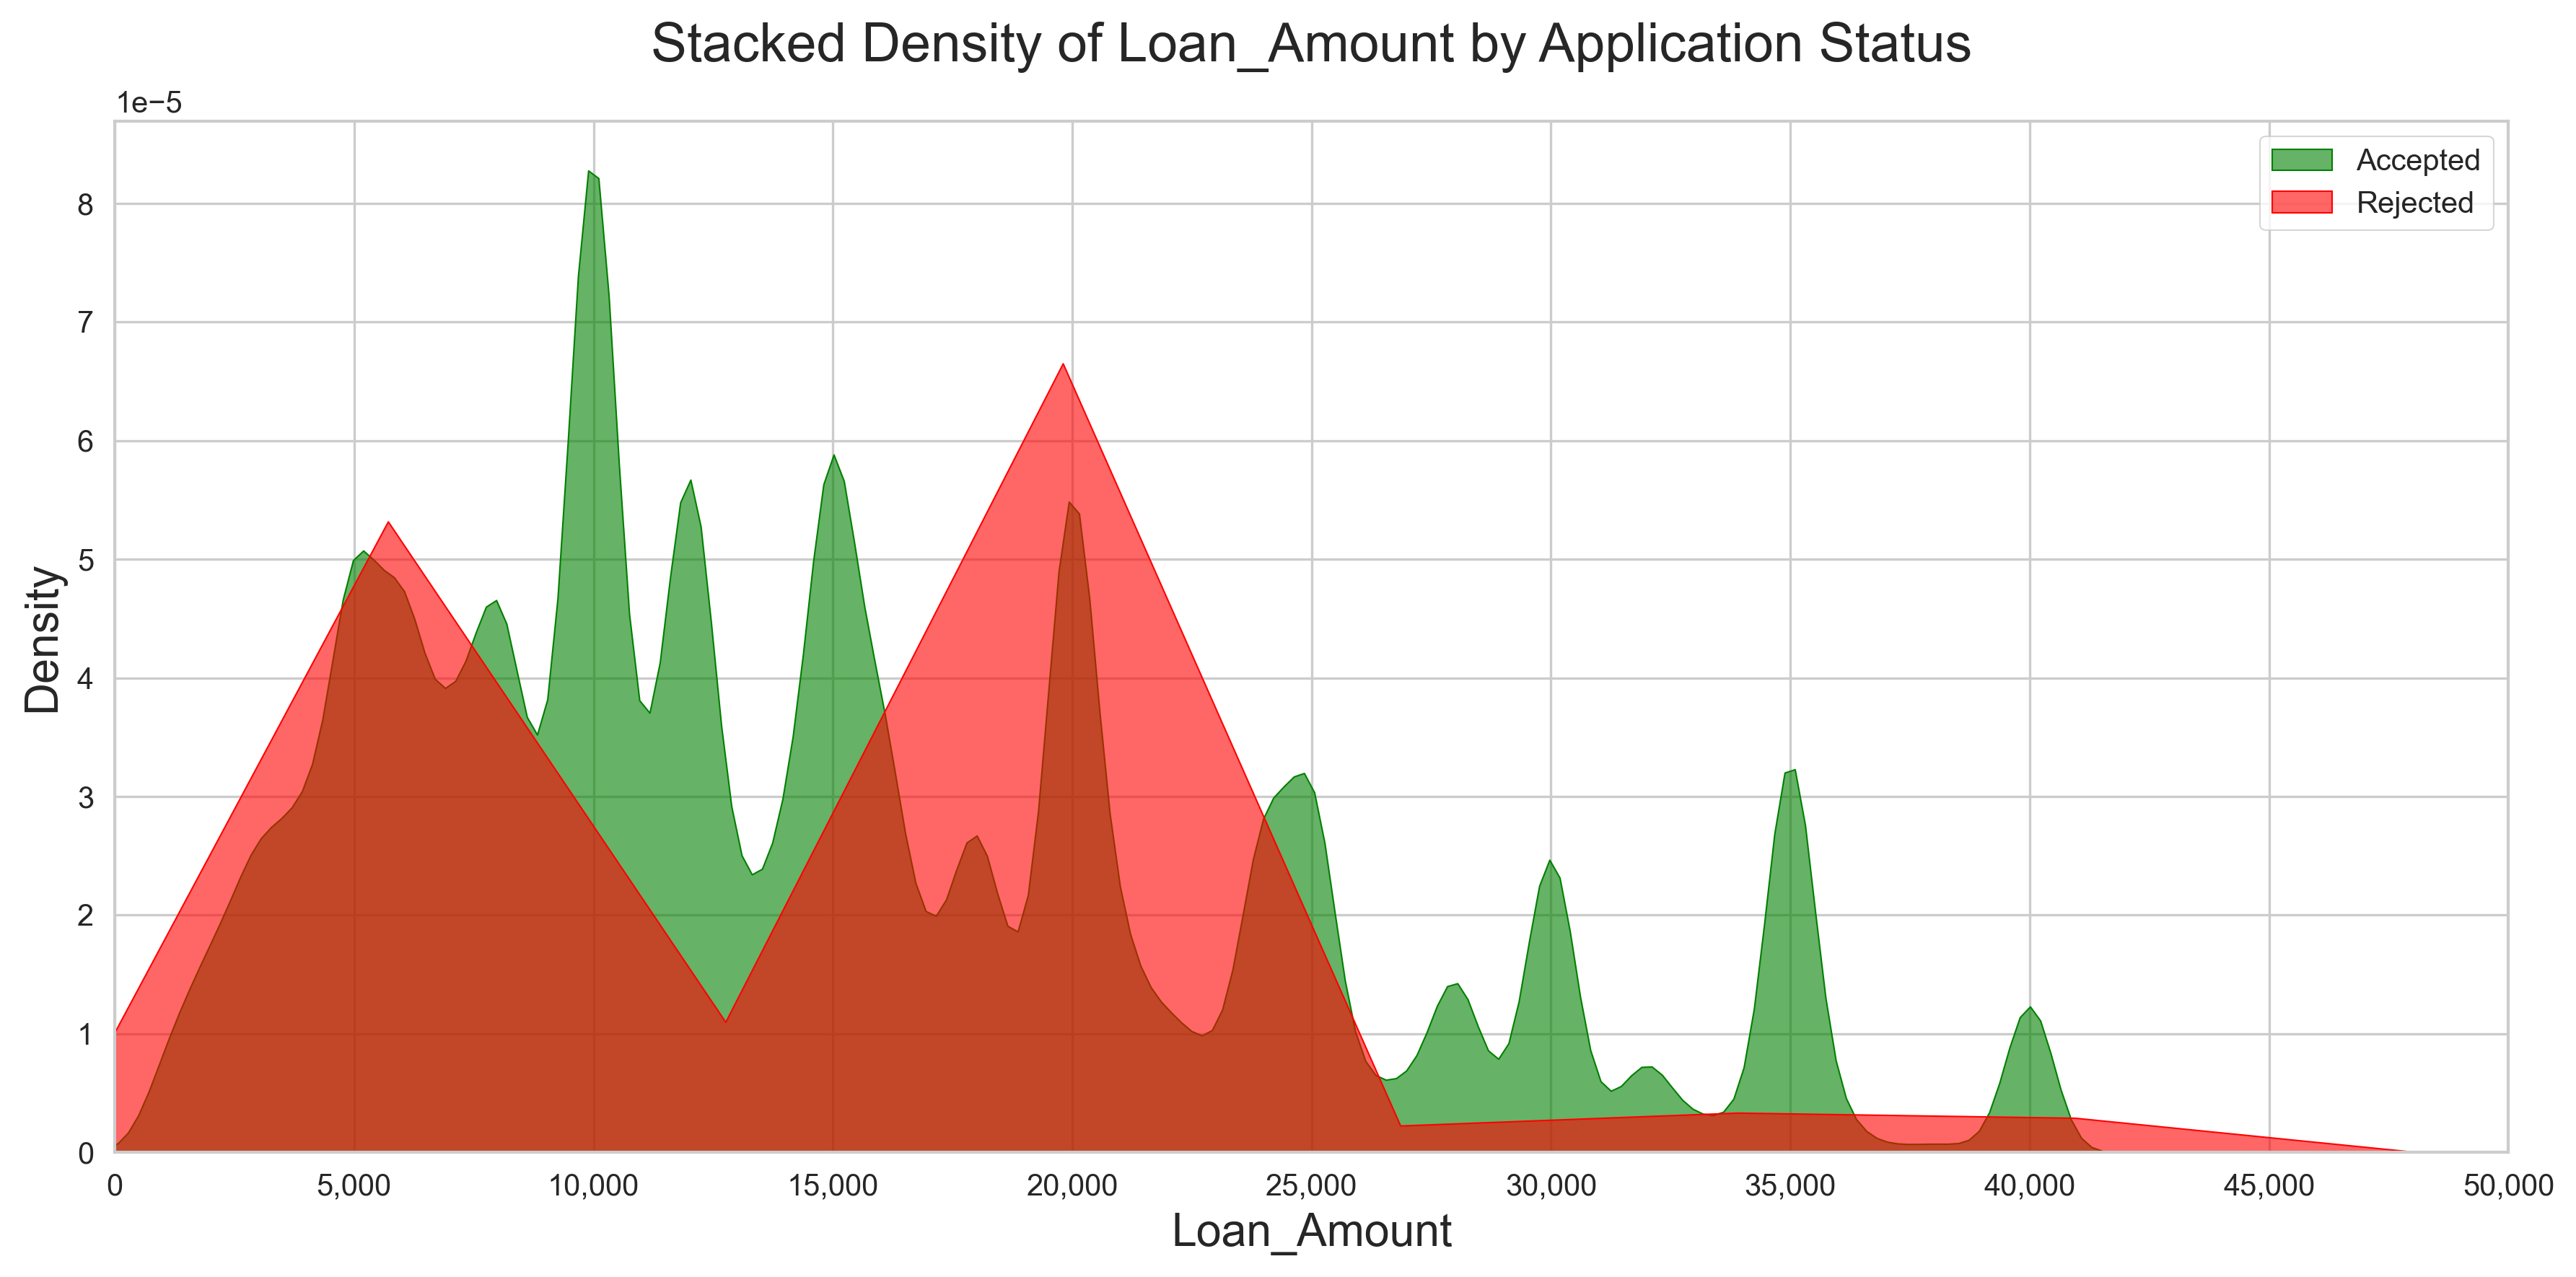

In [27]:
#Stacked Density- Accepted vs Rejected by Loan Amount
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6), dpi=300)

sns.kdeplot(
    data=Accepted_Rejected[Accepted_Rejected['Application'] == 'Accepted'],
    x='Loan_Amount',
    fill=True,
    label='Accepted',
    color='green',
    alpha=0.6
)
sns.kdeplot(
    data=Accepted_Rejected[Accepted_Rejected['Application'] == 'Rejected'],
    x='Loan_Amount',
    fill=True,
    label='Rejected',
    color='red',
    alpha=0.6
)

plt.title('Stacked Density of Loan_Amount by Application Status', fontsize=18, pad=20)
plt.xlabel('Loan_Amount', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(title='')
plt.xlim(0, 50000)
plt.gca().xaxis.set_major_locator(MultipleLocator(5000))
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

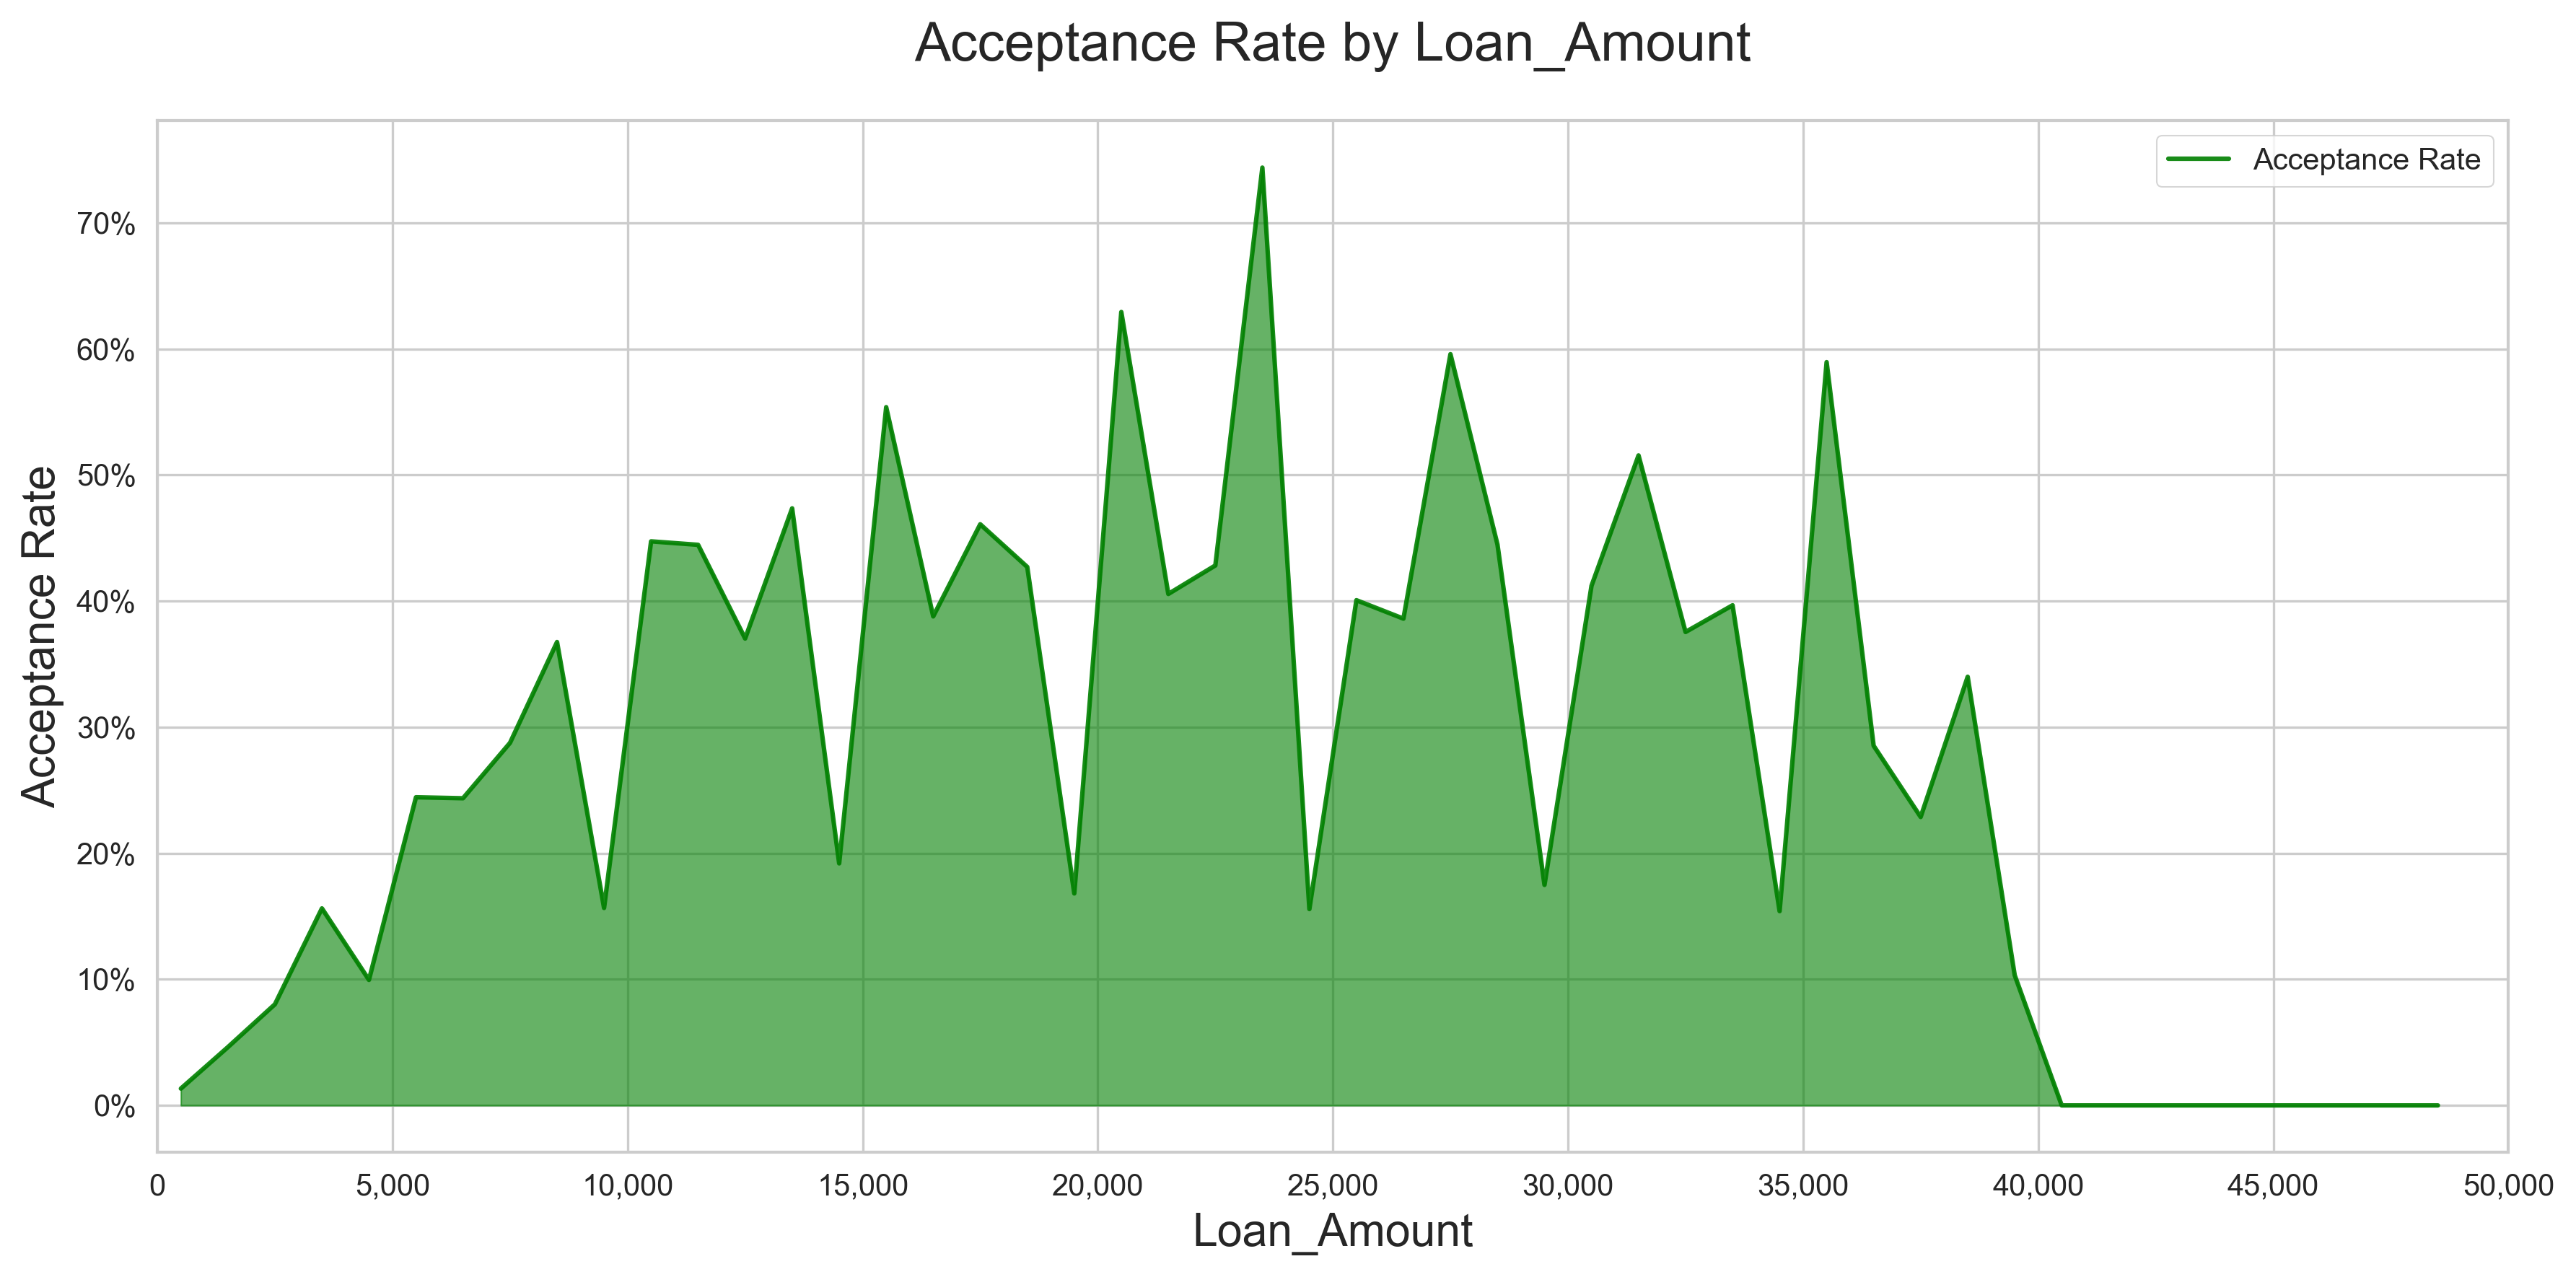

In [28]:
#Bin ACCEPTANCE RATE by Loan Amount
col = 'Loan_Amount'

bins = np.arange(0, 50000, 1000)
Accepted_Rejected['Bin'] = pd.cut(Accepted_Rejected[col], bins)

#Calculate acceptance rate per bin
rate_df = Accepted_Rejected.groupby('Bin', observed=False)['Application'].value_counts().unstack(fill_value=0)
rate_df['Acceptance_Rate'] = rate_df.get('Accepted', 0) / (rate_df.get('Accepted', 0) + rate_df.get('Rejected', 0))

#Use bin midpoints for plotting
bin_midpoints = [interval.mid for interval in rate_df.index]

sns.set_style('whitegrid')
plt.figure(figsize=(12, 6), dpi=300)

plt.fill_between(bin_midpoints, rate_df['Acceptance_Rate'], color='green', alpha=0.6)
plt.plot(bin_midpoints, rate_df['Acceptance_Rate'], color='green', alpha=0.9, label='Acceptance Rate')

plt.title(f'Acceptance Rate by {col}', fontsize=18, pad=20)
plt.xlabel(col, fontsize=15)
plt.ylabel('Acceptance Rate', fontsize=15)
plt.xlim(0, 50000)
plt.gca().xaxis.set_major_locator(MultipleLocator(5000))
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y*100)}%'))
plt.legend(title='')
plt.tight_layout()
plt.show()

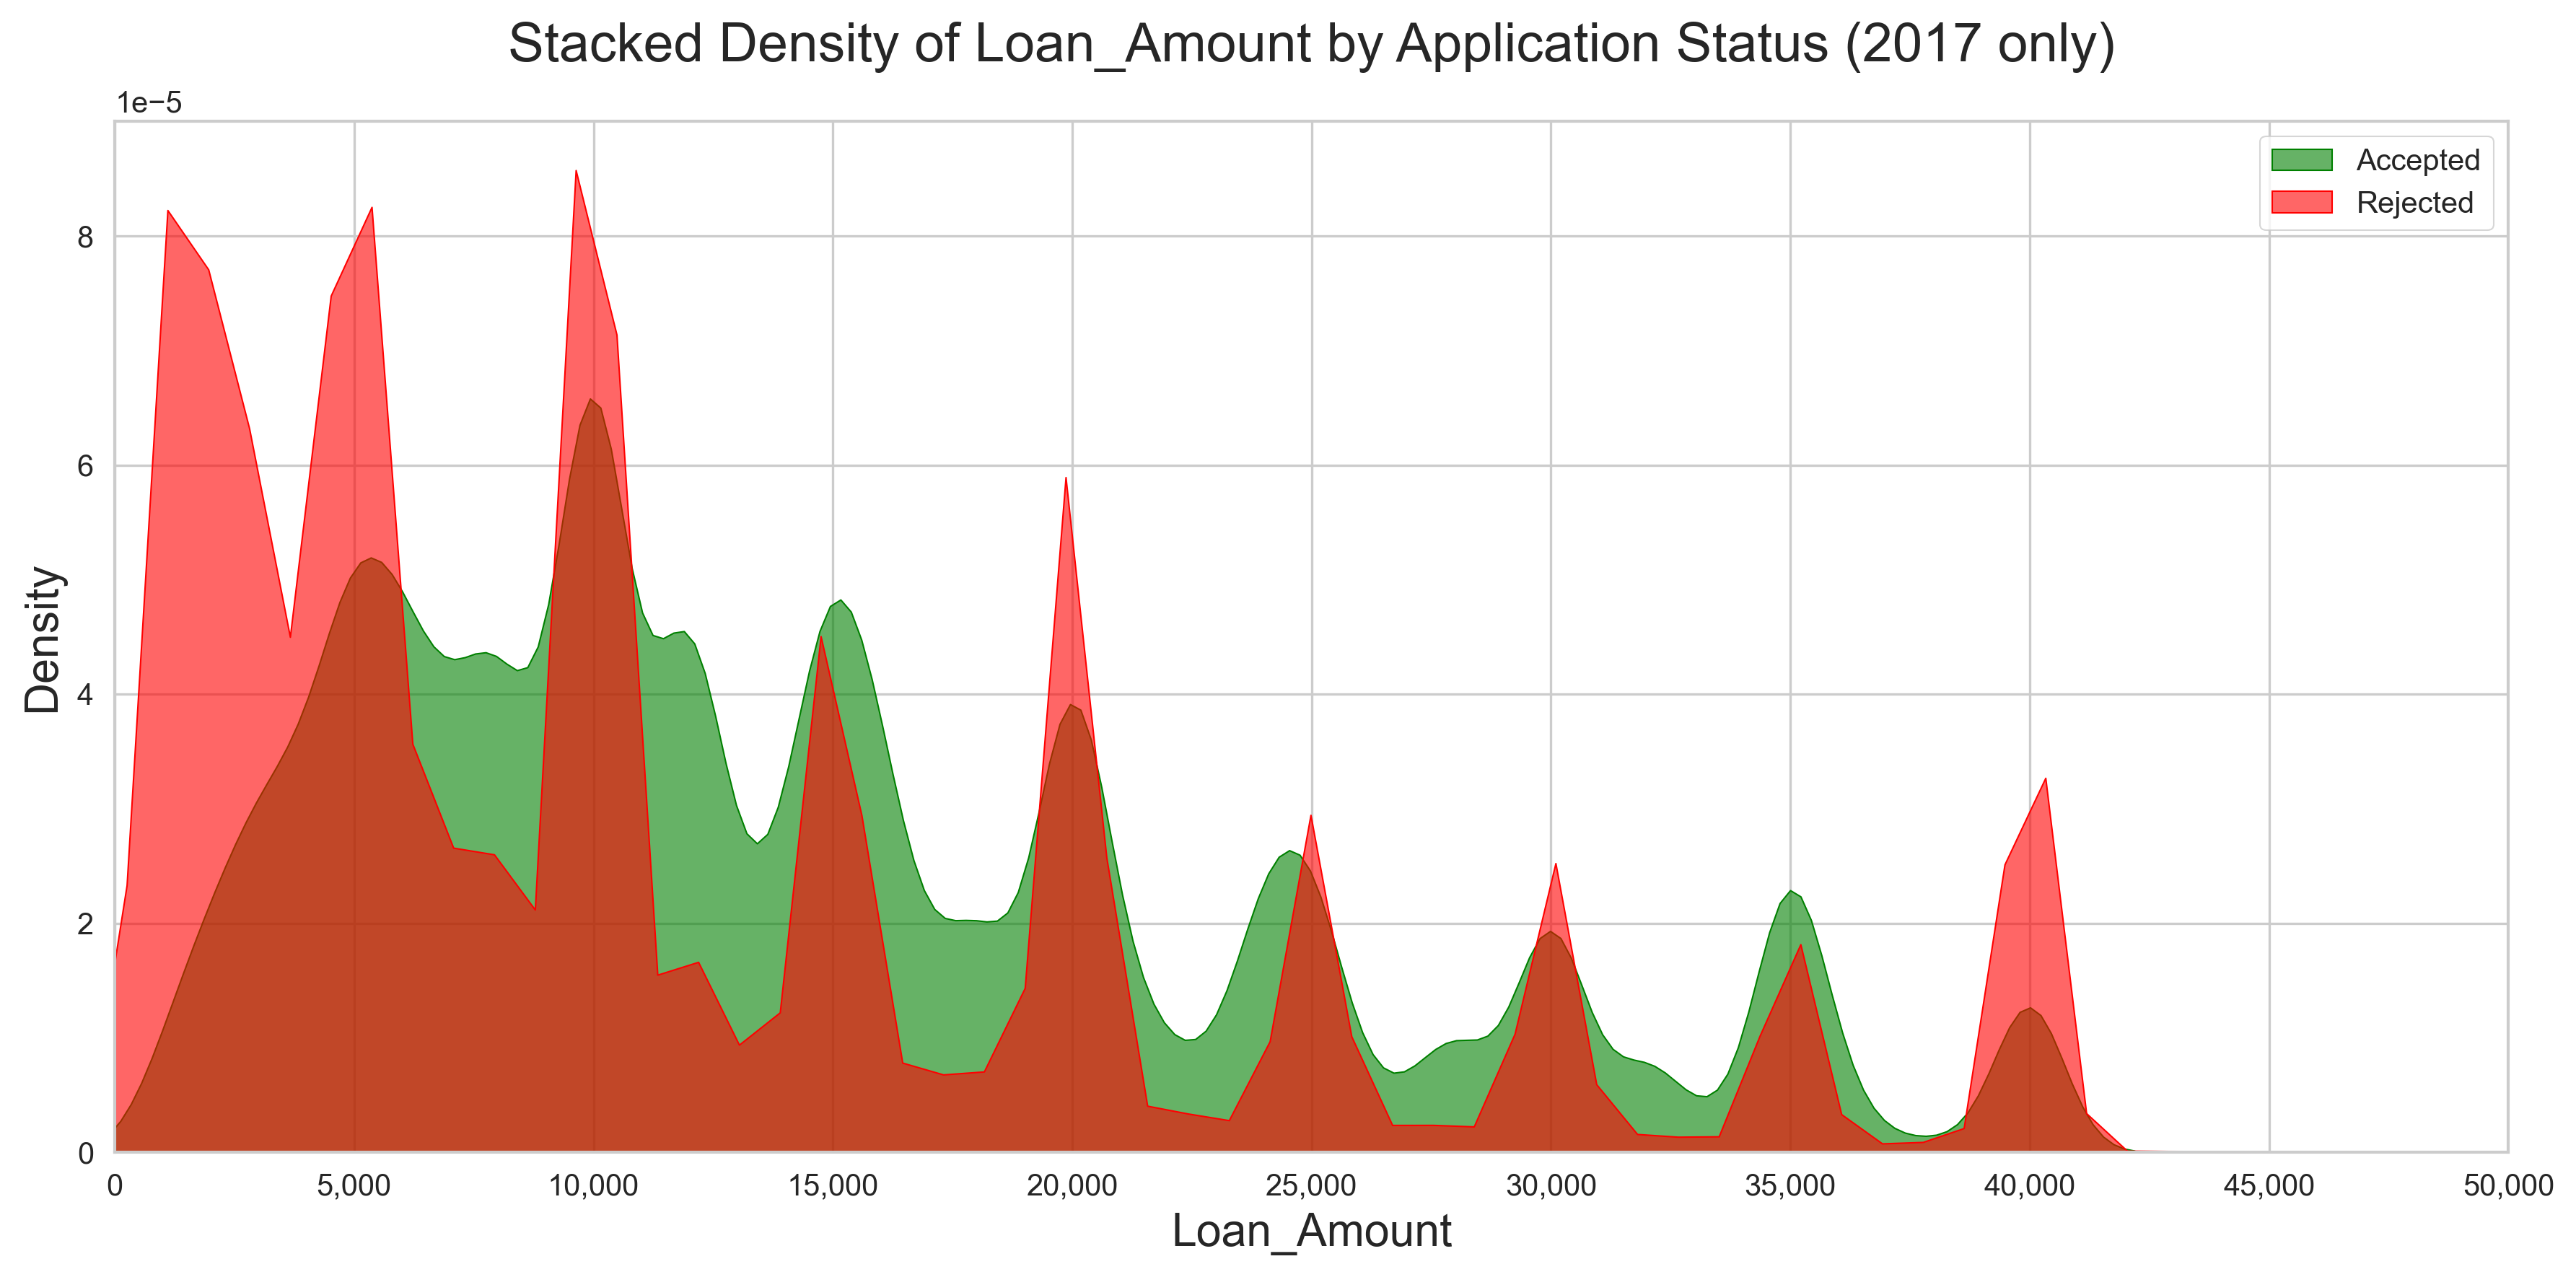

In [29]:
#Stacked Density- Accepted vs Rejected by Loan Amount (2017 only)
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6), dpi=300)

sns.kdeplot(
    data=Accepted_Rejected_2017[Accepted_Rejected_2017['Application'] == 'Accepted'],
    x='Loan_Amount',
    fill=True,
    label='Accepted',
    color='green',
    alpha=0.6
)
sns.kdeplot(
    data=Accepted_Rejected_2017[Accepted_Rejected_2017['Application'] == 'Rejected'],
    x='Loan_Amount',
    fill=True,
    label='Rejected',
    color='red',
    alpha=0.6
)

plt.title('Stacked Density of Loan_Amount by Application Status (2017 only)', fontsize=18, pad=20)
plt.xlabel('Loan_Amount', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(title='')
plt.xlim(0, 50000)
plt.gca().xaxis.set_major_locator(MultipleLocator(5000))
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

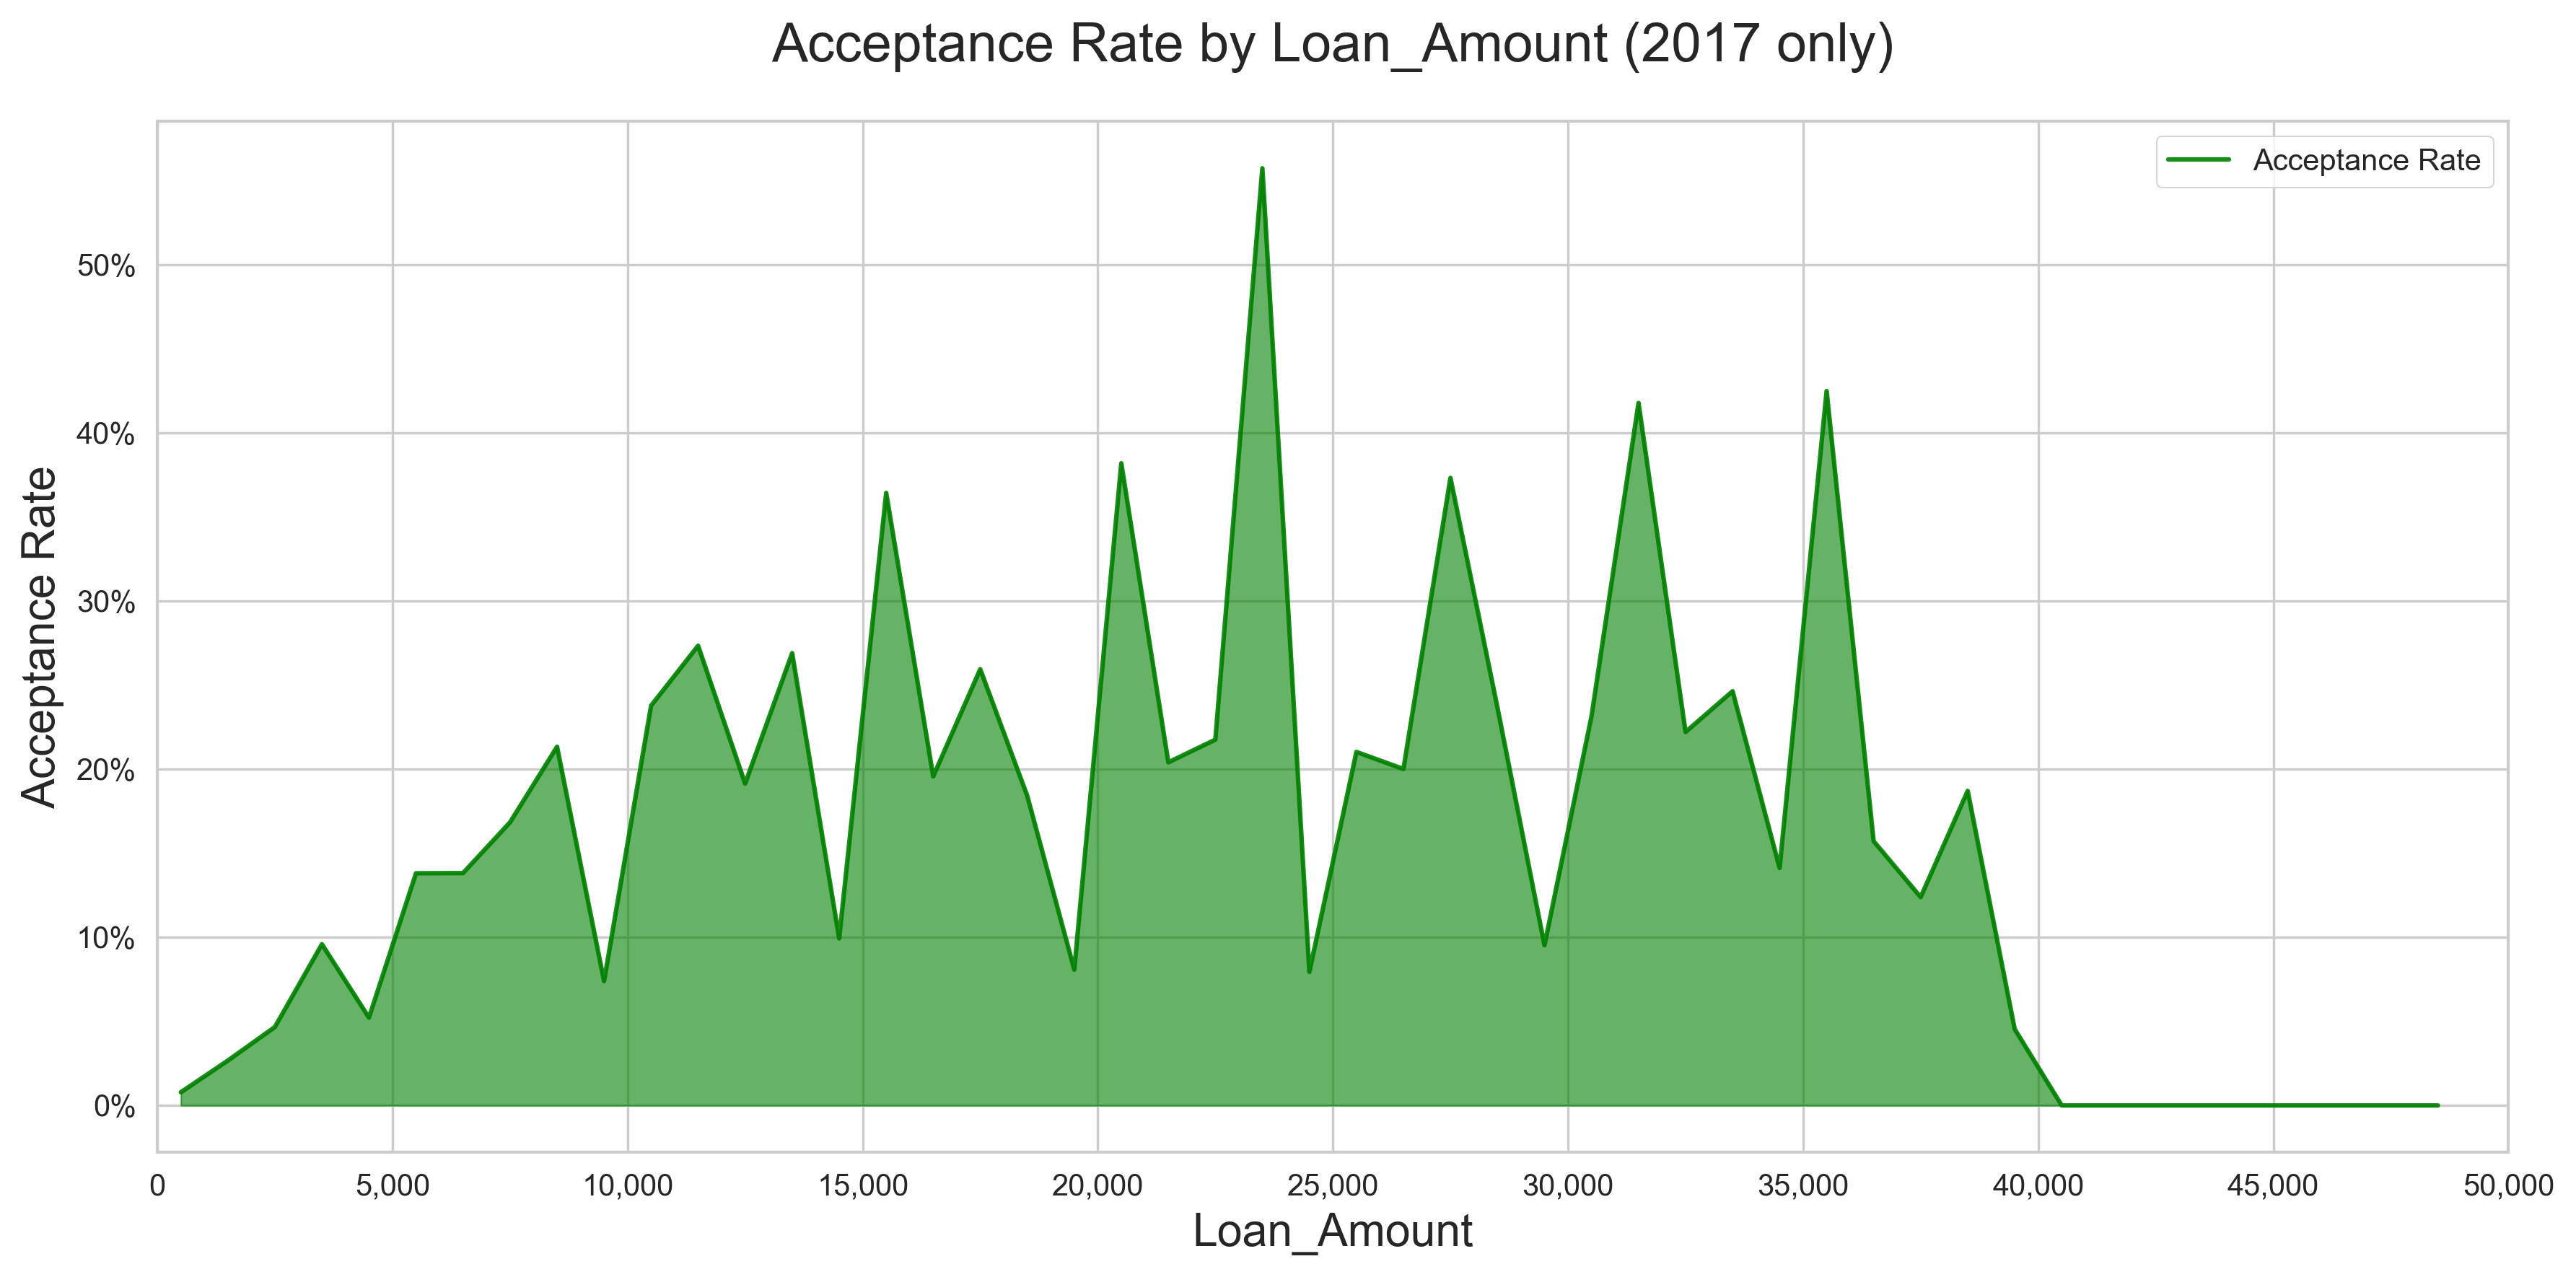

In [30]:
#Bin ACCEPTANCE RATE by Loan Amount (2017 only)
col = 'Loan_Amount'

bins = np.arange(0, 50000, 1000)
Accepted_Rejected_2017['Bin'] = pd.cut(Accepted_Rejected_2017[col], bins)

#Calculate acceptance rate per bin
rate_df = Accepted_Rejected_2017.groupby('Bin', observed=False)['Application'].value_counts().unstack(fill_value=0)
rate_df['Acceptance_Rate'] = rate_df.get('Accepted', 0) / (rate_df.get('Accepted', 0) + rate_df.get('Rejected', 0))

#Use bin midpoints for plotting
bin_midpoints = [interval.mid for interval in rate_df.index]

sns.set_style('whitegrid')
plt.figure(figsize=(12, 6), dpi=300)

plt.fill_between(bin_midpoints, rate_df['Acceptance_Rate'], color='green', alpha=0.6)
plt.plot(bin_midpoints, rate_df['Acceptance_Rate'], color='green', alpha=0.9, label='Acceptance Rate')

plt.title(f'Acceptance Rate by {col} (2017 only)', fontsize=18, pad=20)
plt.xlabel(col, fontsize=15)
plt.ylabel('Acceptance Rate', fontsize=15)
plt.xlim(0, 50000)
plt.gca().xaxis.set_major_locator(MultipleLocator(5000))
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y*100)}%'))
plt.legend(title='')
plt.tight_layout()
plt.show()

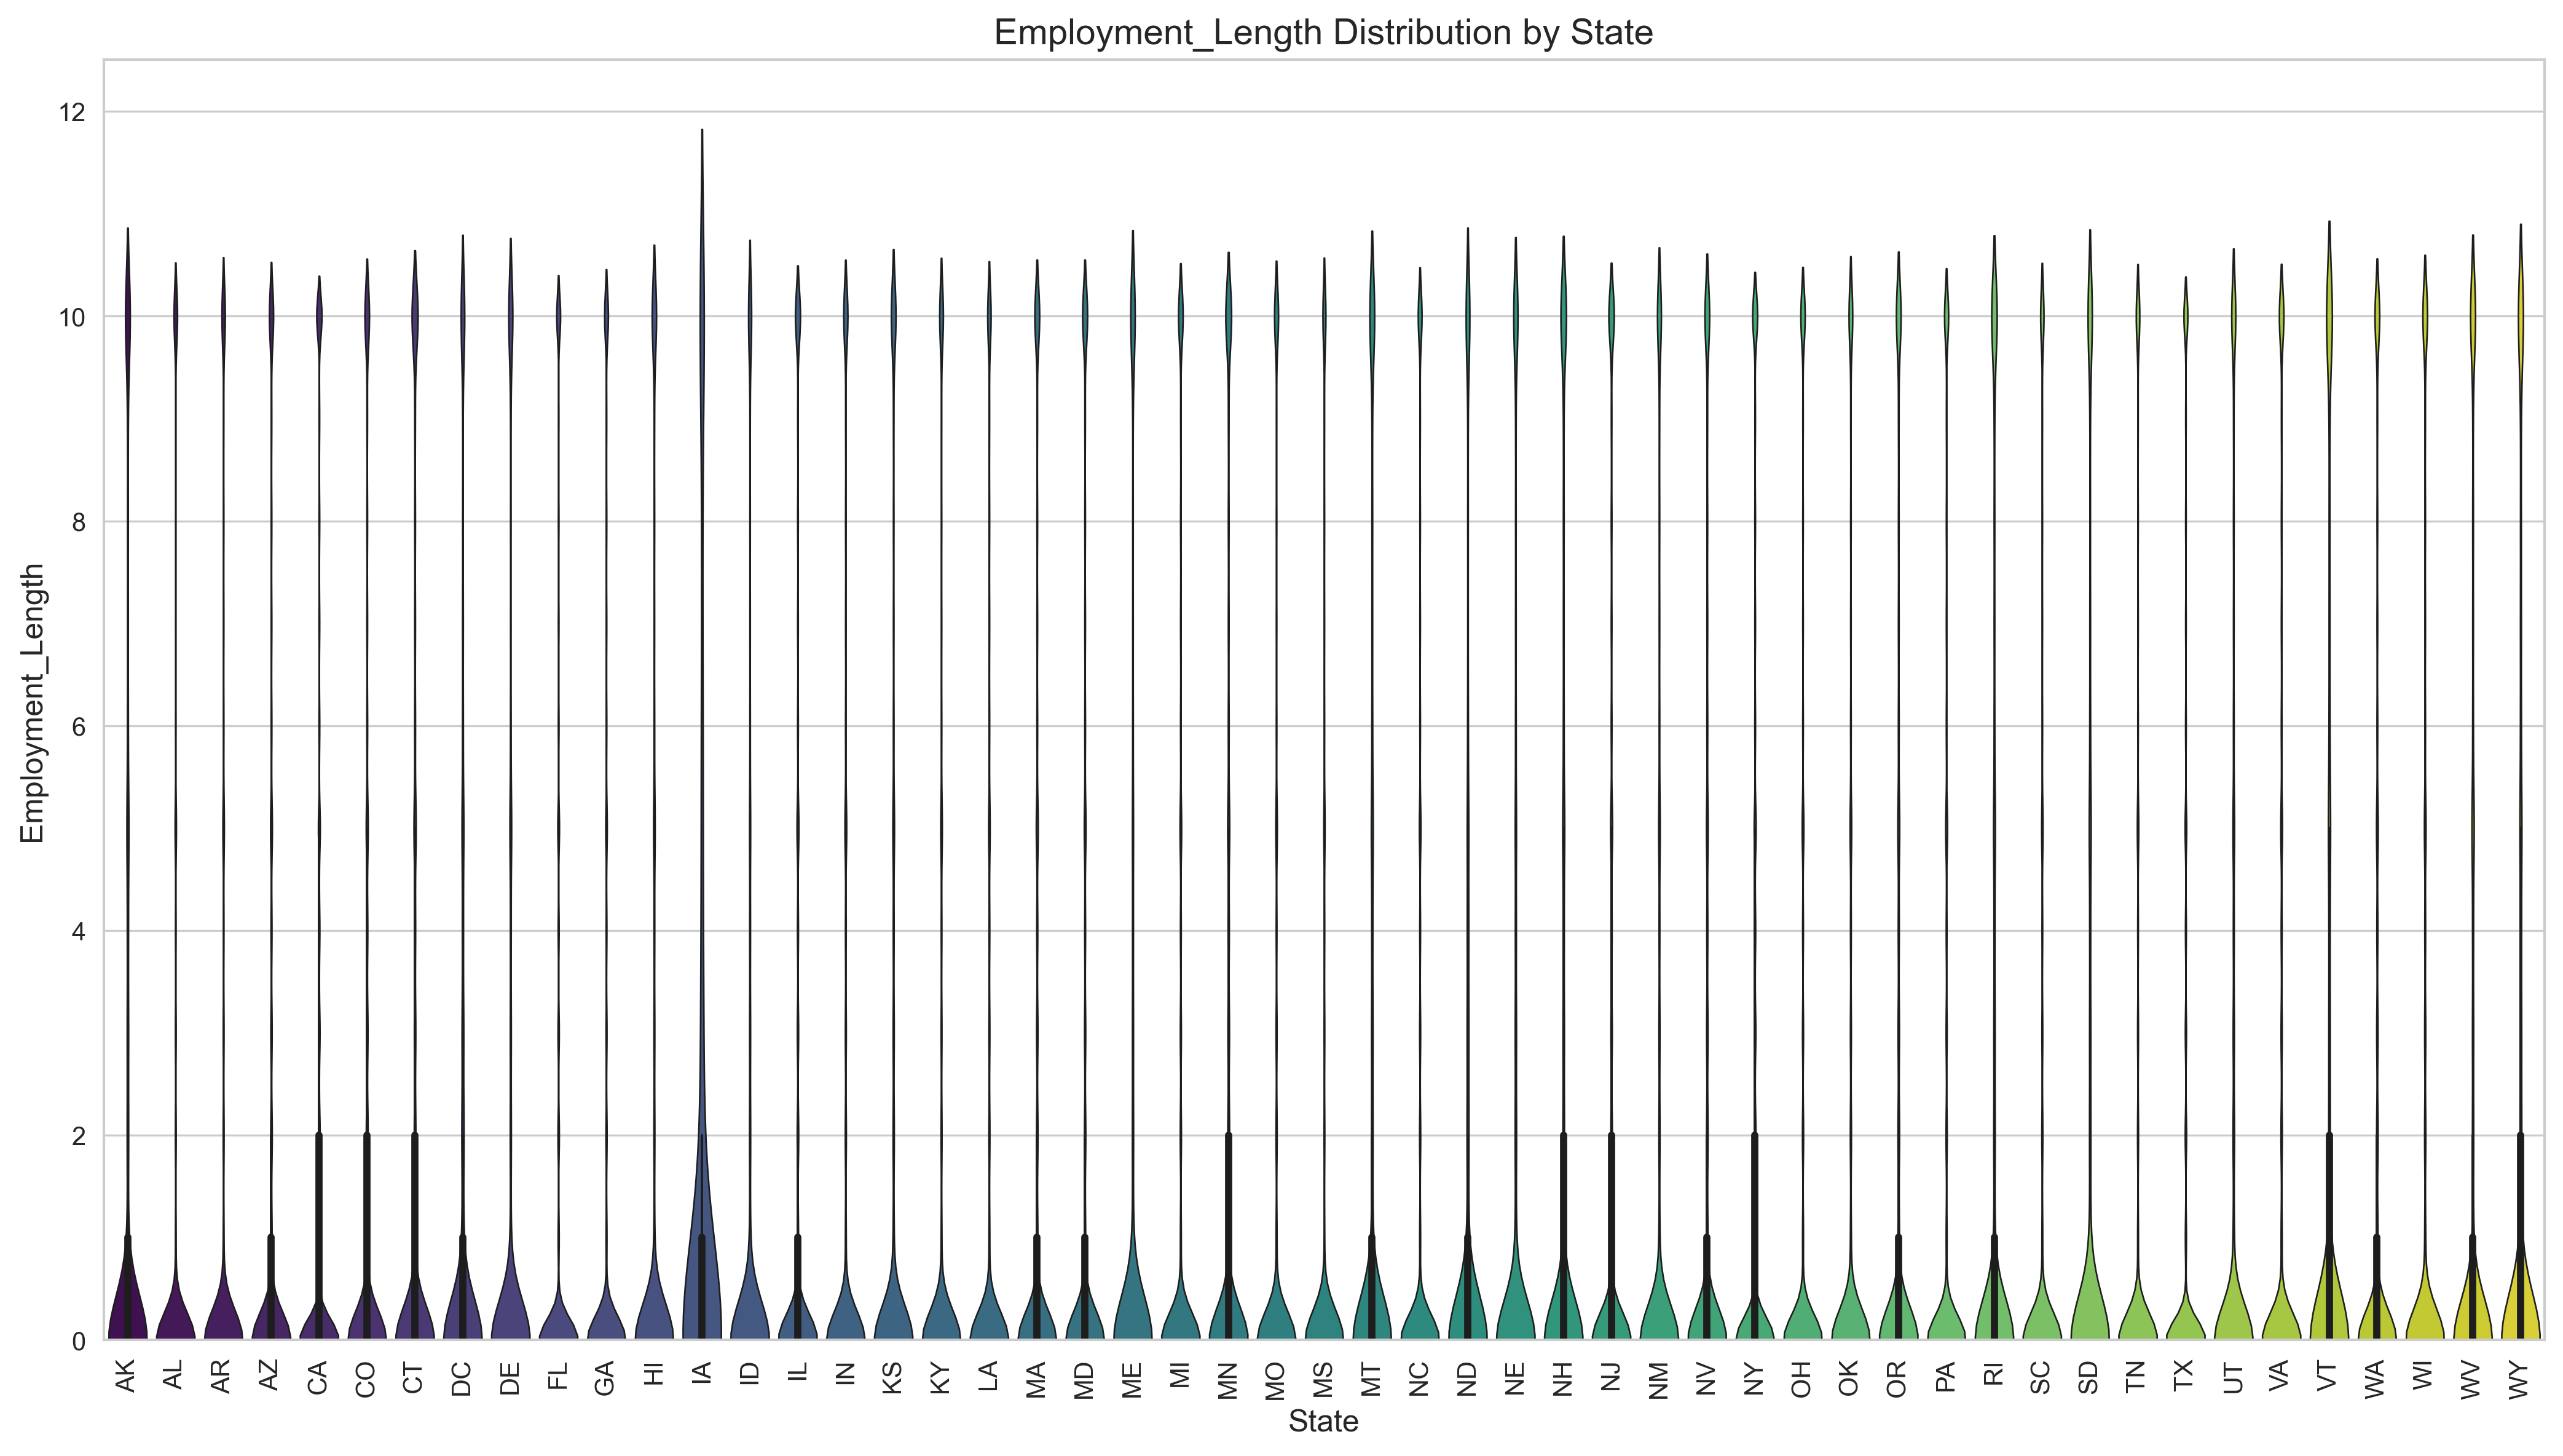

In [31]:
violin_plot('State', 'Employment_Length')

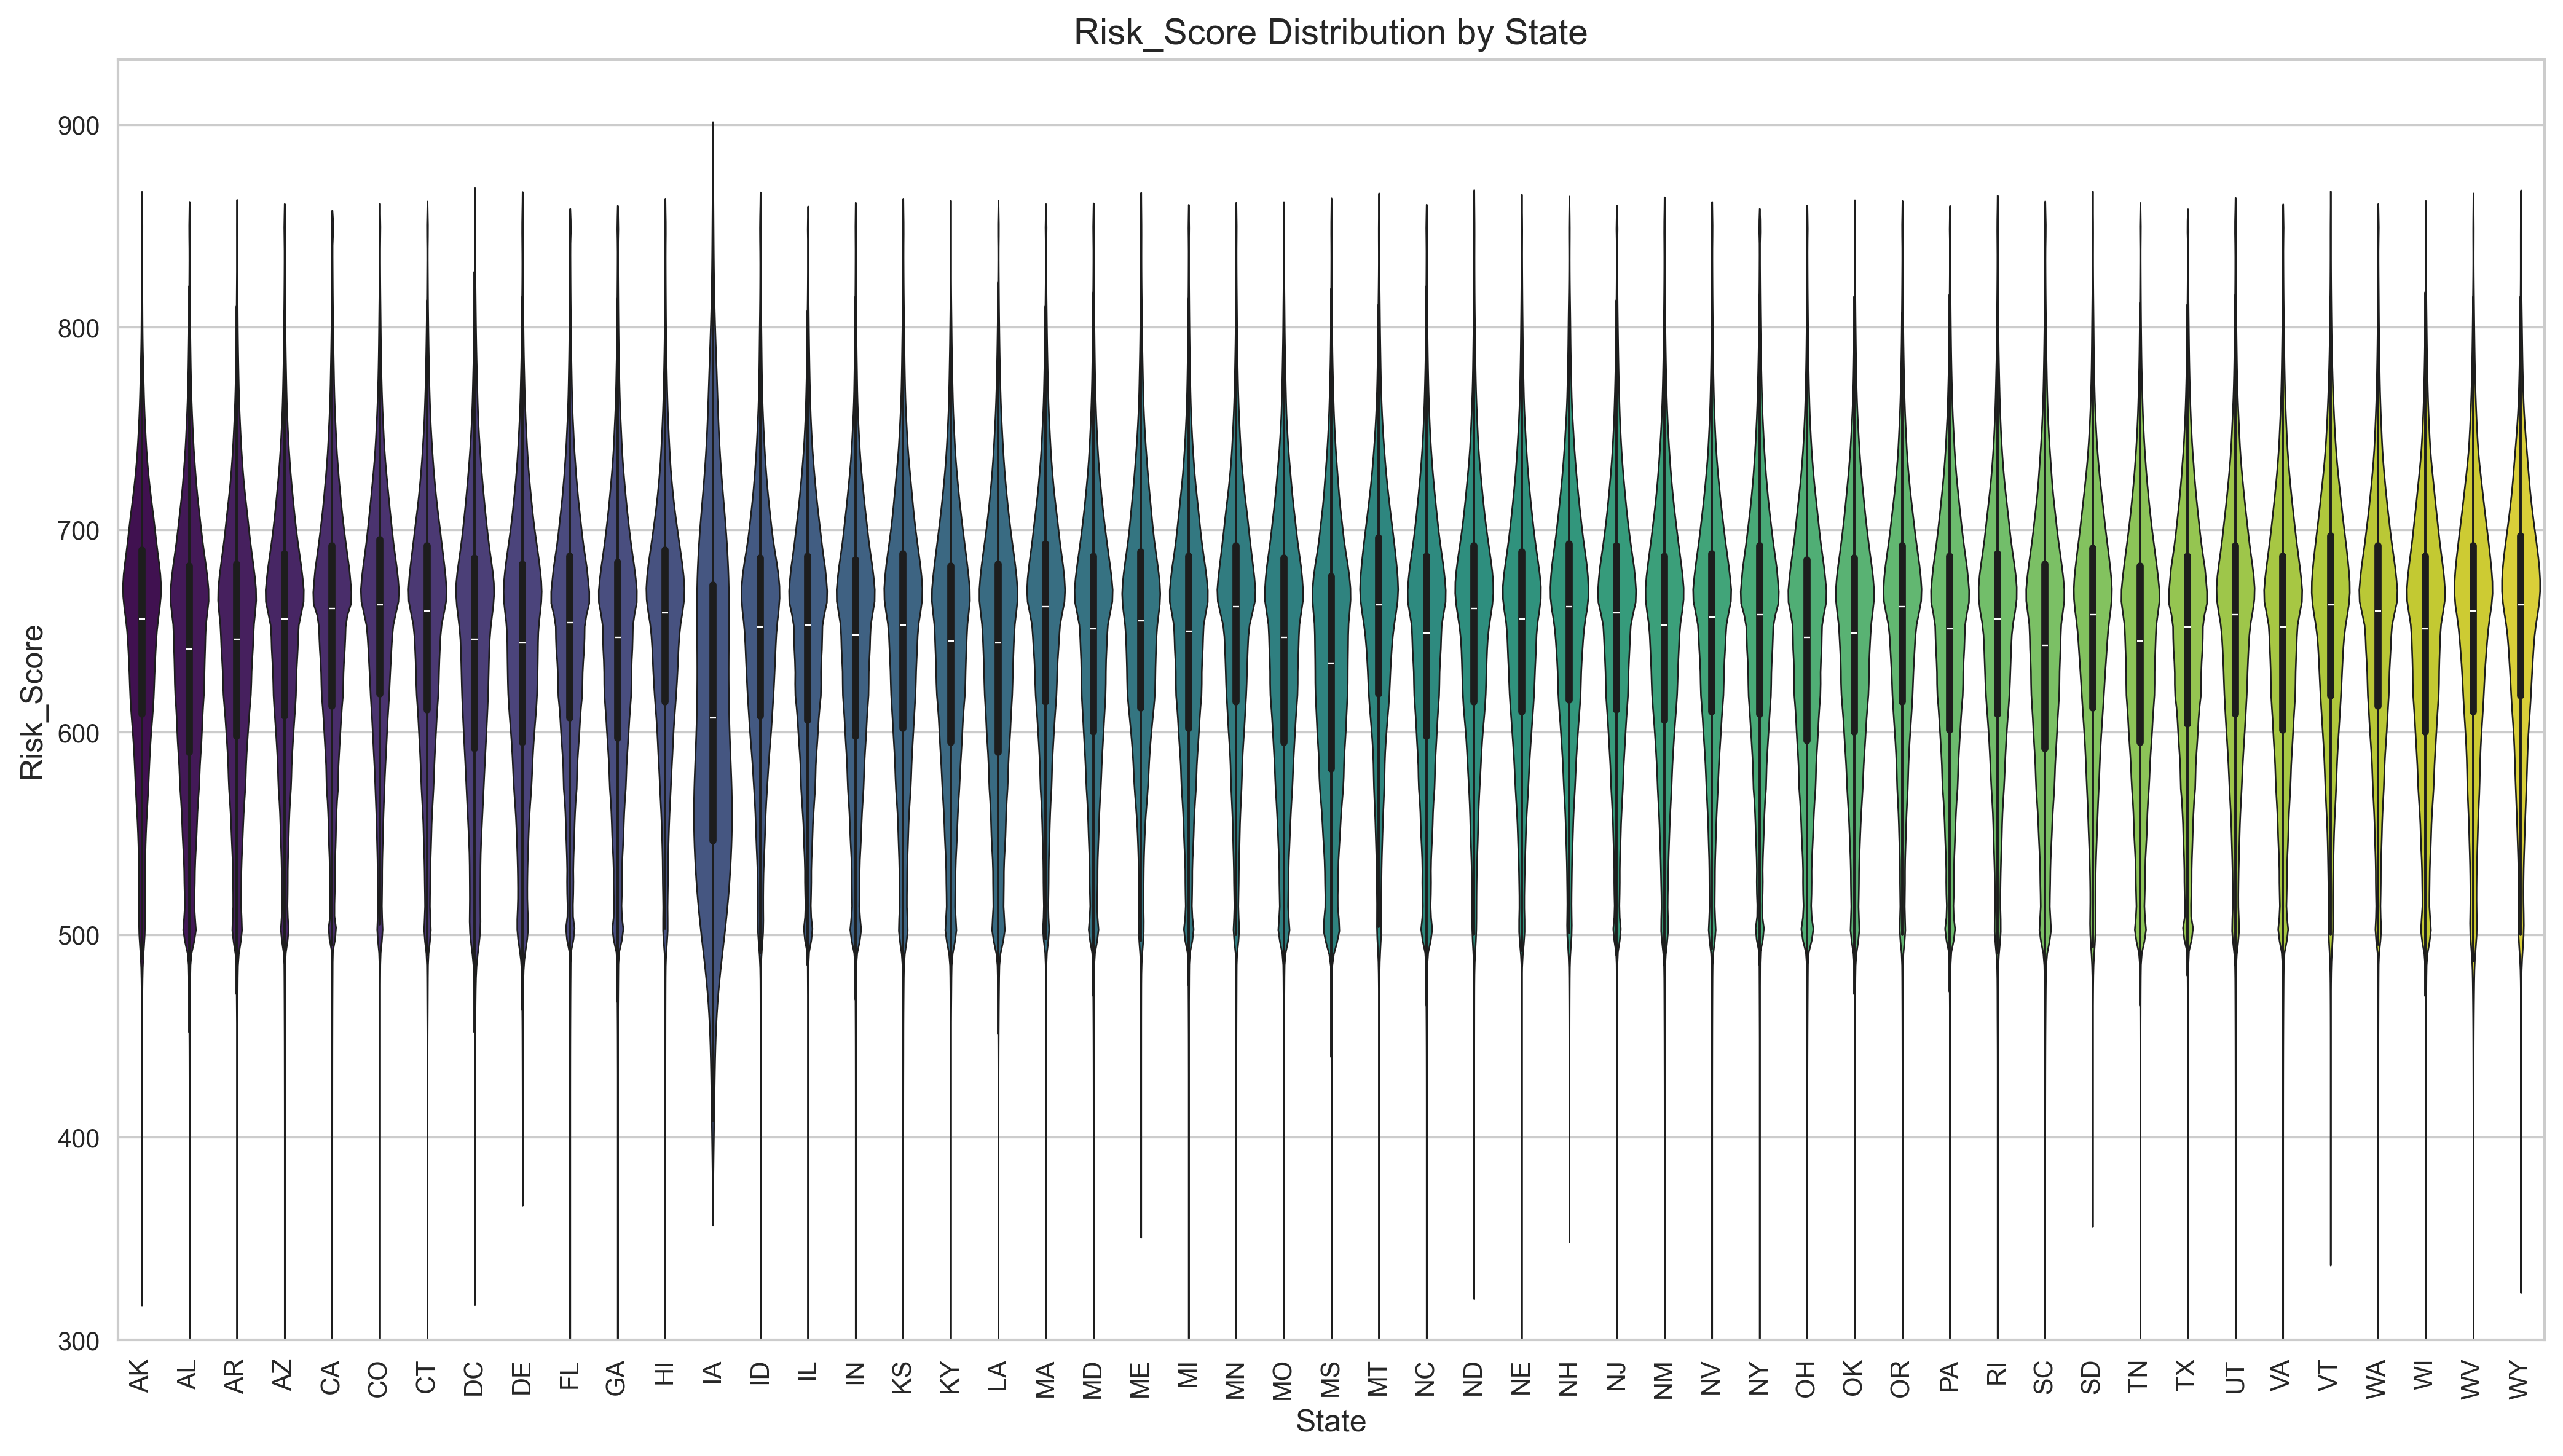

In [32]:
violin_plot('State', 'Risk_Score', yfloor=300)

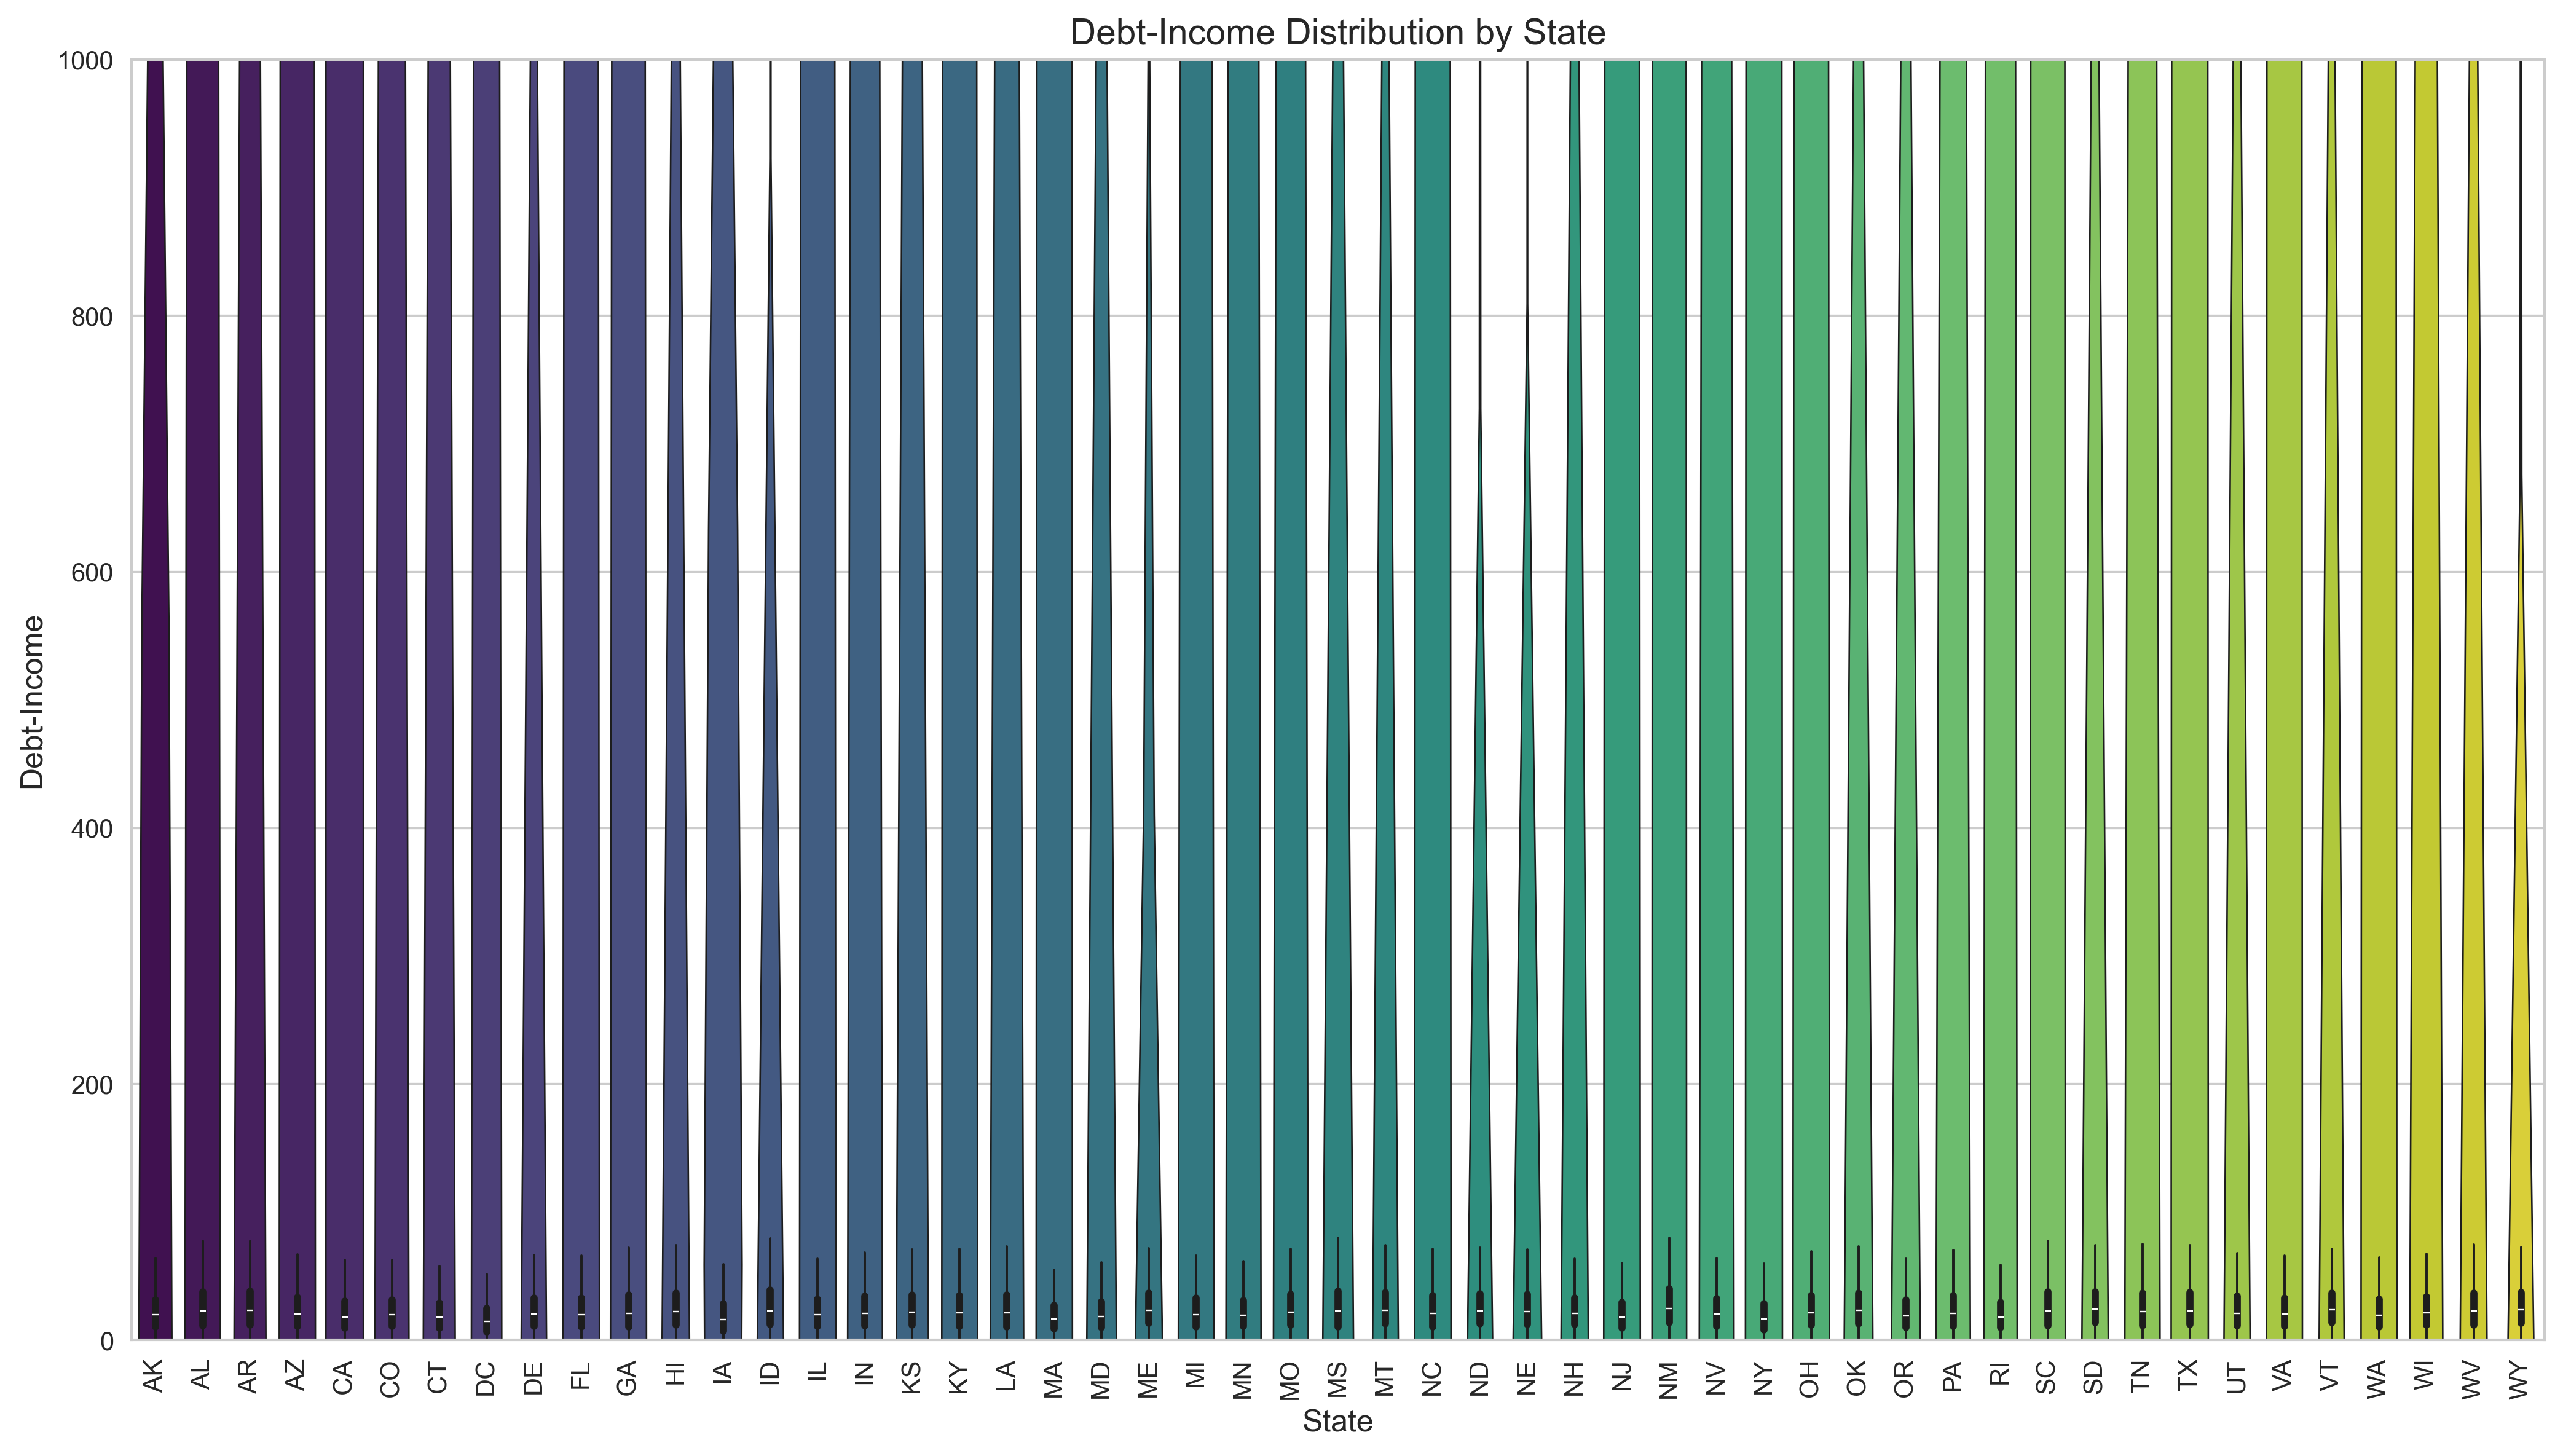

In [33]:
violin_plot('State', 'Debt-Income', yceiling=1000)